In [2]:
import numpy as np
import matplotlib.pyplot as plt
import random
import pandas as pd
import math
import os

I395_A = [[694, 1], [1416, 1], [1779, 1], [2342, 1], [2817, 1], [3330, 1], [3758, 1], [4261, 1], [4715, 1], [5385, 1], [5741, 1], [6398, 1], [7299, 1], [7832, 1], [8171, 1], [8692, 1], [8885, 1], [9409, 1], [9505, 1], [10150, 1], [10182, 1]]
I395_S = [(7128, 1), (2364, 1), (1635, 1), (4138, 1), (3890, 1), (1333, 1), (5680, 1), (9553, 1), (9388, 1), (9454, 1), (4519, 1), (2662, 1), (4586, 1), (5289, 1), (1108, 1), (9914, 1), (7571, 1), (2874, 1), (9231, 1), (9229, 1), (5281, 1)]
I395_L = [(532, 1), (638, 1), (7082, 1), (4386, 1), (10022, 1), (4579, 1), (8194, 1), (9008, 1), (9230, 1), (6328, 1), (7804, 1), (6901, 1), (7581, 1), (7581, 1), (6901, 1), (7731, 1), (3450, 1), (8412, 1), (8884, 1), (7334, 1), (5284, 1), (8029, 1), (9208, 1), (7731, 1)]

I9094_A = [[5366, 1], [195, 2], [286, 3]]
I9094_S = [(3799, 1), (174, 2), (232, 3)]
I9094_L = [(5012, 1), (5266, 1), (442, 3)]

I294l1_A = [[8, 1], [9, 1], [12, 1], [33, 3], [40, 3], [41, 3], [3, 7], [11, 7], [17, 7], [51, 8], [62, 8], [65, 8], [24, 9], [28, 9], [30, 9], [19, 11], [22, 11], [35, 11], [18, 19], [25, 19], [48, 20], [50, 20], [54, 20], [13, 21]]
I294l1_S = [(727, 7), (5557, 8), (46, 3), (17, 1), (33, 1), (65, 1), (24, 3), (575, 3), (628, 3),(15, 7), (24, 7), (67, 7), (81, 8), (145, 8), (197, 8), (32, 9), (48, 9), (778, 9), (38, 11), (132, 11), (497, 11), (321, 19), (1222, 19),(40, 20),(65, 20),(600, 20),(18, 21)]
I294l1_L = [(603, 11), (1115, 20), (4681, 8), (18, 1), (116, 1),(202, 1), (7, 3), (30, 3),(65, 3), (26, 7), (34, 7), (128, 7), (45, 8), (93, 8), (539, 8), (462, 9), (2008, 9), (3062, 9), (12, 11), (39, 11), (121, 11), (4, 19), (108, 19), (55, 20), (806, 20), (1731, 20), (34, 21)]

I294l2_A = [[462, 5], [107, 23], [291, 28], [90, 29], [118, 30], [231, 31], [181, 33], [218, 35], [46, 36], [72, 38], [211, 41], [229, 42]]
I294l2_S = [[143, 5], [18, 23], [234, 28], [38, 29], [81, 30], [352, 31], [317, 33], [2, 35], [176, 36], [292, 38], [89, 41], [299, 42]]
I294l2_L = [(260, 5), (111, 23), (156, 28), (102, 29), (30, 30), (35, 31), (25, 33), (8, 35), (71, 36), (86, 38), (364, 41), (9, 42)]

population_size, num_generations, mutation_rate = 40, 80, 0.1  #simulation parameters
accl_max, v_desired, Tcorr, RT = 3.0, 36.0, 20.0, 0.6 #suggested values from the paper and v_desired=36 is the v_desired from the data
most_leading_leader_id = None

In [7]:
def generate_vehicle_groups(datasets):
    group_lists = {}
    
    for dataset_key, dataset_path in datasets.items():
        # Read the dataset
        df = pd.read_csv(dataset_path)
        df = df.sort_values(by='time')
        df['time'] = df['time'].round(1)
        
        group_A, group_S, group_L = set(), set(), set()  # Use sets to ensure uniqueness
        
        if dataset_key == "I395":
            # Criteria for I395
            for _, row in df.iterrows():
                if row['type-most-common'] == 2 or row['type-most-common'] == 3:
                    group_L.add((row['ID'], row['run-index']))
                elif row['type-most-common'] == 1:
                    group_S.add((row['ID'], row['run-index']))
                elif row['type-most-common'] == 4:
                    group_A.add((row['ID'], row['run-index']))
        else:
            # Determine which column indicates AV/ACC status
            av_column = None
            if "ACC" in df.columns:
                av_column = "ACC"
            elif "AV" in df.columns:
                av_column = "AV"
            
            # Criteria for other datasets
            for _, row in df.iterrows():
                if av_column and str(row[av_column]).strip().lower() == "yes":
                    group_A.add((row['ID'], row['run-index']))
                elif row['type-most-common'] == "small-vehicle":
                    group_S.add((row['ID'], row['run-index']))
                elif row['type-most-common'] == "large-vehicle":
                    group_L.add((row['ID'], row['run-index']))
        
        # Convert sets back to lists
        group_lists[f"{dataset_key}_A"] = [list(item) for item in group_A]
        group_lists[f"{dataset_key}_S"] = [list(item) for item in group_S]
        group_lists[f"{dataset_key}_L"] = [list(item) for item in group_L]
    
    return group_lists

# Example usage
datasets = {
    #"I395": "C:\\Users\\Pedram\\Desktop\\PEDRAM - DO NOT TOUCH\\PT_IDM\\I395-final-run-index.csv",
    "I9094": "C:\\Users\\Pedram\\Desktop\\PEDRAM - DO NOT TOUCH\\PT_IDM\\I90_94_moving_final.csv",
    "I294l1": "C:\\Users\\Pedram\\Desktop\\PEDRAM - DO NOT TOUCH\\PT_IDM\\I294_L1_final.csv",
    "I294l2": "C:\\Users\\Pedram\\Desktop\\PEDRAM - DO NOT TOUCH\\PT_IDM\\I294_L2_final.csv"}

vehicle_groups = generate_vehicle_groups(datasets)

# Access generated lists
"""
I395_A = vehicle_groups["I395_A"]
I395_S = vehicle_groups["I395_S"]
I395_L = vehicle_groups["I395_L"]
"""
I9094_A = vehicle_groups["I9094_A"]
I9094_S = vehicle_groups["I9094_S"]
I9094_L = vehicle_groups["I9094_L"]

I294l1_A = vehicle_groups["I294l1_A"]
I294l1_S = vehicle_groups["I294l1_S"]
I294l1_L = vehicle_groups["I294l1_L"]

I294l2_A = vehicle_groups["I294l2_A"]
I294l2_S = vehicle_groups["I294l2_S"]
I294l2_L = vehicle_groups["I294l2_L"]

KeyError: 'I395_A'

In [21]:
def find_leader_data(df, follower_id, run_index):
    global most_leading_leader_id
    
    follower_data = df[(df['ID'] == follower_id) & (df['run-index'] == run_index)]
    leader_data_dict = {}
    
    for index, row in follower_data.iterrows():
        time = row['time']
        follower_x = row[pos]
        follower_lane = row['lane-kf']
        run_index = row['run-index']

        #find the leader
        leader_data = df[(df['ID'] != follower_id) & (df['time'] == time) & (df['lane-kf'] == follower_lane) & (df[pos] > follower_x) & (df['run-index'] == run_index)]
        
        if not leader_data.empty:
            nearest_leader_row = leader_data.loc[leader_data[pos].sub(follower_x).abs().idxmin()]
            
            leader_id = nearest_leader_row['ID']
            leader_x_val = nearest_leader_row[pos]
            leader_speed_val = nearest_leader_row['speed-kf']

            if leader_id not in leader_data_dict:
                leader_data_dict[leader_id] = {'time': [], 'x_val': [], 'speed_val': []}

            leader_data_dict[leader_id]['time'].append(time)
            leader_data_dict[leader_id]['x_val'].append(leader_x_val)
            leader_data_dict[leader_id]['speed_val'].append(leader_speed_val)

    if leader_data_dict:
        most_leading_leader_id = max(leader_data_dict, key=lambda x: len(leader_data_dict[x]['time']))
        leader_data = leader_data_dict[most_leading_leader_id]
        leader_df = pd.DataFrame({'ID': most_leading_leader_id,
                                   'time': leader_data['time'],
                                   pos: leader_data['x_val'],
                                   'speed-kf': leader_data['speed_val'],
                                   'run-index': run_index})
    else:
        leader_df = pd.DataFrame(columns=['ID', 'time', pos, 'speed-kf', 'run-index'])
    
    return leader_df

def extract_subject_and_leader_data(df, follower_id, run_index):
    sdf = df[(df['ID'] == follower_id) & (df['run-index'] == run_index)].round(2)
    ldf = find_leader_data(df, follower_id, run_index).round(2)
    
    #find the intersection of time frames between leader and subject
    mutual_times = np.intersect1d(ldf['time'], sdf['time'])
    
    #find the longest continuous segment of mutual time
    max_continuous_mutual_times = []
    continuous_mutual_times = []
    prev_time = None
    for time in mutual_times:
        if prev_time is None or time - prev_time < 0.2:  #the time step is 0.1
            continuous_mutual_times.append(time)
        else:
            if len(continuous_mutual_times) > len(max_continuous_mutual_times):
                max_continuous_mutual_times = continuous_mutual_times
            continuous_mutual_times = [time]
        prev_time = time
    
    if len(continuous_mutual_times) > len(max_continuous_mutual_times):
        max_continuous_mutual_times = continuous_mutual_times
    
    #filter leader and subject data to include only the longest continuous mutual time
    ldf = ldf[ldf['time'].isin(max_continuous_mutual_times)]
    sdf = sdf[sdf['time'].isin(max_continuous_mutual_times)]
    
    if (isinstance(sdf, list) and not sdf) or (isinstance(sdf, pd.DataFrame) and sdf.empty):
        print(f"No subject data found for Follower ID {follower_id} and Run Index {run_index}.")
        empty_df = pd.DataFrame()
        return empty_df, empty_df
    
    else:
        start_time = sdf['time'].iloc[0]
        ldf['time'], sdf['time'] = ldf['time'] - start_time, sdf['time'] - start_time
        return sdf, ldf

def acceleration_calculator(i, t, vehicle, accl_max, v_desired, Gamma1, Gamma2, Wm, Wc, Tmax, Alpha, Beta, Tcorr, RT, prng):
    So_D = 3 #default value by Talebpour
    if (vehicle['gap'] - So_D) > 0.1:
        Seff = vehicle['gap'] - So_D
    else:
        Seff = 0.1 #default value by Talebpour

    if vehicle['deltav'] > (Seff / Tmax): #correct
        Tau = Seff / vehicle['deltav']
    else:
        Tau = Tmax

    if vehicle['deltav'] == 0:
        vehicle['deltav'] = 0.0000001 #default value by Talebpour
    if Alpha == 0:
        Alpha = 0.0000001 #default value by Talebpour
    
    Zprime = Tau / (2.0 * Alpha * vehicle['speed']) # correct
    Zdoubleprime = 0.0

    #if Wc * Zprime >= 1:
    if Wc * Zprime > 0:
        a0 = 1
        #Zstar = (-1 * math.sqrt(2.0 * math.log(a0 * Wc * Zprime))) / (math.sqrt(2.0 * math.pi)) #default by Talebpour
        Zstar = -np.sqrt(2 * np.log(a0 * Wc * Zprime / np.sqrt(2 * np.pi))) #sharika
    else:
        Zstar = 0.0
    Astar = (2.0 / Tau) * ((Seff / Tau) - vehicle['deltav'] + (Alpha * vehicle['speed'] * Zstar)) #correct
    
    for NewtonCounter in range(3):
        X = Astar 
        if X >= 0:
            if X == 0:
                X = 0.0000001 #default value by Talebpour
            Uptprime = Gamma1 * math.pow(X, Gamma1 - 1)
            Uptdoubleprime = Gamma1 * (Gamma1 - 1) * math.pow(X, Gamma1 - 2)
        else:
            Uptprime = Wm * Gamma2 * pow(-X, Gamma2 - 1)
            Uptdoubleprime = -Wm * Gamma2 * (Gamma2 - 1) * pow(-X, Gamma2 - 2)

        Z = (vehicle['deltav'] + (0.5 * X * Tau) - (Seff / Tau)) / (Alpha * vehicle['deltav']) # density of a Gaussian # correct
        #fn = norm.cdf(Z)
        fn = (1.0 / np.sqrt(2 * np.pi)) * np.exp(-Z ** 2.0 / 2.0) #sharika PDF
        F = Uptprime - Wc * fn * Zprime # correct
        
        Fprime = Uptdoubleprime - Wc * fn * (Z * math.pow(Zprime, 2.0) + Zdoubleprime)
        if Fprime == 0:
            Fprime = 0.000000000001 #default value by Talebpour

        Astar = Astar - (F / Fprime)

    X = Astar
    if X >= 0:
        Uptprime = Gamma1 * (X ** max(Gamma1 - 1, 0))  # Ensures no negative base issue
        Uptdoubleprime = Gamma1 * (Gamma1 - 1) * (X ** max(Gamma1 - 2, 0))
    else:
        Uptprime = Wm * Gamma2 * ((-X) ** max(Gamma2 - 1, 0))
        Uptdoubleprime = -Wm * Gamma2 * (Gamma2 - 1) * ((-X) ** max(Gamma2 - 2, 0))

    """ original code with the negative issue
    if X >= 0:
        Uptprime = Gamma1 * math.pow(X, Gamma1 - 1)
        Uptdoubleprime = Gamma1 * (Gamma1 - 1) * math.pow(X, Gamma1 - 2)
    else:
        Uptprime = Wm * Gamma2 * math.pow(-X, Gamma2 - 1)
        Uptdoubleprime = -Wm * Gamma2 * (Gamma2 - 1) * math.pow(-X, Gamma2 - 2)
    """
    
    Z = (vehicle['deltav'] + (0.5 * Astar * Tau) - (Seff / Tau)) / (Alpha * vehicle['deltav'])
    # fn = norm.cdf(Z) #default value by Talebpour
    fn = (1.0 / np.sqrt(2 * np.pi)) * np.exp(-Z ** 2.0 / 2.0) #sharika PDF
    
    F = Uptprime - Wc * fn * Zprime
    Fprime = Uptdoubleprime - Wc * fn * (Z * math.pow(Zprime, 2.0) + Zdoubleprime)
    if Fprime == 0:
        Fprime = 0.000000000001

    Var = -1.0 / (Beta * Fprime)
    
    Random_Wiener = np.random.rand()
    
    Yt = math.exp(-1 * 0.1 / Tau) + math.sqrt(24.0 * 0.1 / Tau) * Random_Wiener #default value by Talebpour
    
    accl_cf = Astar + Var * Yt
    accl_ff = accl_max * (1 - (vehicle['speed'] / v_desired))
    accl_ = np.minimum(accl_cf, accl_ff)

    if accl_ > 3: #default value by Talebpour
        accl_ = 3
    elif accl_ < -8: #default value by Talebpour
        accl_ = -8
    return accl_, fn, Wc * fn


def simulate_car_following(params):
    global Tmax, Alpha, Beta, Wc, Gamma1, Gamma2, Wm
    Tmax, Alpha, Beta, Wc, Gamma1, Gamma2, Wm = params
    
    num_steps = round(total_time / time_step)
    time = np.linspace(0, total_time, num_steps)
    
    position = np.zeros(num_steps)
    speed = np.zeros(num_steps)
    acl = np.zeros(num_steps)
    
    position[0] = sdf.iloc[0][pos]
    speed[0] = sdf.iloc[0]['speed-kf']
    acl[0] = 0

    for i in range(1, num_steps):
        dt = time_step
        desired_position = position[i - 1] + speed[i - 1] * dt
        
        acceleration, _, _ = acceleration_calculator(i, time[i], {'gap': leader_position[i-1] - position[i-1], 'deltav': leader_speed[i-1] - speed[i-1], 'speed': speed[i-1], 'vehID': follower_id}, accl_max, v_desired, Gamma1, Gamma2, Wm, Wc, Tmax, Alpha, Beta, Tcorr, RT, np.random.default_rng())

        acl[i] = acceleration
        speed[i] = speed[i - 1] + acceleration * dt
        position[i] = position[i - 1] + speed[i-1] * dt + 0.5 * acceleration * (dt**2)
        
    return position, speed, acl

def fitness(params):
    # Define weights for position and speed errors
    weight_position = 1.0  # Full weight for position
    weight_speed = 0.5     # Half weight for speed

    # Simulate car following
    sim_position, sim_speed, acl = simulate_car_following(params)
    diff_position = np.array(sim_position) - np.array(target_position)
    diff_speed = np.array(sim_speed) - np.array(target_speed)
    
    # Calculate errors with weights
    mse_position = np.mean(diff_position ** 2) * weight_position
    mse_speed = np.mean(diff_speed ** 2) * weight_speed
    mse = mse_position + mse_speed
    
    rmse_position = np.sqrt(mse_position)
    rmse_speed = np.sqrt(mse_speed)
    rmse = np.sqrt(mse)
    
    mae_position = np.mean(np.abs(diff_position)) * weight_position
    mae_speed = np.mean(np.abs(diff_speed)) * weight_speed
    mae = mae_position + mae_speed
    
    mape_position = np.mean(np.abs(diff_position / np.array(target_position))) * 100 * weight_position
    mape_speed = np.mean(np.abs(diff_speed / np.array(target_speed))) * 100 * weight_speed
    mape = (mape_position + mape_speed) / 2
    
    nrmse_position = rmse_position / (np.max(target_position) - np.min(target_position))
    nrmse_speed = rmse_speed / (np.max(target_speed) - np.min(target_speed))
    nrmse = (nrmse_position * weight_position + nrmse_speed * weight_speed) / (weight_position + weight_speed)
    
    sse_position = np.sum(diff_position ** 2) * weight_position
    sse_speed = np.sum(diff_speed ** 2) * weight_speed
    sse = sse_position + sse_speed
    
    ss_res_position = np.sum(diff_position ** 2) * weight_position
    ss_tot_position = np.sum((np.array(target_position) - np.mean(target_position)) ** 2)
    r2_position = 1 - (ss_res_position / ss_tot_position)

    ss_res_speed = np.sum(diff_speed ** 2) * weight_speed
    ss_tot_speed = np.sum((np.array(target_speed) - np.mean(target_speed)) ** 2)
    r2_speed = 1 - (ss_res_speed / ss_tot_speed)
    
    r2 = (r2_position * weight_position + r2_speed * weight_speed) / (weight_position + weight_speed)
    
    total_diff = np.sum(np.abs(diff_position)) * weight_position + np.sum(np.abs(diff_speed)) * weight_speed
    
    # Fitness is the inverse of total error to maximize fitness
    fitness_value = 1.0 / (total_diff + 1e-5)
    
    # Store all error metrics in a dictionary
    error_metrics = {
        'MSE': mse,
        'RMSE': rmse,
        'MAE': mae,
        'MAPE': mape,
        'NRMSE': nrmse,
        'SSE': sse,
        'R-squared': r2,
        'Total Difference': total_diff
    }
    
    return fitness_value, error_metrics  # Return fitness and all error metrics


def crossover(parent1, parent2):
    crossover_point = random.randint(0, len(parent1) - 1)
    child1 = parent1[:crossover_point] + parent2[crossover_point:]
    child2 = parent2[:crossover_point] + parent1[crossover_point:]
    return child1, child2

def mutate(child):
    for i in range(len(child)):
        if random.random() < mutation_rate:
            child[i] += random.uniform(-0.1, 0.1)
    return child

def genetic_algorithm():
    #define parameter ranges for PT model
    Tmax_range = (2, 8.0)
    Alpha_range = (0, 0.6)
    Beta_range = (2, 8)
    Wc_range = (60000, 130000)
    Gamma1_range = (0.3, 2.0)
    Gamma2_range = (0.3, 2.0)
    Wm_range = (2, 8.0)

    #population with random parameter values
    population = [[random.uniform(*range_) for range_ in (Tmax_range, Alpha_range, Beta_range, Wc_range, Gamma1_range, Gamma2_range, Wm_range)]
                  for _ in range(population_size)]
    
    best_error = float('inf')
    best_individual = None
    best_metrics = None
    
    for generation in range(num_generations):
        #evaluate fitness and errors
        fitness_and_errors = [fitness(individual) for individual in population]
        population_sorted = sorted(zip(population, fitness_and_errors), key=lambda x: x[1][0], reverse=True)
        population = [ind for ind, _ in population_sorted]
        
        #Update best individual and best error if a better one is found
        current_best_error = population_sorted[0][1][1]['Total Difference']  # Error is the second element of the fitness_and_errors tuple
        if current_best_error < best_error:
            best_error = current_best_error
            best_individual = population_sorted[0][0]
            best_metrics = population_sorted[0][1][1]  # Best error metrics
        
        #Parent selection (top half of the sorted population)
        parents = population[:len(population) // 2]
        
        children = []
        while len(children) < (population_size - len(parents)):
            parent1, parent2 = random.sample(parents, 2)
            child1, child2 = crossover(parent1, parent2)
            children.extend([mutate(child1), mutate(child2)])
        population = parents + children[:population_size - len(parents)]
    
    #return the best individual, best error, and best error metrics after all generations
    return best_individual, best_error, best_metrics

def plot_simulation(timex, leader_position, target_position, sim_position, leader_speed, target_speed, sim_speed, follower_id, most_leading_leader_id, run_index, save_dir):
    plt.figure(figsize=(10, 12))
    plt.subplot(2, 1, 1)
    plt.plot(timex, leader_position, label='Leader')
    plt.plot(timex, target_position, label='Target')
    plt.plot(timex, sim_position, label='Simulated Follower')
    plt.xlabel('time (sec)')
    plt.ylabel('Position (m)')
    plt.title(f'Position vs time, FID: {follower_id}, LID: {int(most_leading_leader_id)}, run: {run_index}')
    plt.legend()
    plt.grid(True)
    plt.subplot(2, 1, 2)
    plt.plot(timex, leader_speed, label='Leader')
    plt.plot(timex, target_speed, label='Target')
    plt.plot(timex, sim_speed, label='Simulated Follower')
    plt.xlabel('time (sec)')
    plt.ylabel('Speed (m/s)')
    plt.title(f'Speed vs time, FID: {follower_id}, LID: {int(most_leading_leader_id)}, run: {run_index}')
    plt.legend()
    plt.grid(True)
    plot_filename = os.path.join(save_dir, f'{outname}_FID_{follower_id}_LID_{int(most_leading_leader_id)}_run_{run_index}.png')
    plt.savefig(plot_filename)
    plt.close()

def visualize_parameter_distributions(all_params):
    param_names = ['Tmax', 'Alpha', 'Beta', 'Wc', 'Gamma1', 'Gamma2', 'Wm']
    num_params = len(param_names)
    
    #convert list of lists into a 2D numpy array for easier column-wise access
    all_params_array = np.array(all_params)
    
    #histograms for each parameter
    fig, axs = plt.subplots(1, num_params, figsize=(20, 4))
    for i in range(num_params):
        axs[i].hist(all_params_array[:, i], bins=20, color='skyblue', edgecolor='black')
        axs[i].set_title(param_names[i])
        axs[i].set_xlabel('Value')
        axs[i].set_ylabel('Frequency')
    
    plt.tight_layout()
    plt.show()

    #create box plots for each parameter
    plt.figure(figsize=(10, 6))
    plt.boxplot(all_params_array, labels=param_names, patch_artist=True)
    plt.title('Distribution of PT Model Parameters')
    plt.ylabel('Value')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

Processing Follower ID: 2690, Run Index: 2
Processing Follower ID: 13629, Run Index: 1
Processing Follower ID: 4468, Run Index: 2
Processing Follower ID: 345, Run Index: 3
Processing Follower ID: 8941, Run Index: 1
Processing Follower ID: 479, Run Index: 3
Processing Follower ID: 7675, Run Index: 1
Processing Follower ID: 6983, Run Index: 2


C:\Users\Pedram\AppData\Local\Temp\ipykernel_1648\985960118.py:226: RuntimeWarning: divide by zero encountered in divide
  mape_speed = np.mean(np.abs(diff_speed / np.array(target_speed))) * 100 * weight_speed


Processing Follower ID: 10798, Run Index: 1
Processing Follower ID: 12838, Run Index: 1


C:\Users\Pedram\AppData\Local\Temp\ipykernel_1648\985960118.py:226: RuntimeWarning: divide by zero encountered in divide
  mape_speed = np.mean(np.abs(diff_speed / np.array(target_speed))) * 100 * weight_speed


Processing Follower ID: 34, Run Index: 3
Processing Follower ID: 246, Run Index: 2
Processing Follower ID: 19168, Run Index: 1
Processing Follower ID: 18173, Run Index: 1
Processing Follower ID: 13051, Run Index: 1
Processing Follower ID: 247, Run Index: 3
Processing Follower ID: 22812, Run Index: 1
Processing Follower ID: 4973, Run Index: 2
Processing Follower ID: 11224, Run Index: 1
Processing Follower ID: 12868, Run Index: 1


C:\Users\Pedram\AppData\Local\Temp\ipykernel_1648\985960118.py:226: RuntimeWarning: divide by zero encountered in divide
  mape_speed = np.mean(np.abs(diff_speed / np.array(target_speed))) * 100 * weight_speed


Processing Follower ID: 3108, Run Index: 2
Processing Follower ID: 16125, Run Index: 1
Processing Follower ID: 5573, Run Index: 2


C:\Users\Pedram\AppData\Local\Temp\ipykernel_1648\985960118.py:226: RuntimeWarning: divide by zero encountered in divide
  mape_speed = np.mean(np.abs(diff_speed / np.array(target_speed))) * 100 * weight_speed


Processing Follower ID: 539, Run Index: 3


C:\Users\Pedram\AppData\Local\Temp\ipykernel_1648\985960118.py:226: RuntimeWarning: divide by zero encountered in divide
  mape_speed = np.mean(np.abs(diff_speed / np.array(target_speed))) * 100 * weight_speed


Processing Follower ID: 7572, Run Index: 1
Processing Follower ID: 1668, Run Index: 2
Processing Follower ID: 6915, Run Index: 2
Processing Follower ID: 5786, Run Index: 2
Processing Follower ID: 18937, Run Index: 1
Processing Follower ID: 11641, Run Index: 1
Processing Follower ID: 144, Run Index: 3
Processing Follower ID: 228, Run Index: 2
Processing Follower ID: 4480, Run Index: 2
No subject data found for Follower ID 2955 and Run Index 2.
Processing Follower ID: 2955, Run Index: 2
No data found for Follower ID 2955 and Run Index 2. Skipping...
Processing Follower ID: 13632, Run Index: 1
Processing Follower ID: 16368, Run Index: 1
Processing Follower ID: 348, Run Index: 3
Processing Follower ID: 482, Run Index: 3
Processing Follower ID: 2085, Run Index: 2


C:\Users\Pedram\AppData\Local\Temp\ipykernel_1648\985960118.py:226: RuntimeWarning: divide by zero encountered in divide
  mape_speed = np.mean(np.abs(diff_speed / np.array(target_speed))) * 100 * weight_speed


Processing Follower ID: 7291, Run Index: 1
Processing Follower ID: 3901, Run Index: 2
Processing Follower ID: 2644, Run Index: 2


C:\Users\Pedram\AppData\Local\Temp\ipykernel_1648\985960118.py:226: RuntimeWarning: divide by zero encountered in divide
  mape_speed = np.mean(np.abs(diff_speed / np.array(target_speed))) * 100 * weight_speed


Processing Follower ID: 18359, Run Index: 1
Processing Follower ID: 14928, Run Index: 1
Processing Follower ID: 258, Run Index: 2
Processing Follower ID: 8069, Run Index: 2
Processing Follower ID: 7504, Run Index: 1
Processing Follower ID: 6550, Run Index: 2
Processing Follower ID: 6154, Run Index: 2
Processing Follower ID: 13924, Run Index: 1
No subject data found for Follower ID 3119 and Run Index 2.
Processing Follower ID: 3119, Run Index: 2
No data found for Follower ID 3119 and Run Index 2. Skipping...
Processing Follower ID: 11756, Run Index: 1
Processing Follower ID: 1728, Run Index: 2
Processing Follower ID: 75, Run Index: 2
Processing Follower ID: 5980, Run Index: 2
Processing Follower ID: 14483, Run Index: 1
Processing Follower ID: 7583, Run Index: 1
Processing Follower ID: 4327, Run Index: 2
Processing Follower ID: 6367, Run Index: 2


C:\Users\Pedram\AppData\Local\Temp\ipykernel_1648\985960118.py:226: RuntimeWarning: divide by zero encountered in divide
  mape_speed = np.mean(np.abs(diff_speed / np.array(target_speed))) * 100 * weight_speed


Processing Follower ID: 200, Run Index: 2
Processing Follower ID: 18389, Run Index: 1


C:\Users\Pedram\AppData\Local\Temp\ipykernel_1648\985960118.py:97: RuntimeWarning: divide by zero encountered in scalar divide
  Zprime = Tau / (2.0 * Alpha * vehicle['speed']) # correct
C:\Users\Pedram\AppData\Local\Temp\ipykernel_1648\985960118.py:108: RuntimeWarning: invalid value encountered in scalar multiply
  Astar = (2.0 / Tau) * ((Seff / Tau) - vehicle['deltav'] + (Alpha * vehicle['speed'] * Zstar)) #correct
C:\Users\Pedram\AppData\Local\Temp\ipykernel_1648\985960118.py:226: RuntimeWarning: invalid value encountered in divide
  mape_speed = np.mean(np.abs(diff_speed / np.array(target_speed))) * 100 * weight_speed
C:\Users\Pedram\AppData\Local\Temp\ipykernel_1648\985960118.py:126: RuntimeWarning: invalid value encountered in scalar multiply
  Fprime = Uptdoubleprime - Wc * fn * (Z * math.pow(Zprime, 2.0) + Zdoubleprime)


Skipping Follower ID 18389, Run Index 1 due to missing optimization results.
Processing Follower ID: 329, Run Index: 3
Processing Follower ID: 463, Run Index: 3
Processing Follower ID: 16474, Run Index: 1
Processing Follower ID: 14088, Run Index: 1
Processing Follower ID: 17944, Run Index: 1
Processing Follower ID: 2145, Run Index: 2
Processing Follower ID: 280, Run Index: 3
Processing Follower ID: 16687, Run Index: 1
Processing Follower ID: 1883, Run Index: 2


C:\Users\Pedram\AppData\Local\Temp\ipykernel_1648\985960118.py:226: RuntimeWarning: divide by zero encountered in divide
  mape_speed = np.mean(np.abs(diff_speed / np.array(target_speed))) * 100 * weight_speed


Processing Follower ID: 18157, Run Index: 1


C:\Users\Pedram\AppData\Local\Temp\ipykernel_1648\985960118.py:229: RuntimeWarning: invalid value encountered in scalar divide
  nrmse_position = rmse_position / (np.max(target_position) - np.min(target_position))
C:\Users\Pedram\AppData\Local\Temp\ipykernel_1648\985960118.py:230: RuntimeWarning: invalid value encountered in scalar divide
  nrmse_speed = rmse_speed / (np.max(target_speed) - np.min(target_speed))
C:\Users\Pedram\AppData\Local\Temp\ipykernel_1648\985960118.py:239: RuntimeWarning: invalid value encountered in scalar divide
  r2_position = 1 - (ss_res_position / ss_tot_position)
C:\Users\Pedram\AppData\Local\Temp\ipykernel_1648\985960118.py:243: RuntimeWarning: invalid value encountered in scalar divide
  r2_speed = 1 - (ss_res_speed / ss_tot_speed)


Processing Follower ID: 359, Run Index: 3
Processing Follower ID: 16766, Run Index: 1
Processing Follower ID: 7605, Run Index: 2
Processing Follower ID: 147, Run Index: 3
Processing Follower ID: 13460, Run Index: 1
Processing Follower ID: 8085, Run Index: 1
Processing Follower ID: 5091, Run Index: 2
Processing Follower ID: 17974, Run Index: 1
Processing Follower ID: 5606, Run Index: 2


C:\Users\Pedram\AppData\Local\Temp\ipykernel_1648\985960118.py:226: RuntimeWarning: divide by zero encountered in divide
  mape_speed = np.mean(np.abs(diff_speed / np.array(target_speed))) * 100 * weight_speed


Processing Follower ID: 231, Run Index: 2
Processing Follower ID: 2309, Run Index: 2
Processing Follower ID: 360, Run Index: 3


C:\Users\Pedram\AppData\Local\Temp\ipykernel_1648\985960118.py:226: RuntimeWarning: divide by zero encountered in divide
  mape_speed = np.mean(np.abs(diff_speed / np.array(target_speed))) * 100 * weight_speed


Processing Follower ID: 4824, Run Index: 2
Processing Follower ID: 16584, Run Index: 1
Processing Follower ID: 10155, Run Index: 1
Processing Follower ID: 127, Run Index: 2
Processing Follower ID: 261, Run Index: 2
Processing Follower ID: 302, Run Index: 3
No subject data found for Follower ID 17396 and Run Index 1.
Processing Follower ID: 17396, Run Index: 1
No data found for Follower ID 17396 and Run Index 1. Skipping...
Processing Follower ID: 128, Run Index: 3
Processing Follower ID: 18179, Run Index: 1


C:\Users\Pedram\AppData\Local\Temp\ipykernel_1648\985960118.py:226: RuntimeWarning: divide by zero encountered in divide
  mape_speed = np.mean(np.abs(diff_speed / np.array(target_speed))) * 100 * weight_speed


Processing Follower ID: 1073, Run Index: 2
Processing Follower ID: 78, Run Index: 2
Processing Follower ID: 14486, Run Index: 1
Processing Follower ID: 13229, Run Index: 1
Processing Follower ID: 9364, Run Index: 1
Processing Follower ID: 16352, Run Index: 1
Processing Follower ID: 291, Run Index: 2
Processing Follower ID: 6583, Run Index: 2
Processing Follower ID: 5192, Run Index: 2
Processing Follower ID: 3801, Run Index: 2
Processing Follower ID: 242, Run Index: 2


C:\Users\Pedram\AppData\Local\Temp\ipykernel_1648\985960118.py:226: RuntimeWarning: divide by zero encountered in divide
  mape_speed = np.mean(np.abs(diff_speed / np.array(target_speed))) * 100 * weight_speed


Processing Follower ID: 757, Run Index: 2


C:\Users\Pedram\AppData\Local\Temp\ipykernel_1648\985960118.py:226: RuntimeWarning: divide by zero encountered in divide
  mape_speed = np.mean(np.abs(diff_speed / np.array(target_speed))) * 100 * weight_speed


Processing Follower ID: 3103, Run Index: 2
Processing Follower ID: 362, Run Index: 3


C:\Users\Pedram\AppData\Local\Temp\ipykernel_1648\985960118.py:226: RuntimeWarning: divide by zero encountered in divide
  mape_speed = np.mean(np.abs(diff_speed / np.array(target_speed))) * 100 * weight_speed


Processing Follower ID: 2757, Run Index: 2


C:\Users\Pedram\AppData\Local\Temp\ipykernel_1648\985960118.py:226: RuntimeWarning: divide by zero encountered in divide
  mape_speed = np.mean(np.abs(diff_speed / np.array(target_speed))) * 100 * weight_speed


Processing Follower ID: 100, Run Index: 3
Processing Follower ID: 7567, Run Index: 1


C:\Users\Pedram\AppData\Local\Temp\ipykernel_1648\985960118.py:226: RuntimeWarning: divide by zero encountered in divide
  mape_speed = np.mean(np.abs(diff_speed / np.array(target_speed))) * 100 * weight_speed


Processing Follower ID: 313, Run Index: 3


C:\Users\Pedram\AppData\Local\Temp\ipykernel_1648\985960118.py:226: RuntimeWarning: divide by zero encountered in divide
  mape_speed = np.mean(np.abs(diff_speed / np.array(target_speed))) * 100 * weight_speed


Processing Follower ID: 3916, Run Index: 2
Processing Follower ID: 130, Run Index: 3
Processing Follower ID: 2129, Run Index: 2
Processing Follower ID: 18973, Run Index: 1
Processing Follower ID: 13627, Run Index: 1


C:\Users\Pedram\AppData\Local\Temp\ipykernel_1648\985960118.py:226: RuntimeWarning: divide by zero encountered in divide
  mape_speed = np.mean(np.abs(diff_speed / np.array(target_speed))) * 100 * weight_speed


Processing Follower ID: 14538, Run Index: 1
Processing Follower ID: 17137, Run Index: 1
Processing Follower ID: 16008, Run Index: 1
Processing Follower ID: 81, Run Index: 2
No subject data found for Follower ID 5986 and Run Index 2.
Processing Follower ID: 5986, Run Index: 2
No data found for Follower ID 5986 and Run Index 2. Skipping...
Processing Follower ID: 18869, Run Index: 1
Processing Follower ID: 2942, Run Index: 2
Processing Follower ID: 14964, Run Index: 1
Processing Follower ID: 13311, Run Index: 1
Processing Follower ID: 9618, Run Index: 1


C:\Users\Pedram\AppData\Local\Temp\ipykernel_1648\985960118.py:226: RuntimeWarning: divide by zero encountered in divide
  mape_speed = np.mean(np.abs(diff_speed / np.array(target_speed))) * 100 * weight_speed


Processing Follower ID: 423, Run Index: 3
Processing Follower ID: 2759, Run Index: 2
Processing Follower ID: 7669, Run Index: 2
Processing Follower ID: 5358, Run Index: 2
Processing Follower ID: 7753, Run Index: 1
Processing Follower ID: 13262, Run Index: 1


C:\Users\Pedram\AppData\Local\Temp\ipykernel_1648\985960118.py:97: RuntimeWarning: divide by zero encountered in scalar divide
  Zprime = Tau / (2.0 * Alpha * vehicle['speed']) # correct
C:\Users\Pedram\AppData\Local\Temp\ipykernel_1648\985960118.py:108: RuntimeWarning: invalid value encountered in scalar multiply
  Astar = (2.0 / Tau) * ((Seff / Tau) - vehicle['deltav'] + (Alpha * vehicle['speed'] * Zstar)) #correct
C:\Users\Pedram\AppData\Local\Temp\ipykernel_1648\985960118.py:226: RuntimeWarning: invalid value encountered in divide
  mape_speed = np.mean(np.abs(diff_speed / np.array(target_speed))) * 100 * weight_speed
C:\Users\Pedram\AppData\Local\Temp\ipykernel_1648\985960118.py:130: RuntimeWarning: invalid value encountered in scalar divide
  Astar = Astar - (F / Fprime)


Skipping Follower ID 13262, Run Index 1 due to missing optimization results.
Processing Follower ID: 112, Run Index: 3
Processing Follower ID: 15727, Run Index: 1
Processing Follower ID: 324, Run Index: 2
Processing Follower ID: 13341, Run Index: 1


C:\Users\Pedram\AppData\Local\Temp\ipykernel_1648\985960118.py:226: RuntimeWarning: divide by zero encountered in divide
  mape_speed = np.mean(np.abs(diff_speed / np.array(target_speed))) * 100 * weight_speed


Processing Follower ID: 18984, Run Index: 1
Processing Follower ID: 2923, Run Index: 2
Processing Follower ID: 15940, Run Index: 1
Processing Follower ID: 3968, Run Index: 2
Processing Follower ID: 10169, Run Index: 1
Processing Follower ID: 16851, Run Index: 1
Processing Follower ID: 1270, Run Index: 2


C:\Users\Pedram\AppData\Local\Temp\ipykernel_1648\985960118.py:226: RuntimeWarning: divide by zero encountered in divide
  mape_speed = np.mean(np.abs(diff_speed / np.array(target_speed))) * 100 * weight_speed


Processing Follower ID: 578, Run Index: 3
Processing Follower ID: 8778, Run Index: 1
Processing Follower ID: 14683, Run Index: 1
Processing Follower ID: 5784, Run Index: 2


C:\Users\Pedram\AppData\Local\Temp\ipykernel_1648\985960118.py:226: RuntimeWarning: divide by zero encountered in divide
  mape_speed = np.mean(np.abs(diff_speed / np.array(target_speed))) * 100 * weight_speed


Processing Follower ID: 9823, Run Index: 1
Processing Follower ID: 17544, Run Index: 1
Processing Follower ID: 142, Run Index: 3
Processing Follower ID: 4343, Run Index: 1
Processing Follower ID: 6259, Run Index: 2
Processing Follower ID: 92, Run Index: 2
Processing Follower ID: 226, Run Index: 2


C:\Users\Pedram\AppData\Local\Temp\ipykernel_1648\985960118.py:226: RuntimeWarning: divide by zero encountered in divide
  mape_speed = np.mean(np.abs(diff_speed / np.array(target_speed))) * 100 * weight_speed


Processing Follower ID: 7204, Run Index: 1
Processing Follower ID: 4606, Run Index: 2
Processing Follower ID: 6384, Run Index: 2
Processing Follower ID: 608, Run Index: 3


C:\Users\Pedram\AppData\Local\Temp\ipykernel_1648\985960118.py:226: RuntimeWarning: divide by zero encountered in divide
  mape_speed = np.mean(np.abs(diff_speed / np.array(target_speed))) * 100 * weight_speed


Processing Follower ID: 84, Run Index: 3
Processing Follower ID: 6859, Run Index: 2
Processing Follower ID: 1088, Run Index: 2
Processing Follower ID: 3291, Run Index: 2


C:\Users\Pedram\AppData\Local\Temp\ipykernel_1648\985960118.py:97: RuntimeWarning: divide by zero encountered in scalar divide
  Zprime = Tau / (2.0 * Alpha * vehicle['speed']) # correct
C:\Users\Pedram\AppData\Local\Temp\ipykernel_1648\985960118.py:108: RuntimeWarning: invalid value encountered in scalar multiply
  Astar = (2.0 / Tau) * ((Seff / Tau) - vehicle['deltav'] + (Alpha * vehicle['speed'] * Zstar)) #correct
C:\Users\Pedram\AppData\Local\Temp\ipykernel_1648\985960118.py:226: RuntimeWarning: invalid value encountered in divide
  mape_speed = np.mean(np.abs(diff_speed / np.array(target_speed))) * 100 * weight_speed
C:\Users\Pedram\AppData\Local\Temp\ipykernel_1648\985960118.py:126: RuntimeWarning: invalid value encountered in scalar multiply
  Fprime = Uptdoubleprime - Wc * fn * (Z * math.pow(Zprime, 2.0) + Zdoubleprime)


Skipping Follower ID 3291, Run Index 2 due to missing optimization results.
Processing Follower ID: 13101, Run Index: 1
Processing Follower ID: 14571, Run Index: 1
Processing Follower ID: 10616, Run Index: 1
Processing Follower ID: 3158, Run Index: 2
Processing Follower ID: 15264, Run Index: 1
Processing Follower ID: 6973, Run Index: 1
Processing Follower ID: 114, Run Index: 2
Processing Follower ID: 14522, Run Index: 1
Processing Follower ID: 13131, Run Index: 1


C:\Users\Pedram\AppData\Local\Temp\ipykernel_1648\985960118.py:226: RuntimeWarning: divide by zero encountered in divide
  mape_speed = np.mean(np.abs(diff_speed / np.array(target_speed))) * 100 * weight_speed


Processing Follower ID: 16734, Run Index: 1


C:\Users\Pedram\AppData\Local\Temp\ipykernel_1648\985960118.py:226: RuntimeWarning: divide by zero encountered in divide
  mape_speed = np.mean(np.abs(diff_speed / np.array(target_speed))) * 100 * weight_speed


Processing Follower ID: 10483, Run Index: 1
Processing Follower ID: 12695, Run Index: 1
Processing Follower ID: 7835, Run Index: 1
Processing Follower ID: 13344, Run Index: 1
Processing Follower ID: 19249, Run Index: 1
Processing Follower ID: 18591, Run Index: 1
Processing Follower ID: 194, Run Index: 3
Processing Follower ID: 6436, Run Index: 2
Processing Follower ID: 95, Run Index: 2
Processing Follower ID: 16543, Run Index: 1


C:\Users\Pedram\AppData\Local\Temp\ipykernel_1648\985960118.py:226: RuntimeWarning: divide by zero encountered in divide
  mape_speed = np.mean(np.abs(diff_speed / np.array(target_speed))) * 100 * weight_speed


Processing Follower ID: 7341, Run Index: 1


C:\Users\Pedram\AppData\Local\Temp\ipykernel_1648\985960118.py:226: RuntimeWarning: divide by zero encountered in divide
  mape_speed = np.mean(np.abs(diff_speed / np.array(target_speed))) * 100 * weight_speed


Processing Follower ID: 18755, Run Index: 1
Processing Follower ID: 11459, Run Index: 1
Processing Follower ID: 308, Run Index: 2
Processing Follower ID: 18834, Run Index: 1
Processing Follower ID: 17839, Run Index: 1
Processing Follower ID: 13712, Run Index: 1
Processing Follower ID: 4376, Run Index: 1
No subject data found for Follower ID 16835 and Run Index 1.
Processing Follower ID: 16835, Run Index: 1
No data found for Follower ID 16835 and Run Index 1. Skipping...
Processing Follower ID: 6679, Run Index: 2
Processing Follower ID: 4764, Run Index: 2
Processing Follower ID: 17994, Run Index: 1
Processing Follower ID: 3324, Run Index: 2


C:\Users\Pedram\AppData\Local\Temp\ipykernel_1648\985960118.py:226: RuntimeWarning: divide by zero encountered in divide
  mape_speed = np.mean(np.abs(diff_speed / np.array(target_speed))) * 100 * weight_speed


Processing Follower ID: 2329, Run Index: 2


C:\Users\Pedram\AppData\Local\Temp\ipykernel_1648\985960118.py:226: RuntimeWarning: divide by zero encountered in divide
  mape_speed = np.mean(np.abs(diff_speed / np.array(target_speed))) * 100 * weight_speed


Processing Follower ID: 805, Run Index: 3


C:\Users\Pedram\AppData\Local\Temp\ipykernel_1648\985960118.py:226: RuntimeWarning: divide by zero encountered in divide
  mape_speed = np.mean(np.abs(diff_speed / np.array(target_speed))) * 100 * weight_speed


Processing Follower ID: 409, Run Index: 3


C:\Users\Pedram\AppData\Local\Temp\ipykernel_1648\985960118.py:226: RuntimeWarning: divide by zero encountered in divide
  mape_speed = np.mean(np.abs(diff_speed / np.array(target_speed))) * 100 * weight_speed


Processing Follower ID: 16816, Run Index: 1
Processing Follower ID: 2804, Run Index: 2
Processing Follower ID: 11045, Run Index: 1


C:\Users\Pedram\AppData\Local\Temp\ipykernel_1648\985960118.py:226: RuntimeWarning: divide by zero encountered in divide
  mape_speed = np.mean(np.abs(diff_speed / np.array(target_speed))) * 100 * weight_speed


Processing Follower ID: 5269, Run Index: 2
Processing Follower ID: 18024, Run Index: 1


C:\Users\Pedram\AppData\Local\Temp\ipykernel_1648\985960118.py:226: RuntimeWarning: divide by zero encountered in divide
  mape_speed = np.mean(np.abs(diff_speed / np.array(target_speed))) * 100 * weight_speed


Processing Follower ID: 13723, Run Index: 1


C:\Users\Pedram\AppData\Local\Temp\ipykernel_1648\985960118.py:226: RuntimeWarning: divide by zero encountered in divide
  mape_speed = np.mean(np.abs(diff_speed / np.array(target_speed))) * 100 * weight_speed


Processing Follower ID: 4175, Run Index: 1
No subject data found for Follower ID 7036 and Run Index 1.
Processing Follower ID: 7036, Run Index: 1
No data found for Follower ID 7036 and Run Index 1. Skipping...
Processing Follower ID: 7473, Run Index: 2
Processing Follower ID: 6478, Run Index: 2
Processing Follower ID: 7685, Run Index: 1


C:\Users\Pedram\AppData\Local\Temp\ipykernel_1648\985960118.py:226: RuntimeWarning: divide by zero encountered in divide
  mape_speed = np.mean(np.abs(diff_speed / np.array(target_speed))) * 100 * weight_speed


Processing Follower ID: 6216, Run Index: 2
Processing Follower ID: 5383, Run Index: 1
Processing Follower ID: 19233, Run Index: 1
Processing Follower ID: 9897, Run Index: 1
Processing Follower ID: 4126, Run Index: 1
Processing Follower ID: 17842, Run Index: 1
Processing Follower ID: 44, Run Index: 3
Processing Follower ID: 178, Run Index: 3
Processing Follower ID: 128, Run Index: 2
Processing Follower ID: 5771, Run Index: 2


C:\Users\Pedram\AppData\Local\Temp\ipykernel_1648\985960118.py:226: RuntimeWarning: divide by zero encountered in divide
  mape_speed = np.mean(np.abs(diff_speed / np.array(target_speed))) * 100 * weight_speed


Processing Follower ID: 79, Run Index: 2
Processing Follower ID: 158, Run Index: 2
Processing Follower ID: 8103, Run Index: 2
Processing Follower ID: 6712, Run Index: 2
Processing Follower ID: 9840, Run Index: 1
Processing Follower ID: 6013, Run Index: 1
Processing Follower ID: 6450, Run Index: 2
Processing Follower ID: 421, Run Index: 3
Processing Follower ID: 17081, Run Index: 1
Processing Follower ID: 371, Run Index: 2
Processing Follower ID: 109, Run Index: 2
Processing Follower ID: 7617, Run Index: 1
Processing Follower ID: 14567, Run Index: 1
Processing Follower ID: 18685, Run Index: 1
Processing Follower ID: 7009, Run Index: 1


C:\Users\Pedram\AppData\Local\Temp\ipykernel_1648\985960118.py:226: RuntimeWarning: divide by zero encountered in divide
  mape_speed = np.mean(np.abs(diff_speed / np.array(target_speed))) * 100 * weight_speed


Processing Follower ID: 18289, Run Index: 1
Processing Follower ID: 2228, Run Index: 2


C:\Users\Pedram\AppData\Local\Temp\ipykernel_1648\985960118.py:226: RuntimeWarning: divide by zero encountered in divide
  mape_speed = np.mean(np.abs(diff_speed / np.array(target_speed))) * 100 * weight_speed


Processing Follower ID: 16037, Run Index: 1
Processing Follower ID: 6480, Run Index: 2
Processing Follower ID: 3832, Run Index: 2
Processing Follower ID: 2575, Run Index: 2
Processing Follower ID: 16587, Run Index: 1


C:\Users\Pedram\AppData\Local\Temp\ipykernel_1648\985960118.py:226: RuntimeWarning: divide by zero encountered in divide
  mape_speed = np.mean(np.abs(diff_speed / np.array(target_speed))) * 100 * weight_speed


Processing Follower ID: 9425, Run Index: 1


C:\Users\Pedram\AppData\Local\Temp\ipykernel_1648\985960118.py:226: RuntimeWarning: divide by zero encountered in divide
  mape_speed = np.mean(np.abs(diff_speed / np.array(target_speed))) * 100 * weight_speed


Processing Follower ID: 6827, Run Index: 2


C:\Users\Pedram\AppData\Local\Temp\ipykernel_1648\985960118.py:226: RuntimeWarning: divide by zero encountered in divide
  mape_speed = np.mean(np.abs(diff_speed / np.array(target_speed))) * 100 * weight_speed


Processing Follower ID: 10895, Run Index: 1
Processing Follower ID: 1001, Run Index: 2
Processing Follower ID: 3041, Run Index: 2
Processing Follower ID: 47, Run Index: 3
Processing Follower ID: 16617, Run Index: 1
Processing Follower ID: 1997, Run Index: 2


C:\Users\Pedram\AppData\Local\Temp\ipykernel_1648\985960118.py:226: RuntimeWarning: divide by zero encountered in divide
  mape_speed = np.mean(np.abs(diff_speed / np.array(target_speed))) * 100 * weight_speed


Processing Follower ID: 1601, Run Index: 2
Processing Follower ID: 2556, Run Index: 2


C:\Users\Pedram\AppData\Local\Temp\ipykernel_1648\985960118.py:226: RuntimeWarning: divide by zero encountered in divide
  mape_speed = np.mean(np.abs(diff_speed / np.array(target_speed))) * 100 * weight_speed


Processing Follower ID: 211, Run Index: 3
Processing Follower ID: 10713, Run Index: 1


C:\Users\Pedram\AppData\Local\Temp\ipykernel_1648\985960118.py:226: RuntimeWarning: divide by zero encountered in divide
  mape_speed = np.mean(np.abs(diff_speed / np.array(target_speed))) * 100 * weight_speed


Processing Follower ID: 9322, Run Index: 1


C:\Users\Pedram\AppData\Local\Temp\ipykernel_1648\985960118.py:226: RuntimeWarning: divide by zero encountered in divide
  mape_speed = np.mean(np.abs(diff_speed / np.array(target_speed))) * 100 * weight_speed


Processing Follower ID: 13836, Run Index: 1
Processing Follower ID: 13312, Run Index: 1
Processing Follower ID: 686, Run Index: 3
Processing Follower ID: 3156, Run Index: 2
Processing Follower ID: 7536, Run Index: 2


C:\Users\Pedram\AppData\Local\Temp\ipykernel_1648\985960118.py:226: RuntimeWarning: divide by zero encountered in divide
  mape_speed = np.mean(np.abs(diff_speed / np.array(target_speed))) * 100 * weight_speed


Processing Follower ID: 112, Run Index: 2
Processing Follower ID: 8016, Run Index: 1
No subject data found for Follower ID 17777 and Run Index 1.
Processing Follower ID: 17777, Run Index: 1
No data found for Follower ID 17777 and Run Index 1. Skipping...
Processing Follower ID: 241, Run Index: 3
Processing Follower ID: 2240, Run Index: 2
Processing Follower ID: 375, Run Index: 3
Processing Follower ID: 16386, Run Index: 1
Processing Follower ID: 7487, Run Index: 2
Processing Follower ID: 1320, Run Index: 2
Processing Follower ID: 8095, Run Index: 1
Processing Follower ID: 454, Run Index: 3
Processing Follower ID: 18639, Run Index: 1
Processing Follower ID: 5439, Run Index: 2
Processing Follower ID: 18852, Run Index: 1
Processing Follower ID: 1746, Run Index: 2
Processing Follower ID: 3786, Run Index: 2
Processing Follower ID: 7601, Run Index: 1
Processing Follower ID: 5914, Run Index: 2
Processing Follower ID: 6647, Run Index: 2
Processing Follower ID: 18273, Run Index: 1
Processing Fo

C:\Users\Pedram\AppData\Local\Temp\ipykernel_1648\985960118.py:226: RuntimeWarning: divide by zero encountered in divide
  mape_speed = np.mean(np.abs(diff_speed / np.array(target_speed))) * 100 * weight_speed


Processing Follower ID: 6464, Run Index: 2
Processing Follower ID: 17095, Run Index: 1
Processing Follower ID: 16833, Run Index: 1
No subject data found for Follower ID 16571 and Run Index 1.
Processing Follower ID: 16571, Run Index: 1
No data found for Follower ID 16571 and Run Index 1. Skipping...
Processing Follower ID: 214, Run Index: 3


C:\Users\Pedram\AppData\Local\Temp\ipykernel_1648\985960118.py:226: RuntimeWarning: divide by zero encountered in divide
  mape_speed = np.mean(np.abs(diff_speed / np.array(target_speed))) * 100 * weight_speed


Processing Follower ID: 5682, Run Index: 2


C:\Users\Pedram\AppData\Local\Temp\ipykernel_1648\985960118.py:97: RuntimeWarning: divide by zero encountered in scalar divide
  Zprime = Tau / (2.0 * Alpha * vehicle['speed']) # correct
C:\Users\Pedram\AppData\Local\Temp\ipykernel_1648\985960118.py:108: RuntimeWarning: invalid value encountered in scalar multiply
  Astar = (2.0 / Tau) * ((Seff / Tau) - vehicle['deltav'] + (Alpha * vehicle['speed'] * Zstar)) #correct
C:\Users\Pedram\AppData\Local\Temp\ipykernel_1648\985960118.py:226: RuntimeWarning: invalid value encountered in divide
  mape_speed = np.mean(np.abs(diff_speed / np.array(target_speed))) * 100 * weight_speed
C:\Users\Pedram\AppData\Local\Temp\ipykernel_1648\985960118.py:126: RuntimeWarning: invalid value encountered in scalar multiply
  Fprime = Uptdoubleprime - Wc * fn * (Z * math.pow(Zprime, 2.0) + Zdoubleprime)


Skipping Follower ID 5682, Run Index 2 due to missing optimization results.
Processing Follower ID: 5024, Run Index: 2
Processing Follower ID: 12928, Run Index: 1


C:\Users\Pedram\AppData\Local\Temp\ipykernel_1648\985960118.py:226: RuntimeWarning: divide by zero encountered in divide
  mape_speed = np.mean(np.abs(diff_speed / np.array(target_speed))) * 100 * weight_speed


Processing Follower ID: 293, Run Index: 3
Processing Follower ID: 9622, Run Index: 1
Processing Follower ID: 1119, Run Index: 2
Processing Follower ID: 427, Run Index: 3


C:\Users\Pedram\AppData\Local\Temp\ipykernel_1648\985960118.py:226: RuntimeWarning: divide by zero encountered in divide
  mape_speed = np.mean(np.abs(diff_speed / np.array(target_speed))) * 100 * weight_speed


Processing Follower ID: 5499, Run Index: 2
Processing Follower ID: 1768, Run Index: 2
Processing Follower ID: 7236, Run Index: 1
Processing Follower ID: 7277, Run Index: 2
Processing Follower ID: 9276, Run Index: 1
Processing Follower ID: 4242, Run Index: 2
No subject data found for Follower ID 377 and Run Index 2.
Processing Follower ID: 377, Run Index: 2
No data found for Follower ID 377 and Run Index 2. Skipping...
Processing Follower ID: 18912, Run Index: 1
Processing Follower ID: 13394, Run Index: 1
Processing Follower ID: 244, Run Index: 3
Processing Follower ID: 19724, Run Index: 1
Processing Follower ID: 194, Run Index: 2
Processing Follower ID: 328, Run Index: 2


C:\Users\Pedram\AppData\Local\Temp\ipykernel_1648\985960118.py:226: RuntimeWarning: divide by zero encountered in divide
  mape_speed = np.mean(np.abs(diff_speed / np.array(target_speed))) * 100 * weight_speed


Processing Follower ID: 5837, Run Index: 2
Processing Follower ID: 4842, Run Index: 2
Processing Follower ID: 3055, Run Index: 2
Processing Follower ID: 1149, Run Index: 2
Processing Follower ID: 10301, Run Index: 1
Processing Follower ID: 407, Run Index: 2
Processing Follower ID: 145, Run Index: 2
Processing Follower ID: 8049, Run Index: 1
Processing Follower ID: 7653, Run Index: 1
Processing Follower ID: 18072, Run Index: 1
Processing Follower ID: 5267, Run Index: 1
Processing Follower ID: 274, Run Index: 3
Processing Follower ID: 408, Run Index: 3


C:\Users\Pedram\AppData\Local\Temp\ipykernel_1648\985960118.py:226: RuntimeWarning: divide by zero encountered in divide
  mape_speed = np.mean(np.abs(diff_speed / np.array(target_speed))) * 100 * weight_speed


Processing Follower ID: 1749, Run Index: 2
Processing Follower ID: 9257, Run Index: 1
Processing Follower ID: 7866, Run Index: 1
Processing Follower ID: 96, Run Index: 2
Processing Follower ID: 17889, Run Index: 1
Processing Follower ID: 225, Run Index: 3
Processing Follower ID: 12767, Run Index: 1
Processing Follower ID: 612, Run Index: 3
Processing Follower ID: 8079, Run Index: 1
Processing Follower ID: 19231, Run Index: 1
Processing Follower ID: 18102, Run Index: 1
Processing Follower ID: 388, Run Index: 2
Processing Follower ID: 16836, Run Index: 1
Processing Follower ID: 5551, Run Index: 2


C:\Users\Pedram\AppData\Local\Temp\ipykernel_1648\985960118.py:226: RuntimeWarning: divide by zero encountered in divide
  mape_speed = np.mean(np.abs(diff_speed / np.array(target_speed))) * 100 * weight_speed


Processing Follower ID: 14584, Run Index: 1
Processing Follower ID: 255, Run Index: 3
Processing Follower ID: 16266, Run Index: 1
Processing Follower ID: 642, Run Index: 3
Processing Follower ID: 5898, Run Index: 2
Processing Follower ID: 468, Run Index: 3
Processing Follower ID: 6323, Run Index: 2
Processing Follower ID: 9966, Run Index: 1
Processing Follower ID: 10100, Run Index: 1
Processing Follower ID: 7106, Run Index: 2
Processing Follower ID: 14614, Run Index: 1
Processing Follower ID: 18732, Run Index: 1
Processing Follower ID: 7056, Run Index: 1
Processing Follower ID: 11570, Run Index: 1
Processing Follower ID: 2147, Run Index: 2
Processing Follower ID: 5928, Run Index: 2
Processing Follower ID: 7706, Run Index: 2
Processing Follower ID: 12516, Run Index: 1
Processing Follower ID: 17941, Run Index: 1
Processing Follower ID: 4359, Run Index: 1
Processing Follower ID: 236, Run Index: 2
Processing Follower ID: 7220, Run Index: 1
Processing Follower ID: 6528, Run Index: 2
Process

C:\Users\Pedram\AppData\Local\Temp\ipykernel_1648\985960118.py:226: RuntimeWarning: divide by zero encountered in divide
  mape_speed = np.mean(np.abs(diff_speed / np.array(target_speed))) * 100 * weight_speed


Processing Follower ID: 16269, Run Index: 1


C:\Users\Pedram\AppData\Local\Temp\ipykernel_1648\985960118.py:226: RuntimeWarning: divide by zero encountered in divide
  mape_speed = np.mean(np.abs(diff_speed / np.array(target_speed))) * 100 * weight_speed


Processing Follower ID: 392, Run Index: 3


C:\Users\Pedram\AppData\Local\Temp\ipykernel_1648\985960118.py:226: RuntimeWarning: divide by zero encountered in divide
  mape_speed = np.mean(np.abs(diff_speed / np.array(target_speed))) * 100 * weight_speed


No subject data found for Follower ID 907 and Run Index 3.
Processing Follower ID: 907, Run Index: 3
No data found for Follower ID 907 and Run Index 3. Skipping...
Processing Follower ID: 8924, Run Index: 1
Processing Follower ID: 15225, Run Index: 1
Processing Follower ID: 9058, Run Index: 1
Processing Follower ID: 159, Run Index: 2
Processing Follower ID: 9707, Run Index: 1
Processing Follower ID: 17690, Run Index: 1


C:\Users\Pedram\AppData\Local\Temp\ipykernel_1648\985960118.py:226: RuntimeWarning: divide by zero encountered in divide
  mape_speed = np.mean(np.abs(diff_speed / np.array(target_speed))) * 100 * weight_speed


Processing Follower ID: 5718, Run Index: 2
Processing Follower ID: 17344, Run Index: 1
Processing Follower ID: 8142, Run Index: 1
Processing Follower ID: 76, Run Index: 3
Processing Follower ID: 5669, Run Index: 2


C:\Users\Pedram\AppData\Local\Temp\ipykernel_1648\985960118.py:226: RuntimeWarning: divide by zero encountered in divide
  mape_speed = np.mean(np.abs(diff_speed / np.array(target_speed))) * 100 * weight_speed


Processing Follower ID: 13043, Run Index: 1


C:\Users\Pedram\AppData\Local\Temp\ipykernel_1648\985960118.py:226: RuntimeWarning: divide by zero encountered in divide
  mape_speed = np.mean(np.abs(diff_speed / np.array(target_speed))) * 100 * weight_speed


Processing Follower ID: 1842, Run Index: 2
Processing Follower ID: 16300, Run Index: 1
Processing Follower ID: 10133, Run Index: 1
Processing Follower ID: 9737, Run Index: 1
Processing Follower ID: 16038, Run Index: 1
Processing Follower ID: 14647, Run Index: 1
Processing Follower ID: 18503, Run Index: 1
Processing Follower ID: 18241, Run Index: 1
Processing Follower ID: 106, Run Index: 3
Processing Follower ID: 7302, Run Index: 1


C:\Users\Pedram\AppData\Local\Temp\ipykernel_1648\985960118.py:226: RuntimeWarning: divide by zero encountered in divide
  mape_speed = np.mean(np.abs(diff_speed / np.array(target_speed))) * 100 * weight_speed


Processing Follower ID: 13594, Run Index: 1
Processing Follower ID: 444, Run Index: 3


C:\Users\Pedram\AppData\Local\Temp\ipykernel_1648\985960118.py:226: RuntimeWarning: divide by zero encountered in divide
  mape_speed = np.mean(np.abs(diff_speed / np.array(target_speed))) * 100 * weight_speed


Processing Follower ID: 8644, Run Index: 1
Processing Follower ID: 5650, Run Index: 2
Processing Follower ID: 4209, Run Index: 1
Processing Follower ID: 9718, Run Index: 1
Processing Follower ID: 17663, Run Index: 1
Processing Follower ID: 4858, Run Index: 1
Processing Follower ID: 5729, Run Index: 2
Processing Follower ID: 7332, Run Index: 1


C:\Users\Pedram\AppData\Local\Temp\ipykernel_1648\985960118.py:226: RuntimeWarning: divide by zero encountered in divide
  mape_speed = np.mean(np.abs(diff_speed / np.array(target_speed))) * 100 * weight_speed


Processing Follower ID: 9372, Run Index: 1
Processing Follower ID: 19529, Run Index: 1
Processing Follower ID: 474, Run Index: 3
Processing Follower ID: 212, Run Index: 3
Processing Follower ID: 6591, Run Index: 2
Processing Follower ID: 162, Run Index: 2
Processing Follower ID: 13441, Run Index: 1
Processing Follower ID: 291, Run Index: 3
Processing Follower ID: 2290, Run Index: 2


C:\Users\Pedram\AppData\Local\Temp\ipykernel_1648\985960118.py:226: RuntimeWarning: divide by zero encountered in divide
  mape_speed = np.mean(np.abs(diff_speed / np.array(target_speed))) * 100 * weight_speed


Processing Follower ID: 29, Run Index: 3
Processing Follower ID: 4106, Run Index: 1
Processing Follower ID: 8358, Run Index: 1
Processing Follower ID: 192, Run Index: 2
Processing Follower ID: 8096, Run Index: 1
Processing Follower ID: 455, Run Index: 3
Processing Follower ID: 2707, Run Index: 2


C:\Users\Pedram\AppData\Local\Temp\ipykernel_1648\985960118.py:226: RuntimeWarning: divide by zero encountered in divide
  mape_speed = np.mean(np.abs(diff_speed / np.array(target_speed))) * 100 * weight_speed
C:\Users\Pedram\AppData\Local\Temp\ipykernel_1648\985960118.py:97: RuntimeWarning: divide by zero encountered in scalar divide
  Zprime = Tau / (2.0 * Alpha * vehicle['speed']) # correct
C:\Users\Pedram\AppData\Local\Temp\ipykernel_1648\985960118.py:108: RuntimeWarning: invalid value encountered in scalar multiply
  Astar = (2.0 / Tau) * ((Seff / Tau) - vehicle['deltav'] + (Alpha * vehicle['speed'] * Zstar)) #correct


Skipping Follower ID 2707, Run Index 2 due to missing optimization results.
Processing Follower ID: 4919, Run Index: 2
Processing Follower ID: 18981, Run Index: 1
Processing Follower ID: 272, Run Index: 3
Processing Follower ID: 19115, Run Index: 1
Processing Follower ID: 9779, Run Index: 1
Processing Follower ID: 10032, Run Index: 1
Processing Follower ID: 60, Run Index: 3
Processing Follower ID: 1663, Run Index: 2
Processing Follower ID: 18149, Run Index: 1


C:\Users\Pedram\AppData\Local\Temp\ipykernel_1648\985960118.py:226: RuntimeWarning: divide by zero encountered in divide
  mape_speed = np.mean(np.abs(diff_speed / np.array(target_speed))) * 100 * weight_speed


Processing Follower ID: 13423, Run Index: 1
Processing Follower ID: 9983, Run Index: 1


C:\Users\Pedram\AppData\Local\Temp\ipykernel_1648\985960118.py:226: RuntimeWarning: divide by zero encountered in divide
  mape_speed = np.mean(np.abs(diff_speed / np.array(target_speed))) * 100 * weight_speed


Processing Follower ID: 8077, Run Index: 1
Processing Follower ID: 9721, Run Index: 1


C:\Users\Pedram\AppData\Local\Temp\ipykernel_1648\985960118.py:226: RuntimeWarning: divide by zero encountered in divide
  mape_speed = np.mean(np.abs(diff_speed / np.array(target_speed))) * 100 * weight_speed


Processing Follower ID: 89, Run Index: 2
Processing Follower ID: 17492, Run Index: 1
Processing Follower ID: 477, Run Index: 3
Processing Follower ID: 4030, Run Index: 2
Processing Follower ID: 1644, Run Index: 2
Processing Follower ID: 294, Run Index: 3
Processing Follower ID: 19428, Run Index: 1
Processing Follower ID: 8707, Run Index: 1
Processing Follower ID: 5713, Run Index: 2
Processing Follower ID: 16652, Run Index: 1


C:\Users\Pedram\AppData\Local\Temp\ipykernel_1648\985960118.py:226: RuntimeWarning: divide by zero encountered in divide
  mape_speed = np.mean(np.abs(diff_speed / np.array(target_speed))) * 100 * weight_speed


Processing Follower ID: 6758, Run Index: 2
No subject data found for Follower ID 591 and Run Index 2.
Processing Follower ID: 591, Run Index: 2
No data found for Follower ID 591 and Run Index 2. Skipping...
Processing Follower ID: 17988, Run Index: 1
Processing Follower ID: 17726, Run Index: 1
Processing Follower ID: 8920, Run Index: 1
Processing Follower ID: 458, Run Index: 3
Processing Follower ID: 7308, Run Index: 2
Processing Follower ID: 13425, Run Index: 1
Processing Follower ID: 2012, Run Index: 2


C:\Users\Pedram\AppData\Local\Temp\ipykernel_1648\985960118.py:226: RuntimeWarning: divide by zero encountered in divide
  mape_speed = np.mean(np.abs(diff_speed / np.array(target_speed))) * 100 * weight_speed


Processing Follower ID: 225, Run Index: 2
Processing Follower ID: 6526, Run Index: 2
Processing Follower ID: 17756, Run Index: 1
Processing Follower ID: 226, Run Index: 3
Processing Follower ID: 8342, Run Index: 1
Processing Follower ID: 176, Run Index: 2
Processing Follower ID: 7684, Run Index: 1
Processing Follower ID: 7813, Run Index: 2
Processing Follower ID: 9550, Run Index: 1
Processing Follower ID: 389, Run Index: 2
Processing Follower ID: 2429, Run Index: 2


C:\Users\Pedram\AppData\Local\Temp\ipykernel_1648\985960118.py:226: RuntimeWarning: divide by zero encountered in divide
  mape_speed = np.mean(np.abs(diff_speed / np.array(target_speed))) * 100 * weight_speed


Processing Follower ID: 7205, Run Index: 2
Processing Follower ID: 5814, Run Index: 2
Processing Follower ID: 518, Run Index: 3


C:\Users\Pedram\AppData\Local\Temp\ipykernel_1648\985960118.py:226: RuntimeWarning: divide by zero encountered in divide
  mape_speed = np.mean(np.abs(diff_speed / np.array(target_speed))) * 100 * weight_speed


Processing Follower ID: 7155, Run Index: 1
Processing Follower ID: 4507, Run Index: 1
Processing Follower ID: 602, Run Index: 2


C:\Users\Pedram\AppData\Local\Temp\ipykernel_1648\985960118.py:226: RuntimeWarning: divide by zero encountered in divide
  mape_speed = np.mean(np.abs(diff_speed / np.array(target_speed))) * 100 * weight_speed


Processing Follower ID: 10412, Run Index: 1
Processing Follower ID: 1513, Run Index: 2
Processing Follower ID: 14530, Run Index: 1
Processing Follower ID: 256, Run Index: 2
Processing Follower ID: 7368, Run Index: 1
Processing Follower ID: 18782, Run Index: 1
Processing Follower ID: 4112, Run Index: 2
Processing Follower ID: 13090, Run Index: 1
Processing Follower ID: 18733, Run Index: 1
Processing Follower ID: 5928, Run Index: 1
Processing Follower ID: 2934, Run Index: 2
Processing Follower ID: 1939, Run Index: 2
Processing Follower ID: 2672, Run Index: 2
Processing Follower ID: 278, Run Index: 3


C:\Users\Pedram\AppData\Local\Temp\ipykernel_1648\985960118.py:226: RuntimeWarning: divide by zero encountered in divide
  mape_speed = np.mean(np.abs(diff_speed / np.array(target_speed))) * 100 * weight_speed


Processing Follower ID: 16289, Run Index: 1


C:\Users\Pedram\AppData\Local\Temp\ipykernel_1648\985960118.py:226: RuntimeWarning: divide by zero encountered in divide
  mape_speed = np.mean(np.abs(diff_speed / np.array(target_speed))) * 100 * weight_speed


Processing Follower ID: 6791, Run Index: 2
Processing Follower ID: 357, Run Index: 3
Processing Follower ID: 2356, Run Index: 2


C:\Users\Pedram\AppData\Local\Temp\ipykernel_1648\985960118.py:226: RuntimeWarning: divide by zero encountered in divide
  mape_speed = np.mean(np.abs(diff_speed / np.array(target_speed))) * 100 * weight_speed


Processing Follower ID: 95, Run Index: 3
Processing Follower ID: 4568, Run Index: 2
Processing Follower ID: 9340, Run Index: 1
Processing Follower ID: 8211, Run Index: 1
Processing Follower ID: 5217, Run Index: 2
Processing Follower ID: 2915, Run Index: 2
Processing Follower ID: 7687, Run Index: 1
Processing Follower ID: 4256, Run Index: 1
Processing Follower ID: 2569, Run Index: 2
Processing Follower ID: 2307, Run Index: 2
Processing Follower ID: 7554, Run Index: 2
Processing Follower ID: 15062, Run Index: 1
Processing Follower ID: 13671, Run Index: 1


C:\Users\Pedram\AppData\Local\Temp\ipykernel_1648\985960118.py:226: RuntimeWarning: divide by zero encountered in divide
  mape_speed = np.mean(np.abs(diff_speed / np.array(target_speed))) * 100 * weight_speed


Processing Follower ID: 6247, Run Index: 1
Processing Follower ID: 259, Run Index: 3


C:\Users\Pedram\AppData\Local\Temp\ipykernel_1648\985960118.py:226: RuntimeWarning: divide by zero encountered in divide
  mape_speed = np.mean(np.abs(diff_speed / np.array(target_speed))) * 100 * weight_speed


Processing Follower ID: 9108, Run Index: 1
Processing Follower ID: 13488, Run Index: 1
Processing Follower ID: 338, Run Index: 3
Processing Follower ID: 472, Run Index: 3
Processing Follower ID: 16879, Run Index: 1
Processing Follower ID: 2075, Run Index: 2
Processing Follower ID: 8326, Run Index: 1
Processing Follower ID: 76, Run Index: 2
Processing Follower ID: 18087, Run Index: 1
Processing Follower ID: 13652, Run Index: 1
Processing Follower ID: 7189, Run Index: 2
Processing Follower ID: 6194, Run Index: 2
Processing Follower ID: 7401, Run Index: 1


C:\Users\Pedram\AppData\Local\Temp\ipykernel_1648\985960118.py:226: RuntimeWarning: divide by zero encountered in divide
  mape_speed = np.mean(np.abs(diff_speed / np.array(target_speed))) * 100 * weight_speed


Processing Follower ID: 6619, Run Index: 2
Processing Follower ID: 156, Run Index: 3
Processing Follower ID: 11391, Run Index: 1
Processing Follower ID: 8356, Run Index: 1
No subject data found for Follower ID 6011 and Run Index 2.
Processing Follower ID: 6011, Run Index: 2
No data found for Follower ID 6011 and Run Index 2. Skipping...
Processing Follower ID: 17771, Run Index: 1
Processing Follower ID: 16380, Run Index: 1


C:\Users\Pedram\AppData\Local\Temp\ipykernel_1648\985960118.py:226: RuntimeWarning: divide by zero encountered in divide
  mape_speed = np.mean(np.abs(diff_speed / np.array(target_speed))) * 100 * weight_speed


Processing Follower ID: 8173, Run Index: 1
No subject data found for Follower ID 14727 and Run Index 1.
Processing Follower ID: 14727, Run Index: 1
No data found for Follower ID 14727 and Run Index 1. Skipping...
Processing Follower ID: 6957, Run Index: 2
Processing Follower ID: 13857, Run Index: 1
Processing Follower ID: 573, Run Index: 3
Processing Follower ID: 14416, Run Index: 1
Processing Follower ID: 87, Run Index: 2
Processing Follower ID: 13500, Run Index: 1
Processing Follower ID: 9635, Run Index: 1
Processing Follower ID: 1691, Run Index: 2
Processing Follower ID: 341, Run Index: 3
Processing Follower ID: 17144, Run Index: 1
Processing Follower ID: 2474, Run Index: 2


C:\Users\Pedram\AppData\Local\Temp\ipykernel_1648\985960118.py:226: RuntimeWarning: divide by zero encountered in divide
  mape_speed = np.mean(np.abs(diff_speed / np.array(target_speed))) * 100 * weight_speed


Processing Follower ID: 16486, Run Index: 1


C:\Users\Pedram\AppData\Local\Temp\ipykernel_1648\985960118.py:226: RuntimeWarning: divide by zero encountered in divide
  mape_speed = np.mean(np.abs(diff_speed / np.array(target_speed))) * 100 * weight_speed


Processing Follower ID: 18218, Run Index: 1
Processing Follower ID: 688, Run Index: 3


C:\Users\Pedram\AppData\Local\Temp\ipykernel_1648\985960118.py:226: RuntimeWarning: divide by zero encountered in divide
  mape_speed = np.mean(np.abs(diff_speed / np.array(target_speed))) * 100 * weight_speed


Processing Follower ID: 1895, Run Index: 2
Processing Follower ID: 12398, Run Index: 1
Processing Follower ID: 14517, Run Index: 1
Processing Follower ID: 322, Run Index: 3
Processing Follower ID: 7830, Run Index: 2
Processing Follower ID: 2970, Run Index: 2
Processing Follower ID: 6960, Run Index: 2
Processing Follower ID: 189, Run Index: 3
Processing Follower ID: 5648, Run Index: 2
Processing Follower ID: 7781, Run Index: 1
Processing Follower ID: 7385, Run Index: 1
Processing Follower ID: 13028, Run Index: 1
Processing Follower ID: 140, Run Index: 3
Processing Follower ID: 4475, Run Index: 1
Processing Follower ID: 7252, Run Index: 2
Processing Follower ID: 352, Run Index: 2
Processing Follower ID: 486, Run Index: 2


C:\Users\Pedram\AppData\Local\Temp\ipykernel_1648\985960118.py:226: RuntimeWarning: divide by zero encountered in divide
  mape_speed = np.mean(np.abs(diff_speed / np.array(target_speed))) * 100 * weight_speed


Processing Follower ID: 527, Run Index: 3


C:\Users\Pedram\AppData\Local\Temp\ipykernel_1648\985960118.py:226: RuntimeWarning: divide by zero encountered in divide
  mape_speed = np.mean(np.abs(diff_speed / np.array(target_speed))) * 100 * weight_speed


Processing Follower ID: 90, Run Index: 2
No subject data found for Follower ID 5733 and Run Index 2.
Processing Follower ID: 5733, Run Index: 2
No data found for Follower ID 5733 and Run Index 2. Skipping...
Processing Follower ID: 2951, Run Index: 2
Processing Follower ID: 8544, Run Index: 1
Processing Follower ID: 17572, Run Index: 1
Processing Follower ID: 16315, Run Index: 1


C:\Users\Pedram\AppData\Local\Temp\ipykernel_1648\985960118.py:226: RuntimeWarning: divide by zero encountered in divide
  mape_speed = np.mean(np.abs(diff_speed / np.array(target_speed))) * 100 * weight_speed


Processing Follower ID: 5763, Run Index: 2
Processing Follower ID: 6412, Run Index: 2
Processing Follower ID: 5021, Run Index: 2
Processing Follower ID: 19429, Run Index: 1
Processing Follower ID: 121, Run Index: 3
Processing Follower ID: 4322, Run Index: 1
Processing Follower ID: 18434, Run Index: 1
Processing Follower ID: 10361, Run Index: 1
Processing Follower ID: 18172, Run Index: 1
Processing Follower ID: 333, Run Index: 2
Processing Follower ID: 770, Run Index: 3


C:\Users\Pedram\AppData\Local\Temp\ipykernel_1648\985960118.py:226: RuntimeWarning: divide by zero encountered in divide
  mape_speed = np.mean(np.abs(diff_speed / np.array(target_speed))) * 100 * weight_speed


Processing Follower ID: 5105, Run Index: 1
Processing Follower ID: 6188, Run Index: 1
Processing Follower ID: 13222, Run Index: 1
Processing Follower ID: 5630, Run Index: 2
Processing Follower ID: 3581, Run Index: 2
Processing Follower ID: 2586, Run Index: 2


C:\Users\Pedram\AppData\Local\Temp\ipykernel_1648\985960118.py:226: RuntimeWarning: divide by zero encountered in divide
  mape_speed = np.mean(np.abs(diff_speed / np.array(target_speed))) * 100 * weight_speed


Processing Follower ID: 284, Run Index: 2


C:\Users\Pedram\AppData\Local\Temp\ipykernel_1648\985960118.py:226: RuntimeWarning: divide by zero encountered in divide
  mape_speed = np.mean(np.abs(diff_speed / np.array(target_speed))) * 100 * weight_speed


Processing Follower ID: 325, Run Index: 3
Processing Follower ID: 16732, Run Index: 1
Processing Follower ID: 6922, Run Index: 1
Processing Follower ID: 7650, Run Index: 2
Processing Follower ID: 7601, Run Index: 2
Processing Follower ID: 143, Run Index: 3
Processing Follower ID: 5349, Run Index: 2
Processing Follower ID: 12723, Run Index: 1
Processing Follower ID: 93, Run Index: 2
Processing Follower ID: 9813, Run Index: 1
Processing Follower ID: 914, Run Index: 2
Processing Follower ID: 172, Run Index: 2
Processing Follower ID: 6077, Run Index: 2
Processing Follower ID: 18570, Run Index: 1
Processing Follower ID: 1127, Run Index: 2
Processing Follower ID: 385, Run Index: 2
Processing Follower ID: 257, Run Index: 2
Processing Follower ID: 7765, Run Index: 1


C:\Users\Pedram\AppData\Local\Temp\ipykernel_1648\985960118.py:226: RuntimeWarning: divide by zero encountered in divide
  mape_speed = np.mean(np.abs(diff_speed / np.array(target_speed))) * 100 * weight_speed


Processing Follower ID: 2335, Run Index: 2


C:\Users\Pedram\AppData\Local\Temp\ipykernel_1648\985960118.py:226: RuntimeWarning: divide by zero encountered in divide
  mape_speed = np.mean(np.abs(diff_speed / np.array(target_speed))) * 100 * weight_speed


Processing Follower ID: 6849, Run Index: 2
Processing Follower ID: 386, Run Index: 3
Processing Follower ID: 124, Run Index: 3
No subject data found for Follower ID 470 and Run Index 2.
Processing Follower ID: 470, Run Index: 2
No data found for Follower ID 470 and Run Index 2. Skipping...
Processing Follower ID: 74, Run Index: 2
Processing Follower ID: 17818, Run Index: 1


C:\Users\Pedram\AppData\Local\Temp\ipykernel_1648\985960118.py:226: RuntimeWarning: divide by zero encountered in divide
  mape_speed = np.mean(np.abs(diff_speed / np.array(target_speed))) * 100 * weight_speed


Processing Follower ID: 238, Run Index: 2
Processing Follower ID: 7612, Run Index: 1
Processing Follower ID: 7746, Run Index: 1
Processing Follower ID: 2965, Run Index: 2


C:\Users\Pedram\AppData\Local\Temp\ipykernel_1648\985960118.py:226: RuntimeWarning: divide by zero encountered in divide
  mape_speed = np.mean(np.abs(diff_speed / np.array(target_speed))) * 100 * weight_speed


Processing Follower ID: 1970, Run Index: 2
Processing Follower ID: 12909, Run Index: 1
Processing Follower ID: 358, Run Index: 3


C:\Users\Pedram\AppData\Local\Temp\ipykernel_1648\985960118.py:226: RuntimeWarning: divide by zero encountered in divide
  mape_speed = np.mean(np.abs(diff_speed / np.array(target_speed))) * 100 * weight_speed


Processing Follower ID: 16765, Run Index: 1
Processing Follower ID: 13334, Run Index: 1
Processing Follower ID: 6871, Run Index: 2
Processing Follower ID: 6609, Run Index: 2


C:\Users\Pedram\AppData\Local\Temp\ipykernel_1648\985960118.py:226: RuntimeWarning: divide by zero encountered in divide
  mape_speed = np.mean(np.abs(diff_speed / np.array(target_speed))) * 100 * weight_speed


Processing Follower ID: 9033, Run Index: 1
Processing Follower ID: 16978, Run Index: 1
Processing Follower ID: 7034, Run Index: 1
Processing Follower ID: 5818, Run Index: 2
Processing Follower ID: 388, Run Index: 3
Processing Follower ID: 6639, Run Index: 2
Processing Follower ID: 126, Run Index: 2
Processing Follower ID: 601, Run Index: 3


C:\Users\Pedram\AppData\Local\Temp\ipykernel_1648\985960118.py:226: RuntimeWarning: divide by zero encountered in divide
  mape_speed = np.mean(np.abs(diff_speed / np.array(target_speed))) * 100 * weight_speed


Processing Follower ID: 18786, Run Index: 1
Processing Follower ID: 17657, Run Index: 1
Processing Follower ID: 9584, Run Index: 1
Processing Follower ID: 8842, Run Index: 1
Processing Follower ID: 18350, Run Index: 1
Processing Follower ID: 77, Run Index: 2
Processing Follower ID: 10312, Run Index: 1


C:\Users\Pedram\AppData\Local\Temp\ipykernel_1648\985960118.py:226: RuntimeWarning: divide by zero encountered in divide
  mape_speed = np.mean(np.abs(diff_speed / np.array(target_speed))) * 100 * weight_speed


No subject data found for Follower ID 4105 and Run Index 1.
Processing Follower ID: 4105, Run Index: 1
No data found for Follower ID 4105 and Run Index 1. Skipping...
Processing Follower ID: 17559, Run Index: 1
Processing Follower ID: 2022, Run Index: 2
Processing Follower ID: 17163, Run Index: 1
Processing Follower ID: 369, Run Index: 2
Processing Follower ID: 5878, Run Index: 2
Processing Follower ID: 503, Run Index: 2
Processing Follower ID: 7615, Run Index: 1


C:\Users\Pedram\AppData\Local\Temp\ipykernel_1648\985960118.py:226: RuntimeWarning: divide by zero encountered in divide
  mape_speed = np.mean(np.abs(diff_speed / np.array(target_speed))) * 100 * weight_speed


Processing Follower ID: 7482, Run Index: 2


C:\Users\Pedram\AppData\Local\Temp\ipykernel_1648\985960118.py:226: RuntimeWarning: divide by zero encountered in divide
  mape_speed = np.mean(np.abs(diff_speed / np.array(target_speed))) * 100 * weight_speed


Processing Follower ID: 623, Run Index: 3
Processing Follower ID: 13733, Run Index: 1
Processing Follower ID: 13471, Run Index: 1
Processing Follower ID: 707, Run Index: 2
Processing Follower ID: 271, Run Index: 2
Processing Follower ID: 88, Run Index: 2
Processing Follower ID: 217, Run Index: 3


C:\Users\Pedram\AppData\Local\Temp\ipykernel_1648\985960118.py:226: RuntimeWarning: divide by zero encountered in divide
  mape_speed = np.mean(np.abs(diff_speed / np.array(target_speed))) * 100 * weight_speed


Processing Follower ID: 18268, Run Index: 1
Processing Follower ID: 12893, Run Index: 1
Processing Follower ID: 7463, Run Index: 2
Processing Follower ID: 14575, Run Index: 1
Processing Follower ID: 342, Run Index: 3
Processing Follower ID: 16749, Run Index: 1
Processing Follower ID: 7068, Run Index: 2
Processing Follower ID: 6806, Run Index: 2
Processing Follower ID: 13185, Run Index: 1
Processing Follower ID: 6623, Run Index: 2
Processing Follower ID: 239, Run Index: 3


C:\Users\Pedram\AppData\Local\Temp\ipykernel_1648\985960118.py:226: RuntimeWarning: divide by zero encountered in divide
  mape_speed = np.mean(np.abs(diff_speed / np.array(target_speed))) * 100 * weight_speed


Processing Follower ID: 7485, Run Index: 2
No subject data found for Follower ID 12953 and Run Index 1.
Processing Follower ID: 12953, Run Index: 1
No data found for Follower ID 12953 and Run Index 1. Skipping...
Processing Follower ID: 189, Run Index: 2
Processing Follower ID: 19111, Run Index: 1
Processing Follower ID: 56, Run Index: 3
Processing Follower ID: 15939, Run Index: 1
Processing Follower ID: 9435, Run Index: 1


C:\Users\Pedram\AppData\Local\Temp\ipykernel_1648\985960118.py:226: RuntimeWarning: divide by zero encountered in divide
  mape_speed = np.mean(np.abs(diff_speed / np.array(target_speed))) * 100 * weight_speed


Processing Follower ID: 12296, Run Index: 1


C:\Users\Pedram\AppData\Local\Temp\ipykernel_1648\985960118.py:226: RuntimeWarning: divide by zero encountered in divide
  mape_speed = np.mean(np.abs(diff_speed / np.array(target_speed))) * 100 * weight_speed


Processing Follower ID: 665, Run Index: 3


C:\Users\Pedram\AppData\Local\Temp\ipykernel_1648\985960118.py:226: RuntimeWarning: divide by zero encountered in divide
  mape_speed = np.mean(np.abs(diff_speed / np.array(target_speed))) * 100 * weight_speed


Processing Follower ID: 269, Run Index: 3
Processing Follower ID: 2739, Run Index: 2
Processing Follower ID: 9514, Run Index: 1


C:\Users\Pedram\AppData\Local\Temp\ipykernel_1648\985960118.py:226: RuntimeWarning: divide by zero encountered in divide
  mape_speed = np.mean(np.abs(diff_speed / np.array(target_speed))) * 100 * weight_speed


No subject data found for Follower ID 7649 and Run Index 2.
Processing Follower ID: 7649, Run Index: 2
No data found for Follower ID 7649 and Run Index 2. Skipping...
Processing Follower ID: 13108, Run Index: 1
Processing Follower ID: 18018, Run Index: 1


C:\Users\Pedram\AppData\Local\Temp\ipykernel_1648\985960118.py:226: RuntimeWarning: divide by zero encountered in divide
  mape_speed = np.mean(np.abs(diff_speed / np.array(target_speed))) * 100 * weight_speed


No subject data found for Follower ID 16627 and Run Index 1.
Processing Follower ID: 16627, Run Index: 1
No data found for Follower ID 16627 and Run Index 1. Skipping...
Processing Follower ID: 10460, Run Index: 1
Processing Follower ID: 170, Run Index: 2
Processing Follower ID: 8074, Run Index: 1
Processing Follower ID: 8115, Run Index: 2
Processing Follower ID: 5813, Run Index: 2
No subject data found for Follower ID 953 and Run Index 2.
Processing Follower ID: 953, Run Index: 2
No data found for Follower ID 953 and Run Index 2. Skipping...
Processing Follower ID: 11668, Run Index: 1
Processing Follower ID: 18435, Run Index: 1
Processing Follower ID: 18910, Run Index: 1
Processing Follower ID: 201, Run Index: 3
Processing Follower ID: 10703, Run Index: 1


C:\Users\Pedram\AppData\Local\Temp\ipykernel_1648\985960118.py:226: RuntimeWarning: divide by zero encountered in divide
  mape_speed = np.mean(np.abs(diff_speed / np.array(target_speed))) * 100 * weight_speed


Processing Follower ID: 18252, Run Index: 1
Processing Follower ID: 2191, Run Index: 2


C:\Users\Pedram\AppData\Local\Temp\ipykernel_1648\985960118.py:226: RuntimeWarning: divide by zero encountered in divide
  mape_speed = np.mean(np.abs(diff_speed / np.array(target_speed))) * 100 * weight_speed


Processing Follower ID: 14213, Run Index: 1
Processing Follower ID: 13218, Run Index: 1


C:\Users\Pedram\AppData\Local\Temp\ipykernel_1648\985960118.py:226: RuntimeWarning: divide by zero encountered in divide
  mape_speed = np.mean(np.abs(diff_speed / np.array(target_speed))) * 100 * weight_speed


Processing Follower ID: 12560, Run Index: 1
Processing Follower ID: 2800, Run Index: 2
Processing Follower ID: 1409, Run Index: 2
Processing Follower ID: 6918, Run Index: 2
Processing Follower ID: 18416, Run Index: 1
No subject data found for Follower ID 16629 and Run Index 1.
Processing Follower ID: 16629, Run Index: 1
No data found for Follower ID 16629 and Run Index 1. Skipping...
Processing Follower ID: 18629, Run Index: 1
No subject data found for Follower ID 4474 and Run Index 2.
Processing Follower ID: 4474, Run Index: 2
No data found for Follower ID 4474 and Run Index 2. Skipping...
Processing Follower ID: 10338, Run Index: 1
Processing Follower ID: 2172, Run Index: 2
Processing Follower ID: 11720, Run Index: 1
Processing Follower ID: 223, Run Index: 3
Processing Follower ID: 7032, Run Index: 1
Processing Follower ID: 11546, Run Index: 1
Processing Follower ID: 7419, Run Index: 1


C:\Users\Pedram\AppData\Local\Temp\ipykernel_1648\985960118.py:226: RuntimeWarning: divide by zero encountered in divide
  mape_speed = np.mean(np.abs(diff_speed / np.array(target_speed))) * 100 * weight_speed


Processing Follower ID: 18100, Run Index: 1
Processing Follower ID: 17838, Run Index: 1


C:\Users\Pedram\AppData\Local\Temp\ipykernel_1648\985960118.py:226: RuntimeWarning: divide by zero encountered in divide
  mape_speed = np.mean(np.abs(diff_speed / np.array(target_speed))) * 100 * weight_speed


Processing Follower ID: 436, Run Index: 3


C:\Users\Pedram\AppData\Local\Temp\ipykernel_1648\985960118.py:226: RuntimeWarning: divide by zero encountered in divide
  mape_speed = np.mean(np.abs(diff_speed / np.array(target_speed))) * 100 * weight_speed


Processing Follower ID: 40, Run Index: 3
Processing Follower ID: 386, Run Index: 2
Processing Follower ID: 13141, Run Index: 1


C:\Users\Pedram\AppData\Local\Temp\ipykernel_1648\985960118.py:97: RuntimeWarning: divide by zero encountered in scalar divide
  Zprime = Tau / (2.0 * Alpha * vehicle['speed']) # correct
C:\Users\Pedram\AppData\Local\Temp\ipykernel_1648\985960118.py:108: RuntimeWarning: invalid value encountered in scalar multiply
  Astar = (2.0 / Tau) * ((Seff / Tau) - vehicle['deltav'] + (Alpha * vehicle['speed'] * Zstar)) #correct
C:\Users\Pedram\AppData\Local\Temp\ipykernel_1648\985960118.py:226: RuntimeWarning: invalid value encountered in divide
  mape_speed = np.mean(np.abs(diff_speed / np.array(target_speed))) * 100 * weight_speed
C:\Users\Pedram\AppData\Local\Temp\ipykernel_1648\985960118.py:126: RuntimeWarning: invalid value encountered in scalar multiply
  Fprime = Uptdoubleprime - Wc * fn * (Z * math.pow(Zprime, 2.0) + Zdoubleprime)
C:\Users\Pedram\AppData\Local\Temp\ipykernel_1648\985960118.py:130: RuntimeWarning: invalid value encountered in scalar divide
  Astar = Astar - (F / Fprime)


Skipping Follower ID 13141, Run Index 1 due to missing optimization results.
Processing Follower ID: 4201, Run Index: 1
Processing Follower ID: 3247, Run Index: 2
Processing Follower ID: 253, Run Index: 3


C:\Users\Pedram\AppData\Local\Temp\ipykernel_1648\985960118.py:226: RuntimeWarning: divide by zero encountered in divide
  mape_speed = np.mean(np.abs(diff_speed / np.array(target_speed))) * 100 * weight_speed


Processing Follower ID: 2252, Run Index: 2


C:\Users\Pedram\AppData\Local\Temp\ipykernel_1648\985960118.py:226: RuntimeWarning: divide by zero encountered in divide
  mape_speed = np.mean(np.abs(diff_speed / np.array(target_speed))) * 100 * weight_speed


Processing Follower ID: 466, Run Index: 3
Processing Follower ID: 2590, Run Index: 2


C:\Users\Pedram\AppData\Local\Temp\ipykernel_1648\985960118.py:226: RuntimeWarning: divide by zero encountered in divide
  mape_speed = np.mean(np.abs(diff_speed / np.array(target_speed))) * 100 * weight_speed


Processing Follower ID: 5317, Run Index: 2
Processing Follower ID: 417, Run Index: 3


C:\Users\Pedram\AppData\Local\Temp\ipykernel_1648\985960118.py:226: RuntimeWarning: divide by zero encountered in divide
  mape_speed = np.mean(np.abs(diff_speed / np.array(target_speed))) * 100 * weight_speed


Processing Follower ID: 16428, Run Index: 1


C:\Users\Pedram\AppData\Local\Temp\ipykernel_1648\985960118.py:226: RuntimeWarning: divide by zero encountered in divide
  mape_speed = np.mean(np.abs(diff_speed / np.array(target_speed))) * 100 * weight_speed


Processing Follower ID: 4752, Run Index: 1


C:\Users\Pedram\AppData\Local\Temp\ipykernel_1648\985960118.py:226: RuntimeWarning: divide by zero encountered in divide
  mape_speed = np.mean(np.abs(diff_speed / np.array(target_speed))) * 100 * weight_speed


Processing Follower ID: 16032, Run Index: 1
Processing Follower ID: 3798, Run Index: 2
Processing Follower ID: 105, Run Index: 2
Processing Follower ID: 4619, Run Index: 2
Processing Follower ID: 9217, Run Index: 1
Processing Follower ID: 14642, Run Index: 1
Processing Follower ID: 9683, Run Index: 1
Processing Follower ID: 12157, Run Index: 1


C:\Users\Pedram\AppData\Local\Temp\ipykernel_1648\985960118.py:226: RuntimeWarning: divide by zero encountered in divide
  mape_speed = np.mean(np.abs(diff_speed / np.array(target_speed))) * 100 * weight_speed


Processing Follower ID: 5694, Run Index: 2


C:\Users\Pedram\AppData\Local\Temp\ipykernel_1648\985960118.py:226: RuntimeWarning: divide by zero encountered in divide
  mape_speed = np.mean(np.abs(diff_speed / np.array(target_speed))) * 100 * weight_speed


Processing Follower ID: 16671, Run Index: 1


C:\Users\Pedram\AppData\Local\Temp\ipykernel_1648\985960118.py:226: RuntimeWarning: divide by zero encountered in divide
  mape_speed = np.mean(np.abs(diff_speed / np.array(target_speed))) * 100 * weight_speed


Processing Follower ID: 7035, Run Index: 1
Processing Follower ID: 2650, Run Index: 2


C:\Users\Pedram\AppData\Local\Temp\ipykernel_1648\985960118.py:226: RuntimeWarning: divide by zero encountered in divide
  mape_speed = np.mean(np.abs(diff_speed / np.array(target_speed))) * 100 * weight_speed


Processing Follower ID: 389, Run Index: 3
Processing Follower ID: 2388, Run Index: 2


C:\Users\Pedram\AppData\Local\Temp\ipykernel_1648\985960118.py:226: RuntimeWarning: divide by zero encountered in divide
  mape_speed = np.mean(np.abs(diff_speed / np.array(target_speed))) * 100 * weight_speed


Processing Follower ID: 16796, Run Index: 1
Processing Follower ID: 6506, Run Index: 2
Processing Follower ID: 7551, Run Index: 2
Processing Follower ID: 14623, Run Index: 1
Processing Follower ID: 469, Run Index: 3
Processing Follower ID: 207, Run Index: 3


C:\Users\Pedram\AppData\Local\Temp\ipykernel_1648\985960118.py:226: RuntimeWarning: divide by zero encountered in divide
  mape_speed = np.mean(np.abs(diff_speed / np.array(target_speed))) * 100 * weight_speed


Processing Follower ID: 7016, Run Index: 1
Processing Follower ID: 13570, Run Index: 1


C:\Users\Pedram\AppData\Local\Temp\ipykernel_1648\985960118.py:226: RuntimeWarning: divide by zero encountered in divide
  mape_speed = np.mean(np.abs(diff_speed / np.array(target_speed))) * 100 * weight_speed


No subject data found for Follower ID 682 and Run Index 3.
Processing Follower ID: 682, Run Index: 3
No data found for Follower ID 682 and Run Index 3. Skipping...
Processing Follower ID: 16297, Run Index: 1
Processing Follower ID: 1627, Run Index: 2
Processing Follower ID: 370, Run Index: 2
Processing Follower ID: 5617, Run Index: 2
Processing Follower ID: 2498, Run Index: 2
Processing Follower ID: 16510, Run Index: 1


C:\Users\Pedram\AppData\Local\Temp\ipykernel_1648\985960118.py:226: RuntimeWarning: divide by zero encountered in divide
  mape_speed = np.mean(np.abs(diff_speed / np.array(target_speed))) * 100 * weight_speed


Processing Follower ID: 1578, Run Index: 2
Processing Follower ID: 5830, Run Index: 2
Processing Follower ID: 450, Run Index: 3


C:\Users\Pedram\AppData\Local\Temp\ipykernel_1648\985960118.py:226: RuntimeWarning: divide by zero encountered in divide
  mape_speed = np.mean(np.abs(diff_speed / np.array(target_speed))) * 100 * weight_speed


Processing Follower ID: 4785, Run Index: 1
Processing Follower ID: 14808, Run Index: 1
Processing Follower ID: 9948, Run Index: 1
Processing Follower ID: 4914, Run Index: 2
Processing Follower ID: 3261, Run Index: 2


C:\Users\Pedram\AppData\Local\Temp\ipykernel_1648\985960118.py:226: RuntimeWarning: divide by zero encountered in divide
  mape_speed = np.mean(np.abs(diff_speed / np.array(target_speed))) * 100 * weight_speed


Processing Follower ID: 267, Run Index: 3
Processing Follower ID: 22832, Run Index: 1
Processing Follower ID: 480, Run Index: 3
Processing Follower ID: 18665, Run Index: 1
Processing Follower ID: 7676, Run Index: 1
Processing Follower ID: 218, Run Index: 2
Processing Follower ID: 3079, Run Index: 2
Processing Follower ID: 635, Run Index: 3
Processing Follower ID: 2372, Run Index: 2


C:\Users\Pedram\AppData\Local\Temp\ipykernel_1648\985960118.py:226: RuntimeWarning: divide by zero encountered in divide
  mape_speed = np.mean(np.abs(diff_speed / np.array(target_speed))) * 100 * weight_speed


Processing Follower ID: 4371, Run Index: 1
Processing Follower ID: 9484, Run Index: 1


C:\Users\Pedram\AppData\Local\Temp\ipykernel_1648\985960118.py:226: RuntimeWarning: divide by zero encountered in divide
  mape_speed = np.mean(np.abs(diff_speed / np.array(target_speed))) * 100 * weight_speed


Processing Follower ID: 373, Run Index: 2
Processing Follower ID: 2847, Run Index: 2
Processing Follower ID: 452, Run Index: 2
Processing Follower ID: 6357, Run Index: 2
Processing Follower ID: 190, Run Index: 2
Processing Follower ID: 319, Run Index: 3
Processing Follower ID: 17855, Run Index: 1
Processing Follower ID: 453, Run Index: 3
Processing Follower ID: 57, Run Index: 3
Processing Follower ID: 16464, Run Index: 1
Processing Follower ID: 15073, Run Index: 1
Processing Follower ID: 5912, Run Index: 2
Processing Follower ID: 8307, Run Index: 1
Processing Follower ID: 5609, Run Index: 1
Processing Follower ID: 18068, Run Index: 1
Processing Follower ID: 7912, Run Index: 2
Processing Follower ID: 14029, Run Index: 1
Processing Follower ID: 1437, Run Index: 2
Processing Follower ID: 483, Run Index: 3
Processing Follower ID: 221, Run Index: 3
Processing Follower ID: 9594, Run Index: 1
Processing Follower ID: 1824, Run Index: 2
Processing Follower ID: 16628, Run Index: 1
Processing Fol

C:\Users\Pedram\AppData\Local\Temp\ipykernel_1648\985960118.py:226: RuntimeWarning: divide by zero encountered in divide
  mape_speed = np.mean(np.abs(diff_speed / np.array(target_speed))) * 100 * weight_speed


Processing Follower ID: 384, Run Index: 2
Processing Follower ID: 13663, Run Index: 1


C:\Users\Pedram\AppData\Local\Temp\ipykernel_1648\985960118.py:226: RuntimeWarning: divide by zero encountered in divide
  mape_speed = np.mean(np.abs(diff_speed / np.array(target_speed))) * 100 * weight_speed


Processing Follower ID: 7892, Run Index: 1
Processing Follower ID: 13535, Run Index: 1
Processing Follower ID: 14184, Run Index: 1
Processing Follower ID: 251, Run Index: 3
Processing Follower ID: 7363, Run Index: 2
Processing Follower ID: 1642, Run Index: 2
Processing Follower ID: 13268, Run Index: 1
Processing Follower ID: 464, Run Index: 3
Processing Follower ID: 7101, Run Index: 1
Processing Follower ID: 13006, Run Index: 1


C:\Users\Pedram\AppData\Local\Temp\ipykernel_1648\985960118.py:226: RuntimeWarning: divide by zero encountered in divide
  mape_speed = np.mean(np.abs(diff_speed / np.array(target_speed))) * 100 * weight_speed


Processing Follower ID: 118, Run Index: 3
Processing Follower ID: 851, Run Index: 3


C:\Users\Pedram\AppData\Local\Temp\ipykernel_1648\985960118.py:97: RuntimeWarning: divide by zero encountered in scalar divide
  Zprime = Tau / (2.0 * Alpha * vehicle['speed']) # correct
C:\Users\Pedram\AppData\Local\Temp\ipykernel_1648\985960118.py:108: RuntimeWarning: invalid value encountered in scalar multiply
  Astar = (2.0 / Tau) * ((Seff / Tau) - vehicle['deltav'] + (Alpha * vehicle['speed'] * Zstar)) #correct
C:\Users\Pedram\AppData\Local\Temp\ipykernel_1648\985960118.py:226: RuntimeWarning: invalid value encountered in divide
  mape_speed = np.mean(np.abs(diff_speed / np.array(target_speed))) * 100 * weight_speed
C:\Users\Pedram\AppData\Local\Temp\ipykernel_1648\985960118.py:126: RuntimeWarning: invalid value encountered in scalar multiply
  Fprime = Uptdoubleprime - Wc * fn * (Z * math.pow(Zprime, 2.0) + Zdoubleprime)


Skipping Follower ID 851, Run Index 3 due to missing optimization results.
Processing Follower ID: 2850, Run Index: 2
Processing Follower ID: 10783, Run Index: 1
Processing Follower ID: 668, Run Index: 3


C:\Users\Pedram\AppData\Local\Temp\ipykernel_1648\985960118.py:226: RuntimeWarning: divide by zero encountered in divide
  mape_speed = np.mean(np.abs(diff_speed / np.array(target_speed))) * 100 * weight_speed


Processing Follower ID: 281, Run Index: 2
Processing Follower ID: 14031, Run Index: 1
Processing Follower ID: 2484, Run Index: 2


C:\Users\Pedram\AppData\Local\Temp\ipykernel_1648\985960118.py:226: RuntimeWarning: divide by zero encountered in divide
  mape_speed = np.mean(np.abs(diff_speed / np.array(target_speed))) * 100 * weight_speed


No subject data found for Follower ID 10126 and Run Index 1.
Processing Follower ID: 10126, Run Index: 1
No data found for Follower ID 10126 and Run Index 1. Skipping...
Processing Follower ID: 965, Run Index: 2
Processing Follower ID: 273, Run Index: 3


C:\Users\Pedram\AppData\Local\Temp\ipykernel_1648\985960118.py:226: RuntimeWarning: divide by zero encountered in divide
  mape_speed = np.mean(np.abs(diff_speed / np.array(target_speed))) * 100 * weight_speed


Processing Follower ID: 6870, Run Index: 2
Processing Follower ID: 8473, Run Index: 1
Processing Follower ID: 7344, Run Index: 1
Processing Follower ID: 7478, Run Index: 1
Processing Follower ID: 12725, Run Index: 1
Processing Follower ID: 698, Run Index: 3


C:\Users\Pedram\AppData\Local\Temp\ipykernel_1648\985960118.py:226: RuntimeWarning: divide by zero encountered in divide
  mape_speed = np.mean(np.abs(diff_speed / np.array(target_speed))) * 100 * weight_speed


Processing Follower ID: 18150, Run Index: 1
Processing Follower ID: 16497, Run Index: 1


C:\Users\Pedram\AppData\Local\Temp\ipykernel_1648\985960118.py:226: RuntimeWarning: divide by zero encountered in divide
  mape_speed = np.mean(np.abs(diff_speed / np.array(target_speed))) * 100 * weight_speed


Processing Follower ID: 6207, Run Index: 2
Processing Follower ID: 6341, Run Index: 2
Processing Follower ID: 174, Run Index: 2
Processing Follower ID: 1257, Run Index: 2
Processing Follower ID: 262, Run Index: 2
Processing Follower ID: 11201, Run Index: 1
Processing Follower ID: 387, Run Index: 2
Processing Follower ID: 120, Run Index: 3
Processing Follower ID: 9761, Run Index: 1
Processing Follower ID: 9499, Run Index: 1
Processing Follower ID: 204, Run Index: 2
Processing Follower ID: 14612, Run Index: 1
Processing Follower ID: 333, Run Index: 3
No subject data found for Follower ID 4110 and Run Index 2.
Processing Follower ID: 4110, Run Index: 2
No data found for Follower ID 4110 and Run Index 2. Skipping...
Processing Follower ID: 2204, Run Index: 2
Processing Follower ID: 7579, Run Index: 2
Processing Follower ID: 8321, Run Index: 1
Processing Follower ID: 155, Run Index: 2
Processing Follower ID: 284, Run Index: 3
Processing Follower ID: 7396, Run Index: 2


C:\Users\Pedram\AppData\Local\Temp\ipykernel_1648\985960118.py:226: RuntimeWarning: divide by zero encountered in divide
  mape_speed = np.mean(np.abs(diff_speed / np.array(target_speed))) * 100 * weight_speed


Processing Follower ID: 234, Run Index: 2
No subject data found for Follower ID 368 and Run Index 2.
Processing Follower ID: 368, Run Index: 2
No data found for Follower ID 368 and Run Index 2. Skipping...
Processing Follower ID: 151, Run Index: 3
Processing Follower ID: 11386, Run Index: 1
Processing Follower ID: 7085, Run Index: 1
Processing Follower ID: 19582, Run Index: 1
Processing Follower ID: 1443, Run Index: 2
Processing Follower ID: 7348, Run Index: 2
Processing Follower ID: 186, Run Index: 2
Processing Follower ID: 8293, Run Index: 1
Processing Follower ID: 18578, Run Index: 1
No subject data found for Follower ID 17583 and Run Index 1.
Processing Follower ID: 17583, Run Index: 1
No data found for Follower ID 17583 and Run Index 1. Skipping...
Processing Follower ID: 2913, Run Index: 2
Processing Follower ID: 2517, Run Index: 2


C:\Users\Pedram\AppData\Local\Temp\ipykernel_1648\985960118.py:226: RuntimeWarning: divide by zero encountered in divide
  mape_speed = np.mean(np.abs(diff_speed / np.array(target_speed))) * 100 * weight_speed


Processing Follower ID: 3047, Run Index: 2
Processing Follower ID: 15930, Run Index: 1
Processing Follower ID: 12199, Run Index: 1


C:\Users\Pedram\AppData\Local\Temp\ipykernel_1648\985960118.py:226: RuntimeWarning: divide by zero encountered in divide
  mape_speed = np.mean(np.abs(diff_speed / np.array(target_speed))) * 100 * weight_speed


Processing Follower ID: 265, Run Index: 2
Processing Follower ID: 306, Run Index: 3
Processing Follower ID: 7511, Run Index: 1
Processing Follower ID: 17272, Run Index: 1
Processing Follower ID: 3513, Run Index: 2
Processing Follower ID: 519, Run Index: 3
Processing Follower ID: 8323, Run Index: 1
Processing Follower ID: 4334, Run Index: 2


C:\Users\Pedram\AppData\Local\Temp\ipykernel_1648\985960118.py:226: RuntimeWarning: divide by zero encountered in divide
  mape_speed = np.mean(np.abs(diff_speed / np.array(target_speed))) * 100 * weight_speed


Processing Follower ID: 2943, Run Index: 2
Processing Follower ID: 295, Run Index: 2


C:\Users\Pedram\AppData\Local\Temp\ipykernel_1648\985960118.py:226: RuntimeWarning: divide by zero encountered in divide
  mape_speed = np.mean(np.abs(diff_speed / np.array(target_speed))) * 100 * weight_speed


Processing Follower ID: 336, Run Index: 3
Processing Follower ID: 470, Run Index: 3
Processing Follower ID: 14095, Run Index: 1
Processing Follower ID: 287, Run Index: 3
No subject data found for Follower ID 4751 and Run Index 2.
Processing Follower ID: 4751, Run Index: 2
No data found for Follower ID 4751 and Run Index 2. Skipping...
Processing Follower ID: 2499, Run Index: 2
No subject data found for Follower ID 16511 and Run Index 1.
Processing Follower ID: 16511, Run Index: 1
No data found for Follower ID 16511 and Run Index 1. Skipping...
Processing Follower ID: 8008, Run Index: 2
Processing Follower ID: 238, Run Index: 3
Processing Follower ID: 1841, Run Index: 2
Processing Follower ID: 6567, Run Index: 1
Processing Follower ID: 5747, Run Index: 2
Processing Follower ID: 317, Run Index: 3
Processing Follower ID: 16328, Run Index: 1


C:\Users\Pedram\AppData\Local\Temp\ipykernel_1648\985960118.py:226: RuntimeWarning: divide by zero encountered in divide
  mape_speed = np.mean(np.abs(diff_speed / np.array(target_speed))) * 100 * weight_speed


Processing Follower ID: 451, Run Index: 3
No subject data found for Follower ID 7825 and Run Index 2.
Processing Follower ID: 7825, Run Index: 2
No data found for Follower ID 7825 and Run Index 2. Skipping...
Processing Follower ID: 2054, Run Index: 2
Processing Follower ID: 7563, Run Index: 2
Processing Follower ID: 7430, Run Index: 2


C:\Users\Pedram\AppData\Local\Temp\ipykernel_1648\985960118.py:226: RuntimeWarning: divide by zero encountered in divide
  mape_speed = np.mean(np.abs(diff_speed / np.array(target_speed))) * 100 * weight_speed


Processing Follower ID: 268, Run Index: 2
Processing Follower ID: 16754, Run Index: 1
Processing Follower ID: 10983, Run Index: 1
Processing Follower ID: 18794, Run Index: 1
Processing Follower ID: 6123, Run Index: 1
Processing Follower ID: 9196, Run Index: 1


C:\Users\Pedram\AppData\Local\Temp\ipykernel_1648\985960118.py:226: RuntimeWarning: divide by zero encountered in divide
  mape_speed = np.mean(np.abs(diff_speed / np.array(target_speed))) * 100 * weight_speed


No subject data found for Follower ID 17537 and Run Index 1.
Processing Follower ID: 17537, Run Index: 1
No data found for Follower ID 17537 and Run Index 1. Skipping...
Processing Follower ID: 3129, Run Index: 2
Processing Follower ID: 1342, Run Index: 2
Processing Follower ID: 85, Run Index: 2
Processing Follower ID: 10588, Run Index: 1


C:\Users\Pedram\AppData\Local\Temp\ipykernel_1648\985960118.py:226: RuntimeWarning: divide by zero encountered in divide
  mape_speed = np.mean(np.abs(diff_speed / np.array(target_speed))) * 100 * weight_speed


Processing Follower ID: 290, Run Index: 3
Processing Follower ID: 14261, Run Index: 1
Processing Follower ID: 19770, Run Index: 1
Processing Follower ID: 9960, Run Index: 1


C:\Users\Pedram\AppData\Local\Temp\ipykernel_1648\985960118.py:226: RuntimeWarning: divide by zero encountered in divide
  mape_speed = np.mean(np.abs(diff_speed / np.array(target_speed))) * 100 * weight_speed


Processing Follower ID: 369, Run Index: 3


C:\Users\Pedram\AppData\Local\Temp\ipykernel_1648\985960118.py:226: RuntimeWarning: divide by zero encountered in divide
  mape_speed = np.mean(np.abs(diff_speed / np.array(target_speed))) * 100 * weight_speed


Processing Follower ID: 279, Run Index: 2
Processing Follower ID: 2057, Run Index: 2
Processing Follower ID: 666, Run Index: 2
Processing Follower ID: 16157, Run Index: 1
Processing Follower ID: 533, Run Index: 3


C:\Users\Pedram\AppData\Local\Temp\ipykernel_1648\985960118.py:226: RuntimeWarning: divide by zero encountered in divide
  mape_speed = np.mean(np.abs(diff_speed / np.array(target_speed))) * 100 * weight_speed


Processing Follower ID: 6650, Run Index: 2
Processing Follower ID: 19405, Run Index: 1
Processing Follower ID: 1266, Run Index: 2
Processing Follower ID: 19143, Run Index: 1
Processing Follower ID: 4086, Run Index: 1
Processing Follower ID: 6863, Run Index: 2
Processing Follower ID: 8338, Run Index: 1


C:\Users\Pedram\AppData\Local\Temp\ipykernel_1648\985960118.py:226: RuntimeWarning: divide by zero encountered in divide
  mape_speed = np.mean(np.abs(diff_speed / np.array(target_speed))) * 100 * weight_speed


Processing Follower ID: 18361, Run Index: 1
Processing Follower ID: 563, Run Index: 3


C:\Users\Pedram\AppData\Local\Temp\ipykernel_1648\985960118.py:226: RuntimeWarning: divide by zero encountered in divide
  mape_speed = np.mean(np.abs(diff_speed / np.array(target_speed))) * 100 * weight_speed


Processing Follower ID: 7334, Run Index: 1
Processing Follower ID: 301, Run Index: 3


C:\Users\Pedram\AppData\Local\Temp\ipykernel_1648\985960118.py:226: RuntimeWarning: divide by zero encountered in divide
  mape_speed = np.mean(np.abs(diff_speed / np.array(target_speed))) * 100 * weight_speed


Processing Follower ID: 7759, Run Index: 1


C:\Users\Pedram\AppData\Local\Temp\ipykernel_1648\985960118.py:226: RuntimeWarning: divide by zero encountered in divide
  mape_speed = np.mean(np.abs(diff_speed / np.array(target_speed))) * 100 * weight_speed


Processing Follower ID: 901, Run Index: 3
Processing Follower ID: 16179, Run Index: 1
Processing Follower ID: 118, Run Index: 2
Processing Follower ID: 13269, Run Index: 1


C:\Users\Pedram\AppData\Local\Temp\ipykernel_1648\985960118.py:226: RuntimeWarning: divide by zero encountered in divide
  mape_speed = np.mean(np.abs(diff_speed / np.array(target_speed))) * 100 * weight_speed


Processing Follower ID: 3375, Run Index: 2
Processing Follower ID: 7577, Run Index: 1
Processing Follower ID: 11046, Run Index: 1
Processing Follower ID: 7315, Run Index: 1
No subject data found for Follower ID 17600 and Run Index 1.
Processing Follower ID: 17600, Run Index: 1
No data found for Follower ID 17600 and Run Index 1. Skipping...
Processing Follower ID: 8398, Run Index: 1
Processing Follower ID: 2668, Run Index: 2


C:\Users\Pedram\AppData\Local\Temp\ipykernel_1648\985960118.py:226: RuntimeWarning: divide by zero encountered in divide
  mape_speed = np.mean(np.abs(diff_speed / np.array(target_speed))) * 100 * weight_speed


Processing Follower ID: 282, Run Index: 2
Processing Follower ID: 323, Run Index: 3
Processing Follower ID: 669, Run Index: 2


C:\Users\Pedram\AppData\Local\Temp\ipykernel_1648\985960118.py:226: RuntimeWarning: divide by zero encountered in divide
  mape_speed = np.mean(np.abs(diff_speed / np.array(target_speed))) * 100 * weight_speed


Processing Follower ID: 149, Run Index: 3
Processing Follower ID: 4350, Run Index: 1


C:\Users\Pedram\AppData\Local\Temp\ipykernel_1648\985960118.py:226: RuntimeWarning: divide by zero encountered in divide
  mape_speed = np.mean(np.abs(diff_speed / np.array(target_speed))) * 100 * weight_speed


Processing Follower ID: 9993, Run Index: 1
Processing Follower ID: 1490, Run Index: 2
Processing Follower ID: 18759, Run Index: 1
Processing Follower ID: 7083, Run Index: 1
Processing Follower ID: 615, Run Index: 3
Processing Follower ID: 749, Run Index: 3


C:\Users\Pedram\AppData\Local\Temp\ipykernel_1648\985960118.py:226: RuntimeWarning: divide by zero encountered in divide
  mape_speed = np.mean(np.abs(diff_speed / np.array(target_speed))) * 100 * weight_speed


Processing Follower ID: 353, Run Index: 3
Processing Follower ID: 5821, Run Index: 2
Processing Follower ID: 19234, Run Index: 1
Processing Follower ID: 13067, Run Index: 1


C:\Users\Pedram\AppData\Local\Temp\ipykernel_1648\985960118.py:226: RuntimeWarning: divide by zero encountered in divide
  mape_speed = np.mean(np.abs(diff_speed / np.array(target_speed))) * 100 * weight_speed


Processing Follower ID: 4168, Run Index: 2
Processing Follower ID: 13978, Run Index: 1
Processing Follower ID: 437, Run Index: 2


C:\Users\Pedram\AppData\Local\Temp\ipykernel_1648\985960118.py:226: RuntimeWarning: divide by zero encountered in divide
  mape_speed = np.mean(np.abs(diff_speed / np.array(target_speed))) * 100 * weight_speed


Processing Follower ID: 5905, Run Index: 1
Processing Follower ID: 17581, Run Index: 1


C:\Users\Pedram\AppData\Local\Temp\ipykernel_1648\985960118.py:226: RuntimeWarning: divide by zero encountered in divide
  mape_speed = np.mean(np.abs(diff_speed / np.array(target_speed))) * 100 * weight_speed


Processing Follower ID: 2382, Run Index: 2


C:\Users\Pedram\AppData\Local\Temp\ipykernel_1648\985960118.py:226: RuntimeWarning: divide by zero encountered in divide
  mape_speed = np.mean(np.abs(diff_speed / np.array(target_speed))) * 100 * weight_speed


Processing Follower ID: 4594, Run Index: 2
Processing Follower ID: 13746, Run Index: 1
Processing Follower ID: 8188, Run Index: 1
Processing Follower ID: 122, Run Index: 3
Processing Follower ID: 7193, Run Index: 1
Processing Follower ID: 17949, Run Index: 1


C:\Users\Pedram\AppData\Local\Temp\ipykernel_1648\985960118.py:97: RuntimeWarning: divide by zero encountered in scalar divide
  Zprime = Tau / (2.0 * Alpha * vehicle['speed']) # correct
C:\Users\Pedram\AppData\Local\Temp\ipykernel_1648\985960118.py:108: RuntimeWarning: invalid value encountered in scalar multiply
  Astar = (2.0 / Tau) * ((Seff / Tau) - vehicle['deltav'] + (Alpha * vehicle['speed'] * Zstar)) #correct
C:\Users\Pedram\AppData\Local\Temp\ipykernel_1648\985960118.py:226: RuntimeWarning: invalid value encountered in divide
  mape_speed = np.mean(np.abs(diff_speed / np.array(target_speed))) * 100 * weight_speed
C:\Users\Pedram\AppData\Local\Temp\ipykernel_1648\985960118.py:126: RuntimeWarning: invalid value encountered in scalar multiply
  Fprime = Uptdoubleprime - Wc * fn * (Z * math.pow(Zprime, 2.0) + Zdoubleprime)
C:\Users\Pedram\AppData\Local\Temp\ipykernel_1648\985960118.py:130: RuntimeWarning: invalid value encountered in scalar divide
  Astar = Astar - (F / Fprime)


Skipping Follower ID 17949, Run Index 1 due to missing optimization results.
Processing Follower ID: 13089, Run Index: 1
Processing Follower ID: 4586, Run Index: 2
Processing Follower ID: 8401, Run Index: 1
Processing Follower ID: 335, Run Index: 3
Processing Follower ID: 151, Run Index: 2
Processing Follower ID: 2363, Run Index: 2
Processing Follower ID: 8352, Run Index: 1


C:\Users\Pedram\AppData\Local\Temp\ipykernel_1648\985960118.py:226: RuntimeWarning: divide by zero encountered in divide
  mape_speed = np.mean(np.abs(diff_speed / np.array(target_speed))) * 100 * weight_speed


Processing Follower ID: 102, Run Index: 2
Processing Follower ID: 4354, Run Index: 2
Processing Follower ID: 365, Run Index: 3
Processing Follower ID: 9080, Run Index: 1
Processing Follower ID: 6482, Run Index: 2
Processing Follower ID: 18841, Run Index: 1
Processing Follower ID: 5908, Run Index: 1
Processing Follower ID: 182, Run Index: 3
Processing Follower ID: 22831, Run Index: 1
Processing Follower ID: 17971, Run Index: 1
Processing Follower ID: 13545, Run Index: 1
Processing Follower ID: 13149, Run Index: 1
No subject data found for Follower ID 7815 and Run Index 2.
Processing Follower ID: 7815, Run Index: 2
No data found for Follower ID 7815 and Run Index 2. Skipping...
Processing Follower ID: 395, Run Index: 3
Processing Follower ID: 10897, Run Index: 1
Processing Follower ID: 133, Run Index: 3
Processing Follower ID: 7894, Run Index: 2
Processing Follower ID: 5592, Run Index: 2
Processing Follower ID: 11709, Run Index: 1
Processing Follower ID: 3206, Run Index: 2
Processing Fol

C:\Users\Pedram\AppData\Local\Temp\ipykernel_1648\985960118.py:226: RuntimeWarning: divide by zero encountered in divide
  mape_speed = np.mean(np.abs(diff_speed / np.array(target_speed))) * 100 * weight_speed


Processing Follower ID: 14096, Run Index: 1
Processing Follower ID: 163, Run Index: 3
Processing Follower ID: 113, Run Index: 2
Processing Follower ID: 4152, Run Index: 1
Processing Follower ID: 7621, Run Index: 1


C:\Users\Pedram\AppData\Local\Temp\ipykernel_1648\985960118.py:226: RuntimeWarning: divide by zero encountered in divide
  mape_speed = np.mean(np.abs(diff_speed / np.array(target_speed))) * 100 * weight_speed


Processing Follower ID: 7796, Run Index: 2
Processing Follower ID: 5672, Run Index: 2
Processing Follower ID: 5276, Run Index: 2
Processing Follower ID: 2500, Run Index: 2


C:\Users\Pedram\AppData\Local\Temp\ipykernel_1648\985960118.py:226: RuntimeWarning: divide by zero encountered in divide
  mape_speed = np.mean(np.abs(diff_speed / np.array(target_speed))) * 100 * weight_speed


Processing Follower ID: 6222, Run Index: 2
Processing Follower ID: 2183, Run Index: 2
Processing Follower ID: 16725, Run Index: 1
Processing Follower ID: 1060, Run Index: 2
Processing Follower ID: 14339, Run Index: 1
Processing Follower ID: 9776, Run Index: 1
Processing Follower ID: 185, Run Index: 3
Processing Follower ID: 135, Run Index: 2
Processing Follower ID: 7643, Run Index: 1
Processing Follower ID: 16409, Run Index: 1
Processing Follower ID: 136, Run Index: 3
Processing Follower ID: 7510, Run Index: 2


C:\Users\Pedram\AppData\Local\Temp\ipykernel_1648\985960118.py:226: RuntimeWarning: divide by zero encountered in divide
  mape_speed = np.mean(np.abs(diff_speed / np.array(target_speed))) * 100 * weight_speed


Processing Follower ID: 4204, Run Index: 2


C:\Users\Pedram\AppData\Local\Temp\ipykernel_1648\985960118.py:226: RuntimeWarning: divide by zero encountered in divide
  mape_speed = np.mean(np.abs(diff_speed / np.array(target_speed))) * 100 * weight_speed


Processing Follower ID: 299, Run Index: 2
Processing Follower ID: 7411, Run Index: 1


C:\Users\Pedram\AppData\Local\Temp\ipykernel_1648\985960118.py:226: RuntimeWarning: divide by zero encountered in divide
  mape_speed = np.mean(np.abs(diff_speed / np.array(target_speed))) * 100 * weight_speed


Processing Follower ID: 7545, Run Index: 1
No subject data found for Follower ID 4551 and Run Index 2.
Processing Follower ID: 4551, Run Index: 2
No data found for Follower ID 4551 and Run Index 2. Skipping...
No subject data found for Follower ID 17830 and Run Index 1.
Processing Follower ID: 17830, Run Index: 1
No data found for Follower ID 17830 and Run Index 1. Skipping...
Processing Follower ID: 3026, Run Index: 2
Processing Follower ID: 166, Run Index: 3
Processing Follower ID: 4897, Run Index: 1
Processing Follower ID: 8061, Run Index: 2
Processing Follower ID: 19038, Run Index: 1
Processing Follower ID: 19687, Run Index: 1
Processing Follower ID: 11134, Run Index: 1
Processing Follower ID: 7837, Run Index: 1
No subject data found for Follower ID 4581 and Run Index 2.
Processing Follower ID: 4581, Run Index: 2
No data found for Follower ID 4581 and Run Index 2. Skipping...
Processing Follower ID: 11693, Run Index: 1
No subject data found for Follower ID 16341 and Run Index 1.
Pr

C:\Users\Pedram\AppData\Local\Temp\ipykernel_1648\985960118.py:226: RuntimeWarning: divide by zero encountered in divide
  mape_speed = np.mean(np.abs(diff_speed / np.array(target_speed))) * 100 * weight_speed


Processing Follower ID: 12902, Run Index: 1
Processing Follower ID: 16624, Run Index: 1


C:\Users\Pedram\AppData\Local\Temp\ipykernel_1648\985960118.py:226: RuntimeWarning: divide by zero encountered in divide
  mape_speed = np.mean(np.abs(diff_speed / np.array(target_speed))) * 100 * weight_speed


Processing Follower ID: 351, Run Index: 3
Processing Follower ID: 10120, Run Index: 1
Processing Follower ID: 9675, Run Index: 1
Processing Follower ID: 776, Run Index: 2
Processing Follower ID: 9413, Run Index: 1


C:\Users\Pedram\AppData\Local\Temp\ipykernel_1648\985960118.py:226: RuntimeWarning: divide by zero encountered in divide
  mape_speed = np.mean(np.abs(diff_speed / np.array(target_speed))) * 100 * weight_speed


Processing Follower ID: 218, Run Index: 3
Processing Follower ID: 8156, Run Index: 1


C:\Users\Pedram\AppData\Local\Temp\ipykernel_1648\985960118.py:226: RuntimeWarning: divide by zero encountered in divide
  mape_speed = np.mean(np.abs(diff_speed / np.array(target_speed))) * 100 * weight_speed


Processing Follower ID: 15967, Run Index: 1
Processing Follower ID: 5162, Run Index: 2
Processing Follower ID: 18441, Run Index: 1
Processing Follower ID: 168, Run Index: 2
Processing Follower ID: 8805, Run Index: 1
Processing Follower ID: 4420, Run Index: 2
Processing Follower ID: 17833, Run Index: 1
Processing Follower ID: 9626, Run Index: 1
Processing Follower ID: 169, Run Index: 3
No subject data found for Follower ID 381 and Run Index 2.
Processing Follower ID: 381, Run Index: 2
No data found for Follower ID 381 and Run Index 2. Skipping...
Processing Follower ID: 15610, Run Index: 1
Processing Follower ID: 248, Run Index: 3
Processing Follower ID: 6103, Run Index: 2
Processing Follower ID: 3455, Run Index: 2


C:\Users\Pedram\AppData\Local\Temp\ipykernel_1648\985960118.py:226: RuntimeWarning: divide by zero encountered in divide
  mape_speed = np.mean(np.abs(diff_speed / np.array(target_speed))) * 100 * weight_speed


Processing Follower ID: 461, Run Index: 3
Processing Follower ID: 199, Run Index: 3


C:\Users\Pedram\AppData\Local\Temp\ipykernel_1648\985960118.py:226: RuntimeWarning: divide by zero encountered in divide
  mape_speed = np.mean(np.abs(diff_speed / np.array(target_speed))) * 100 * weight_speed


Processing Follower ID: 1936, Run Index: 2
Processing Follower ID: 7049, Run Index: 2
Processing Follower ID: 13824, Run Index: 1
Processing Follower ID: 799, Run Index: 3


C:\Users\Pedram\AppData\Local\Temp\ipykernel_1648\985960118.py:226: RuntimeWarning: divide by zero encountered in divide
  mape_speed = np.mean(np.abs(diff_speed / np.array(target_speed))) * 100 * weight_speed


Processing Follower ID: 14508, Run Index: 1
Processing Follower ID: 7050, Run Index: 2
Processing Follower ID: 229, Run Index: 3
Processing Follower ID: 16374, Run Index: 1
Processing Follower ID: 179, Run Index: 2
Processing Follower ID: 7559, Run Index: 1
Processing Follower ID: 16191, Run Index: 1
Processing Follower ID: 16404, Run Index: 1
No subject data found for Follower ID 17449 and Run Index 1.
Processing Follower ID: 17449, Run Index: 1
No data found for Follower ID 17449 and Run Index 1. Skipping...
Processing Follower ID: 2121, Run Index: 2
Processing Follower ID: 16870, Run Index: 1
Processing Follower ID: 11495, Run Index: 1
Processing Follower ID: 2200, Run Index: 2
Processing Follower ID: 12965, Run Index: 1
No subject data found for Follower ID 11050 and Run Index 1.
Processing Follower ID: 11050, Run Index: 1
No data found for Follower ID 11050 and Run Index 1. Skipping...
Processing Follower ID: 17866, Run Index: 1
Processing Follower ID: 281, Run Index: 3
Processing

C:\Users\Pedram\AppData\Local\Temp\ipykernel_1648\985960118.py:226: RuntimeWarning: divide by zero encountered in divide
  mape_speed = np.mean(np.abs(diff_speed / np.array(target_speed))) * 100 * weight_speed


Processing Follower ID: 9902, Run Index: 1
Processing Follower ID: 183, Run Index: 3
Processing Follower ID: 133, Run Index: 2
Processing Follower ID: 12155, Run Index: 1


C:\Users\Pedram\AppData\Local\Temp\ipykernel_1648\985960118.py:226: RuntimeWarning: divide by zero encountered in divide
  mape_speed = np.mean(np.abs(diff_speed / np.array(target_speed))) * 100 * weight_speed


Processing Follower ID: 1999, Run Index: 2
Processing Follower ID: 1737, Run Index: 2
Processing Follower ID: 608, Run Index: 2
Processing Follower ID: 5855, Run Index: 2
Processing Follower ID: 84, Run Index: 2
Processing Follower ID: 995, Run Index: 2
Processing Follower ID: 17877, Run Index: 1
Processing Follower ID: 14146, Run Index: 1
Processing Follower ID: 163, Run Index: 2


C:\Users\Pedram\AppData\Local\Temp\ipykernel_1648\985960118.py:226: RuntimeWarning: divide by zero encountered in divide
  mape_speed = np.mean(np.abs(diff_speed / np.array(target_speed))) * 100 * weight_speed


Processing Follower ID: 297, Run Index: 2
Processing Follower ID: 4202, Run Index: 1
Processing Follower ID: 3420, Run Index: 2


C:\Users\Pedram\AppData\Local\Temp\ipykernel_1648\985960118.py:226: RuntimeWarning: divide by zero encountered in divide
  mape_speed = np.mean(np.abs(diff_speed / np.array(target_speed))) * 100 * weight_speed


Processing Follower ID: 426, Run Index: 3
Processing Follower ID: 18739, Run Index: 1
Processing Follower ID: 18215, Run Index: 1
Processing Follower ID: 376, Run Index: 2
Processing Follower ID: 12136, Run Index: 1
Processing Follower ID: 12919, Run Index: 1
Processing Follower ID: 11394, Run Index: 1
No subject data found for Follower ID 630 and Run Index 3.
Processing Follower ID: 630, Run Index: 3
No data found for Follower ID 630 and Run Index 3. Skipping...
Processing Follower ID: 17433, Run Index: 1
Processing Follower ID: 9875, Run Index: 1
Processing Follower ID: 243, Run Index: 2
Processing Follower ID: 13731, Run Index: 1
Processing Follower ID: 18641, Run Index: 1
Processing Follower ID: 2842, Run Index: 2
Processing Follower ID: 11479, Run Index: 1
Processing Follower ID: 9954, Run Index: 1


C:\Users\Pedram\AppData\Local\Temp\ipykernel_1648\985960118.py:226: RuntimeWarning: divide by zero encountered in divide
  mape_speed = np.mean(np.abs(diff_speed / np.array(target_speed))) * 100 * weight_speed


Processing Follower ID: 16592, Run Index: 1


C:\Users\Pedram\AppData\Local\Temp\ipykernel_1648\985960118.py:226: RuntimeWarning: divide by zero encountered in divide
  mape_speed = np.mean(np.abs(diff_speed / np.array(target_speed))) * 100 * weight_speed


Processing Follower ID: 8168, Run Index: 2
Processing Follower ID: 1664, Run Index: 2
Processing Follower ID: 2397, Run Index: 2


C:\Users\Pedram\AppData\Local\Temp\ipykernel_1648\985960118.py:226: RuntimeWarning: divide by zero encountered in divide
  mape_speed = np.mean(np.abs(diff_speed / np.array(target_speed))) * 100 * weight_speed


Processing Follower ID: 4437, Run Index: 2


C:\Users\Pedram\AppData\Local\Temp\ipykernel_1648\985960118.py:226: RuntimeWarning: divide by zero encountered in divide
  mape_speed = np.mean(np.abs(diff_speed / np.array(target_speed))) * 100 * weight_speed


Processing Follower ID: 9905, Run Index: 1
Processing Follower ID: 314, Run Index: 3
Processing Follower ID: 3046, Run Index: 2
Processing Follower ID: 7519, Run Index: 1
Processing Follower ID: 9297, Run Index: 1


C:\Users\Pedram\AppData\Local\Temp\ipykernel_1648\985960118.py:226: RuntimeWarning: divide by zero encountered in divide
  mape_speed = np.mean(np.abs(diff_speed / np.array(target_speed))) * 100 * weight_speed


Processing Follower ID: 19058, Run Index: 1
Processing Follower ID: 9722, Run Index: 1
Processing Follower ID: 265, Run Index: 3
Processing Follower ID: 7074, Run Index: 1
Processing Follower ID: 215, Run Index: 2
Processing Follower ID: 17231, Run Index: 1


C:\Users\Pedram\AppData\Local\Temp\ipykernel_1648\985960118.py:229: RuntimeWarning: invalid value encountered in scalar divide
  nrmse_position = rmse_position / (np.max(target_position) - np.min(target_position))
C:\Users\Pedram\AppData\Local\Temp\ipykernel_1648\985960118.py:230: RuntimeWarning: invalid value encountered in scalar divide
  nrmse_speed = rmse_speed / (np.max(target_speed) - np.min(target_speed))
C:\Users\Pedram\AppData\Local\Temp\ipykernel_1648\985960118.py:239: RuntimeWarning: invalid value encountered in scalar divide
  r2_position = 1 - (ss_res_position / ss_tot_position)
C:\Users\Pedram\AppData\Local\Temp\ipykernel_1648\985960118.py:243: RuntimeWarning: invalid value encountered in scalar divide
  r2_speed = 1 - (ss_res_speed / ss_tot_speed)


Processing Follower ID: 13366, Run Index: 1
Processing Follower ID: 5075, Run Index: 1
Processing Follower ID: 478, Run Index: 3
Processing Follower ID: 82, Run Index: 3
Processing Follower ID: 216, Run Index: 3
Processing Follower ID: 7936, Run Index: 1
No subject data found for Follower ID 13579 and Run Index 1.
Processing Follower ID: 13579, Run Index: 1
No data found for Follower ID 13579 and Run Index 1. Skipping...
Processing Follower ID: 7412, Run Index: 1
Processing Follower ID: 5463, Run Index: 2
Processing Follower ID: 16440, Run Index: 1
Processing Follower ID: 167, Run Index: 3
Processing Follower ID: 379, Run Index: 2


C:\Users\Pedram\AppData\Local\Temp\ipykernel_1648\985960118.py:230: RuntimeWarning: divide by zero encountered in scalar divide
  nrmse_speed = rmse_speed / (np.max(target_speed) - np.min(target_speed))


Processing Follower ID: 7887, Run Index: 1
Processing Follower ID: 7491, Run Index: 1
Processing Follower ID: 246, Run Index: 3


C:\Users\Pedram\AppData\Local\Temp\ipykernel_1648\985960118.py:226: RuntimeWarning: divide by zero encountered in divide
  mape_speed = np.mean(np.abs(diff_speed / np.array(target_speed))) * 100 * weight_speed


Processing Follower ID: 4023, Run Index: 2
Processing Follower ID: 15000, Run Index: 1
Processing Follower ID: 196, Run Index: 2


C:\Users\Pedram\AppData\Local\Temp\ipykernel_1648\985960118.py:226: RuntimeWarning: divide by zero encountered in divide
  mape_speed = np.mean(np.abs(diff_speed / np.array(target_speed))) * 100 * weight_speed


Processing Follower ID: 17861, Run Index: 1


C:\Users\Pedram\AppData\Local\Temp\ipykernel_1648\985960118.py:226: RuntimeWarning: divide by zero encountered in divide
  mape_speed = np.mean(np.abs(diff_speed / np.array(target_speed))) * 100 * weight_speed


Processing Follower ID: 5889, Run Index: 2
Processing Follower ID: 5493, Run Index: 2
Processing Follower ID: 459, Run Index: 3
Processing Follower ID: 7230, Run Index: 1
No subject data found for Follower ID 3799 and Run Index 1.
Processing Follower ID: 3799, Run Index: 1
No data found for Follower ID 3799 and Run Index 1. Skipping...
Processing Follower ID: 1588, Run Index: 2
Processing Follower ID: 5706, Run Index: 2
No subject data found for Follower ID 663 and Run Index 3.
Processing Follower ID: 663, Run Index: 3
No data found for Follower ID 663 and Run Index 3. Skipping...
Processing Follower ID: 2796, Run Index: 2


C:\Users\Pedram\AppData\Local\Temp\ipykernel_1648\985960118.py:226: RuntimeWarning: divide by zero encountered in divide
  mape_speed = np.mean(np.abs(diff_speed / np.array(target_speed))) * 100 * weight_speed


Processing Follower ID: 7176, Run Index: 2
Processing Follower ID: 9908, Run Index: 1
Processing Follower ID: 8517, Run Index: 1
Processing Follower ID: 18936, Run Index: 1
Processing Follower ID: 18016, Run Index: 1
Processing Follower ID: 4612, Run Index: 1


C:\Users\Pedram\AppData\Local\Temp\ipykernel_1648\985960118.py:226: RuntimeWarning: divide by zero encountered in divide
  mape_speed = np.mean(np.abs(diff_speed / np.array(target_speed))) * 100 * weight_speed


Processing Follower ID: 14635, Run Index: 1
Processing Follower ID: 18887, Run Index: 1
Processing Follower ID: 3821, Run Index: 2


C:\Users\Pedram\AppData\Local\Temp\ipykernel_1648\985960118.py:226: RuntimeWarning: divide by zero encountered in divide
  mape_speed = np.mean(np.abs(diff_speed / np.array(target_speed))) * 100 * weight_speed


Processing Follower ID: 5861, Run Index: 2
No subject data found for Follower ID 827 and Run Index 3.
Processing Follower ID: 827, Run Index: 3
No data found for Follower ID 827 and Run Index 3. Skipping...
Processing Follower ID: 2430, Run Index: 2


C:\Users\Pedram\AppData\Local\Temp\ipykernel_1648\985960118.py:226: RuntimeWarning: divide by zero encountered in divide
  mape_speed = np.mean(np.abs(diff_speed / np.array(target_speed))) * 100 * weight_speed


Processing Follower ID: 481, Run Index: 3
Processing Follower ID: 6682, Run Index: 2
Processing Follower ID: 6894, Run Index: 1
Processing Follower ID: 13195, Run Index: 1
Processing Follower ID: 431, Run Index: 2
Processing Follower ID: 169, Run Index: 2
Processing Follower ID: 7157, Run Index: 2
Processing Follower ID: 1901, Run Index: 2


C:\Users\Pedram\AppData\Local\Temp\ipykernel_1648\985960118.py:226: RuntimeWarning: divide by zero encountered in divide
  mape_speed = np.mean(np.abs(diff_speed / np.array(target_speed))) * 100 * weight_speed


Processing Follower ID: 14403, Run Index: 1
Processing Follower ID: 7282, Run Index: 2
No subject data found for Follower ID 382 and Run Index 2.
Processing Follower ID: 382, Run Index: 2
No data found for Follower ID 382 and Run Index 2. Skipping...
No subject data found for Follower ID 8286 and Run Index 1.
Processing Follower ID: 8286, Run Index: 1
No data found for Follower ID 8286 and Run Index 1. Skipping...
Processing Follower ID: 11359, Run Index: 1
Processing Follower ID: 511, Run Index: 3
Processing Follower ID: 18047, Run Index: 1
Processing Follower ID: 5717, Run Index: 2
Processing Follower ID: 461, Run Index: 2
Processing Follower ID: 7495, Run Index: 2
Processing Follower ID: 199, Run Index: 2


C:\Users\Pedram\AppData\Local\Temp\ipykernel_1648\985960118.py:226: RuntimeWarning: divide by zero encountered in divide
  mape_speed = np.mean(np.abs(diff_speed / np.array(target_speed))) * 100 * weight_speed


Processing Follower ID: 13612, Run Index: 1
Processing Follower ID: 8528, Run Index: 1
Processing Follower ID: 16869, Run Index: 1
Processing Follower ID: 1803, Run Index: 2
Processing Follower ID: 9177, Run Index: 1
Processing Follower ID: 19072, Run Index: 1
Processing Follower ID: 413, Run Index: 3
Processing Follower ID: 2016, Run Index: 2
Processing Follower ID: 13776, Run Index: 1
Processing Follower ID: 5090, Run Index: 2
Processing Follower ID: 443, Run Index: 3
Processing Follower ID: 12985, Run Index: 1
Processing Follower ID: 47, Run Index: 2


C:\Users\Pedram\AppData\Local\Temp\ipykernel_1648\985960118.py:230: RuntimeWarning: divide by zero encountered in scalar divide
  nrmse_speed = rmse_speed / (np.max(target_speed) - np.min(target_speed))


Processing Follower ID: 14455, Run Index: 1
Processing Follower ID: 181, Run Index: 2
Processing Follower ID: 14589, Run Index: 1
Processing Follower ID: 17316, Run Index: 1
Processing Follower ID: 22825, Run Index: 1
Processing Follower ID: 14406, Run Index: 1
Processing Follower ID: 39, Run Index: 3
Processing Follower ID: 127, Run Index: 3
Processing Follower ID: 6977, Run Index: 2
Processing Follower ID: 211, Run Index: 2
Processing Follower ID: 4329, Run Index: 2
Processing Follower ID: 7061, Run Index: 1
Processing Follower ID: 12224, Run Index: 1
Processing Follower ID: 1157, Run Index: 2


C:\Users\Pedram\AppData\Local\Temp\ipykernel_1648\985960118.py:226: RuntimeWarning: divide by zero encountered in divide
  mape_speed = np.mean(np.abs(diff_speed / np.array(target_speed))) * 100 * weight_speed


Processing Follower ID: 465, Run Index: 3
Processing Follower ID: 8269, Run Index: 1
No subject data found for Follower ID 4667 and Run Index 2.
Processing Follower ID: 4667, Run Index: 2
No data found for Follower ID 4667 and Run Index 2. Skipping...
Processing Follower ID: 3672, Run Index: 2
Processing Follower ID: 5750, Run Index: 2
Processing Follower ID: 1885, Run Index: 2
Processing Follower ID: 7790, Run Index: 2
Processing Follower ID: 17510, Run Index: 1
Processing Follower ID: 5875, Run Index: 2
Processing Follower ID: 18293, Run Index: 1
Processing Follower ID: 9740, Run Index: 1
Processing Follower ID: 183, Run Index: 2
Processing Follower ID: 8087, Run Index: 1


C:\Users\Pedram\AppData\Local\Temp\ipykernel_1648\985960118.py:226: RuntimeWarning: divide by zero encountered in divide
  mape_speed = np.mean(np.abs(diff_speed / np.array(target_speed))) * 100 * weight_speed


Processing Follower ID: 18372, Run Index: 1
No subject data found for Follower ID 4435 and Run Index 2.
Processing Follower ID: 4435, Run Index: 2
No data found for Follower ID 4435 and Run Index 2. Skipping...
Processing Follower ID: 312, Run Index: 3
Processing Follower ID: 446, Run Index: 3
Processing Follower ID: 9295, Run Index: 1
Processing Follower ID: 15200, Run Index: 1
Processing Follower ID: 13151, Run Index: 1


C:\Users\Pedram\AppData\Local\Temp\ipykernel_1648\985960118.py:97: RuntimeWarning: divide by zero encountered in scalar divide
  Zprime = Tau / (2.0 * Alpha * vehicle['speed']) # correct
C:\Users\Pedram\AppData\Local\Temp\ipykernel_1648\985960118.py:108: RuntimeWarning: invalid value encountered in scalar multiply
  Astar = (2.0 / Tau) * ((Seff / Tau) - vehicle['deltav'] + (Alpha * vehicle['speed'] * Zstar)) #correct
C:\Users\Pedram\AppData\Local\Temp\ipykernel_1648\985960118.py:226: RuntimeWarning: invalid value encountered in divide
  mape_speed = np.mean(np.abs(diff_speed / np.array(target_speed))) * 100 * weight_speed
C:\Users\Pedram\AppData\Local\Temp\ipykernel_1648\985960118.py:126: RuntimeWarning: invalid value encountered in scalar multiply
  Fprime = Uptdoubleprime - Wc * fn * (Z * math.pow(Zprime, 2.0) + Zdoubleprime)


Skipping Follower ID 13151, Run Index 1 due to missing optimization results.
Processing Follower ID: 5297, Run Index: 2
Processing Follower ID: 16408, Run Index: 1
Processing Follower ID: 9112, Run Index: 1
Processing Follower ID: 213, Run Index: 2
Processing Follower ID: 8504, Run Index: 1
Processing Follower ID: 3074, Run Index: 2
Processing Follower ID: 476, Run Index: 3
Processing Follower ID: 1683, Run Index: 2
Processing Follower ID: 2213, Run Index: 2


C:\Users\Pedram\AppData\Local\Temp\ipykernel_1648\985960118.py:226: RuntimeWarning: divide by zero encountered in divide
  mape_speed = np.mean(np.abs(diff_speed / np.array(target_speed))) * 100 * weight_speed


Processing Follower ID: 17136, Run Index: 1


C:\Users\Pedram\AppData\Local\Temp\ipykernel_1648\985960118.py:226: RuntimeWarning: divide by zero encountered in divide
  mape_speed = np.mean(np.abs(diff_speed / np.array(target_speed))) * 100 * weight_speed


Processing Follower ID: 426, Run Index: 2
Processing Follower ID: 2466, Run Index: 2


C:\Users\Pedram\AppData\Local\Temp\ipykernel_1648\985960118.py:226: RuntimeWarning: divide by zero encountered in divide
  mape_speed = np.mean(np.abs(diff_speed / np.array(target_speed))) * 100 * weight_speed


Processing Follower ID: 13839, Run Index: 1
Processing Follower ID: 6980, Run Index: 2
Processing Follower ID: 80, Run Index: 2
Processing Follower ID: 6718, Run Index: 2
Processing Follower ID: 214, Run Index: 2
Processing Follower ID: 19136, Run Index: 1
Processing Follower ID: 5802, Run Index: 2


C:\Users\Pedram\AppData\Local\Temp\ipykernel_1648\985960118.py:226: RuntimeWarning: divide by zero encountered in divide
  mape_speed = np.mean(np.abs(diff_speed / np.array(target_speed))) * 100 * weight_speed


Processing Follower ID: 7539, Run Index: 1
Processing Follower ID: 160, Run Index: 3
Processing Follower ID: 2892, Run Index: 2
Processing Follower ID: 8098, Run Index: 1
Processing Follower ID: 14652, Run Index: 1
Processing Follower ID: 285, Run Index: 3
Processing Follower ID: 364, Run Index: 3
Processing Follower ID: 6961, Run Index: 2
Processing Follower ID: 7307, Run Index: 1
Processing Follower ID: 6353, Run Index: 2
Processing Follower ID: 16073, Run Index: 1
Processing Follower ID: 315, Run Index: 3
Processing Follower ID: 2052, Run Index: 2
Processing Follower ID: 6566, Run Index: 2
Processing Follower ID: 19583, Run Index: 1
Processing Follower ID: 4779, Run Index: 2
Processing Follower ID: 1482, Run Index: 2
Processing Follower ID: 13242, Run Index: 1


C:\Users\Pedram\AppData\Local\Temp\ipykernel_1648\985960118.py:226: RuntimeWarning: divide by zero encountered in divide
  mape_speed = np.mean(np.abs(diff_speed / np.array(target_speed))) * 100 * weight_speed


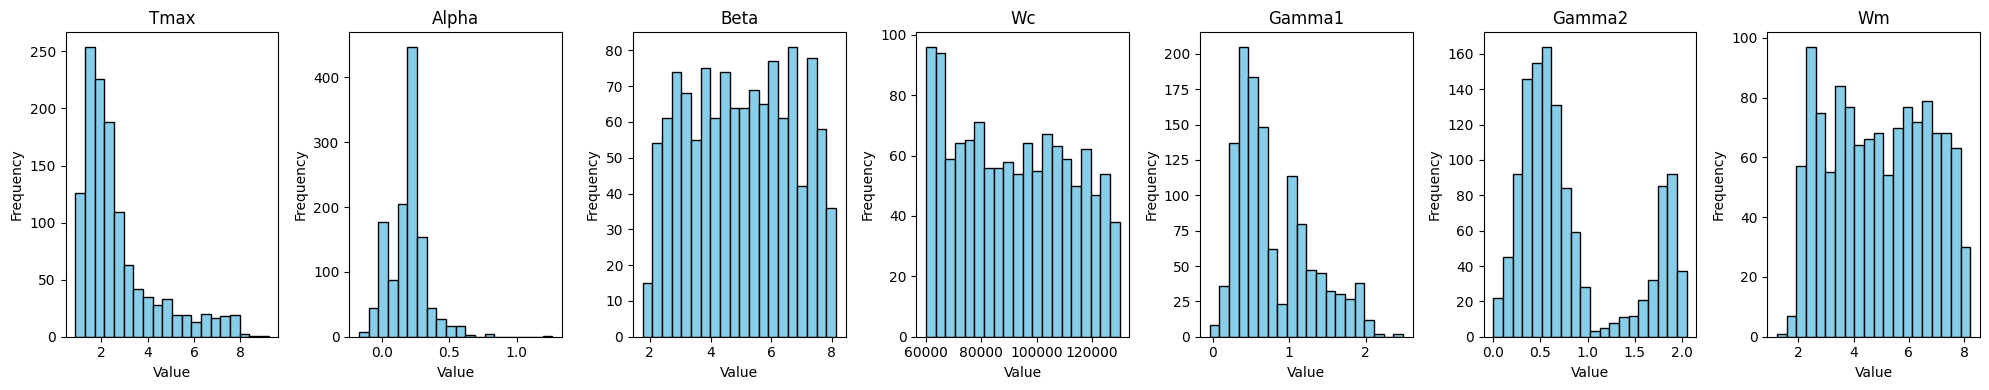

C:\Users\Pedram\AppData\Local\Temp\ipykernel_1648\985960118.py:367: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(all_params_array, labels=param_names, patch_artist=True)


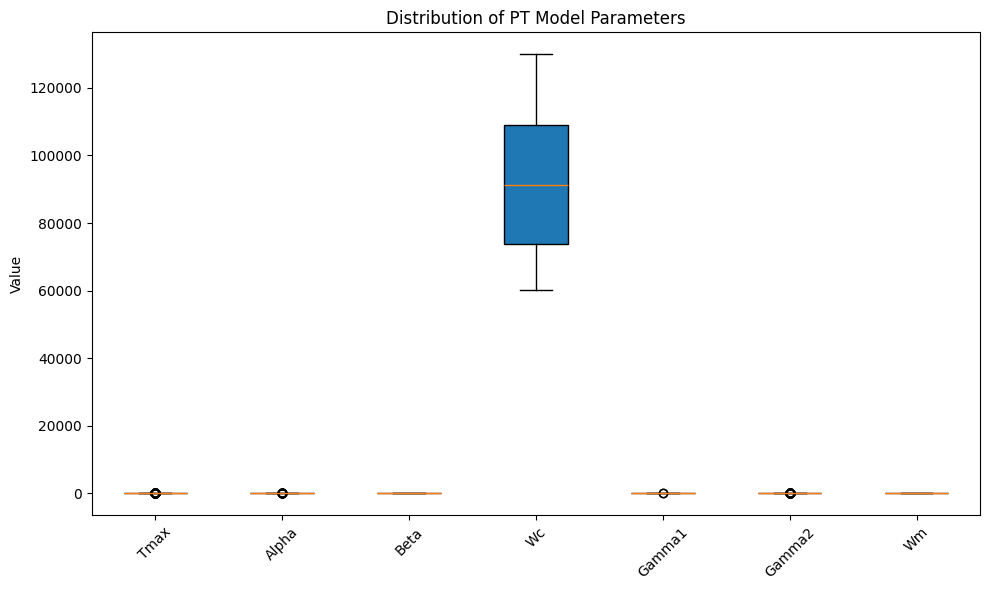

Saved results for I9094_S to C:\Users\Pedram\Desktop\PEDRAM - DO NOT TOUCH\PT_IDM\Plots\PT_I9094_S.csv
Processing Follower ID: 5366, Run Index: 1


C:\Users\Pedram\AppData\Local\Temp\ipykernel_1648\985960118.py:226: RuntimeWarning: divide by zero encountered in divide
  mape_speed = np.mean(np.abs(diff_speed / np.array(target_speed))) * 100 * weight_speed


Processing Follower ID: 286, Run Index: 3
Processing Follower ID: 195, Run Index: 2


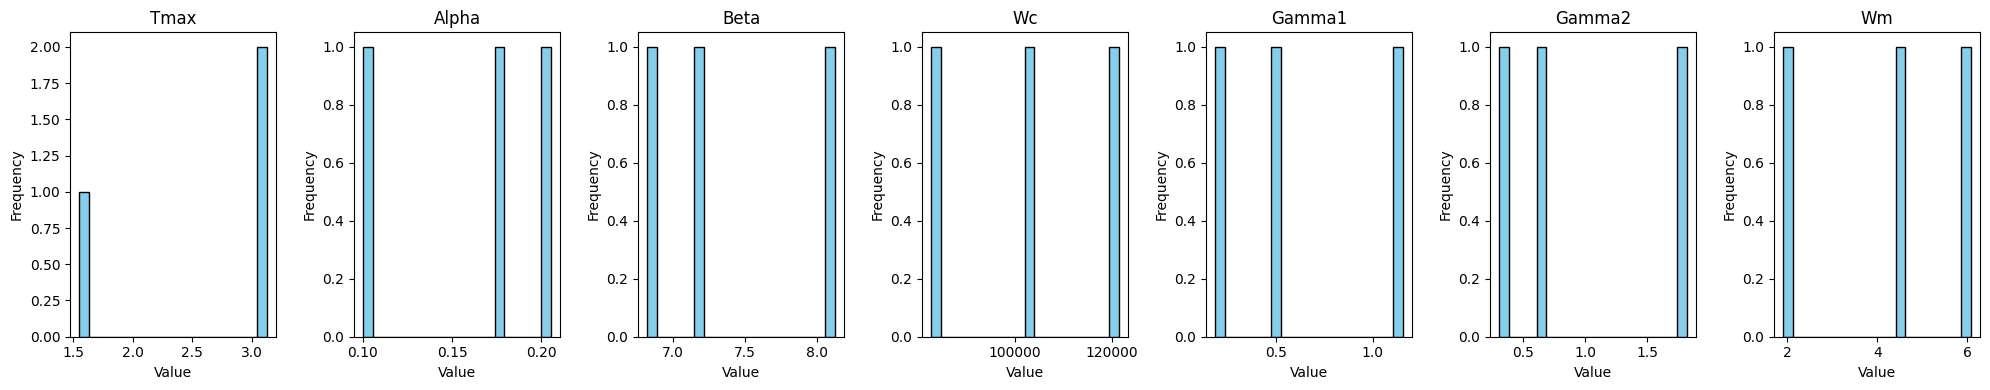

C:\Users\Pedram\AppData\Local\Temp\ipykernel_1648\985960118.py:367: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(all_params_array, labels=param_names, patch_artist=True)


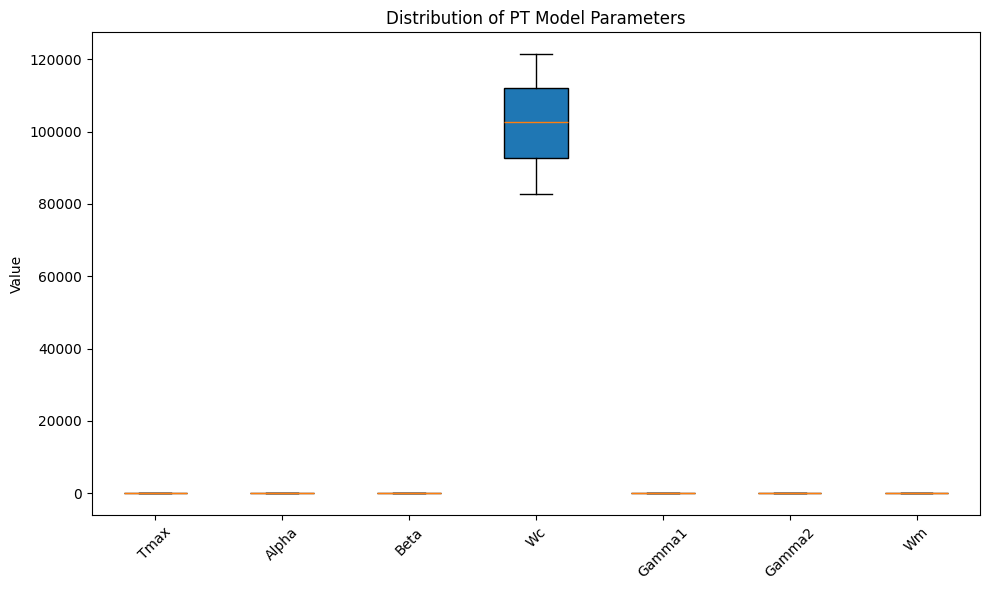

Saved results for I9094_A to C:\Users\Pedram\Desktop\PEDRAM - DO NOT TOUCH\PT_IDM\Plots\PT_I9094_A.csv
No subject data found for Follower ID 72 and Run Index 18.
Processing Follower ID: 72, Run Index: 18
No data found for Follower ID 72 and Run Index 18. Skipping...
Processing Follower ID: 55, Run Index: 20
Processing Follower ID: 28, Run Index: 3
Processing Follower ID: 34, Run Index: 19
Processing Follower ID: 7633, Run Index: 8
Processing Follower ID: 155, Run Index: 19
Processing Follower ID: 19, Run Index: 9
Processing Follower ID: 8, Run Index: 9
Processing Follower ID: 2231, Run Index: 18
No subject data found for Follower ID 99 and Run Index 8.
Processing Follower ID: 99, Run Index: 8
No data found for Follower ID 99 and Run Index 8. Skipping...
Processing Follower ID: 336, Run Index: 18
Processing Follower ID: 43, Run Index: 3
Processing Follower ID: 931, Run Index: 11
Processing Follower ID: 82, Run Index: 1
Processing Follower ID: 18, Run Index: 1
Processing Follower ID: 676

C:\Users\Pedram\AppData\Local\Temp\ipykernel_1648\985960118.py:226: RuntimeWarning: divide by zero encountered in divide
  mape_speed = np.mean(np.abs(diff_speed / np.array(target_speed))) * 100 * weight_speed


Processing Follower ID: 3147, Run Index: 8
Processing Follower ID: 539, Run Index: 8


C:\Users\Pedram\AppData\Local\Temp\ipykernel_1648\985960118.py:226: RuntimeWarning: divide by zero encountered in divide
  mape_speed = np.mean(np.abs(diff_speed / np.array(target_speed))) * 100 * weight_speed


Processing Follower ID: 2196, Run Index: 8


C:\Users\Pedram\AppData\Local\Temp\ipykernel_1648\985960118.py:226: RuntimeWarning: divide by zero encountered in divide
  mape_speed = np.mean(np.abs(diff_speed / np.array(target_speed))) * 100 * weight_speed


Processing Follower ID: 105, Run Index: 8


C:\Users\Pedram\AppData\Local\Temp\ipykernel_1648\985960118.py:226: RuntimeWarning: divide by zero encountered in divide
  mape_speed = np.mean(np.abs(diff_speed / np.array(target_speed))) * 100 * weight_speed


No subject data found for Follower ID 34 and Run Index 21.
Processing Follower ID: 34, Run Index: 21
No data found for Follower ID 34 and Run Index 21. Skipping...
Processing Follower ID: 100, Run Index: 21
Processing Follower ID: 4947, Run Index: 8
Processing Follower ID: 7203, Run Index: 8
Processing Follower ID: 5002, Run Index: 8
Processing Follower ID: 2008, Run Index: 9
Processing Follower ID: 129, Run Index: 11
Processing Follower ID: 24, Run Index: 1
Processing Follower ID: 38, Run Index: 9
Processing Follower ID: 26, Run Index: 7
Processing Follower ID: 1650, Run Index: 11
Processing Follower ID: 7, Run Index: 3
Processing Follower ID: 35, Run Index: 19


C:\Users\Pedram\AppData\Local\Temp\ipykernel_1648\985960118.py:97: RuntimeWarning: divide by zero encountered in scalar divide
  Zprime = Tau / (2.0 * Alpha * vehicle['speed']) # correct
C:\Users\Pedram\AppData\Local\Temp\ipykernel_1648\985960118.py:126: RuntimeWarning: invalid value encountered in scalar multiply
  Fprime = Uptdoubleprime - Wc * fn * (Z * math.pow(Zprime, 2.0) + Zdoubleprime)
C:\Users\Pedram\AppData\Local\Temp\ipykernel_1648\985960118.py:130: RuntimeWarning: invalid value encountered in scalar divide
  Astar = Astar - (F / Fprime)


Processing Follower ID: 13, Run Index: 19
Processing Follower ID: 6661, Run Index: 8
No subject data found for Follower ID 2578 and Run Index 11.
Processing Follower ID: 2578, Run Index: 11
No data found for Follower ID 2578 and Run Index 11. Skipping...
Processing Follower ID: 116, Run Index: 1
Processing Follower ID: 1731, Run Index: 20


C:\Users\Pedram\AppData\Local\Temp\ipykernel_1648\985960118.py:229: RuntimeWarning: invalid value encountered in scalar divide
  nrmse_position = rmse_position / (np.max(target_position) - np.min(target_position))
C:\Users\Pedram\AppData\Local\Temp\ipykernel_1648\985960118.py:230: RuntimeWarning: invalid value encountered in scalar divide
  nrmse_speed = rmse_speed / (np.max(target_speed) - np.min(target_speed))
C:\Users\Pedram\AppData\Local\Temp\ipykernel_1648\985960118.py:239: RuntimeWarning: invalid value encountered in scalar divide
  r2_position = 1 - (ss_res_position / ss_tot_position)
C:\Users\Pedram\AppData\Local\Temp\ipykernel_1648\985960118.py:243: RuntimeWarning: invalid value encountered in scalar divide
  r2_speed = 1 - (ss_res_speed / ss_tot_speed)


Processing Follower ID: 93, Run Index: 8


C:\Users\Pedram\AppData\Local\Temp\ipykernel_1648\985960118.py:226: RuntimeWarning: divide by zero encountered in divide
  mape_speed = np.mean(np.abs(diff_speed / np.array(target_speed))) * 100 * weight_speed


Processing Follower ID: 455, Run Index: 7
Processing Follower ID: 466, Run Index: 7
Processing Follower ID: 76, Run Index: 1
Processing Follower ID: 2477, Run Index: 8


C:\Users\Pedram\AppData\Local\Temp\ipykernel_1648\985960118.py:226: RuntimeWarning: divide by zero encountered in divide
  mape_speed = np.mean(np.abs(diff_speed / np.array(target_speed))) * 100 * weight_speed


Processing Follower ID: 9, Run Index: 21
Processing Follower ID: 447, Run Index: 21
Processing Follower ID: 969, Run Index: 8


C:\Users\Pedram\AppData\Local\Temp\ipykernel_1648\985960118.py:226: RuntimeWarning: divide by zero encountered in divide
  mape_speed = np.mean(np.abs(diff_speed / np.array(target_speed))) * 100 * weight_speed


Processing Follower ID: 1497, Run Index: 8


C:\Users\Pedram\AppData\Local\Temp\ipykernel_1648\985960118.py:226: RuntimeWarning: invalid value encountered in divide
  mape_speed = np.mean(np.abs(diff_speed / np.array(target_speed))) * 100 * weight_speed
C:\Users\Pedram\AppData\Local\Temp\ipykernel_1648\985960118.py:229: RuntimeWarning: invalid value encountered in scalar divide
  nrmse_position = rmse_position / (np.max(target_position) - np.min(target_position))
C:\Users\Pedram\AppData\Local\Temp\ipykernel_1648\985960118.py:230: RuntimeWarning: invalid value encountered in scalar divide
  nrmse_speed = rmse_speed / (np.max(target_speed) - np.min(target_speed))
C:\Users\Pedram\AppData\Local\Temp\ipykernel_1648\985960118.py:239: RuntimeWarning: invalid value encountered in scalar divide
  r2_position = 1 - (ss_res_position / ss_tot_position)
C:\Users\Pedram\AppData\Local\Temp\ipykernel_1648\985960118.py:243: RuntimeWarning: invalid value encountered in scalar divide
  r2_speed = 1 - (ss_res_speed / ss_tot_speed)


No subject data found for Follower ID 7323 and Run Index 8.
Processing Follower ID: 7323, Run Index: 8
No data found for Follower ID 7323 and Run Index 8. Skipping...
Processing Follower ID: 1789, Run Index: 18
Processing Follower ID: 25, Run Index: 11
No subject data found for Follower ID 341 and Run Index 21.
Processing Follower ID: 341, Run Index: 21
No data found for Follower ID 341 and Run Index 21. Skipping...
Processing Follower ID: 7695, Run Index: 8
Processing Follower ID: 2849, Run Index: 7
Processing Follower ID: 5036, Run Index: 8
Processing Follower ID: 34, Run Index: 7
Processing Follower ID: 1645, Run Index: 19
Processing Follower ID: 1802, Run Index: 18
Processing Follower ID: 1620, Run Index: 8


C:\Users\Pedram\AppData\Local\Temp\ipykernel_1648\985960118.py:226: RuntimeWarning: divide by zero encountered in divide
  mape_speed = np.mean(np.abs(diff_speed / np.array(target_speed))) * 100 * weight_speed


No subject data found for Follower ID 2925 and Run Index 11.
Processing Follower ID: 2925, Run Index: 11
No data found for Follower ID 2925 and Run Index 11. Skipping...
Processing Follower ID: 14, Run Index: 19
Processing Follower ID: 52, Run Index: 3
Processing Follower ID: 65, Run Index: 3
Processing Follower ID: 92, Run Index: 21
Processing Follower ID: 1303, Run Index: 8


C:\Users\Pedram\AppData\Local\Temp\ipykernel_1648\985960118.py:226: RuntimeWarning: divide by zero encountered in divide
  mape_speed = np.mean(np.abs(diff_speed / np.array(target_speed))) * 100 * weight_speed


Processing Follower ID: 1675, Run Index: 8


C:\Users\Pedram\AppData\Local\Temp\ipykernel_1648\985960118.py:226: RuntimeWarning: divide by zero encountered in divide
  mape_speed = np.mean(np.abs(diff_speed / np.array(target_speed))) * 100 * weight_speed


Processing Follower ID: 6561, Run Index: 8
Processing Follower ID: 43, Run Index: 9
Processing Follower ID: 7274, Run Index: 8
Processing Follower ID: 121, Run Index: 11
Processing Follower ID: 176, Run Index: 11


C:\Users\Pedram\AppData\Local\Temp\ipykernel_1648\985960118.py:230: RuntimeWarning: divide by zero encountered in scalar divide
  nrmse_speed = rmse_speed / (np.max(target_speed) - np.min(target_speed))
C:\Users\Pedram\AppData\Local\Temp\ipykernel_1648\985960118.py:243: RuntimeWarning: divide by zero encountered in scalar divide
  r2_speed = 1 - (ss_res_speed / ss_tot_speed)


Processing Follower ID: 7234, Run Index: 8
Processing Follower ID: 150, Run Index: 1
Processing Follower ID: 4681, Run Index: 8
Processing Follower ID: 18, Run Index: 7
Processing Follower ID: 7038, Run Index: 8
Processing Follower ID: 3299, Run Index: 11
Processing Follower ID: 128, Run Index: 7
Processing Follower ID: 34, Run Index: 9
Processing Follower ID: 111, Run Index: 9
Processing Follower ID: 3, Run Index: 3
Processing Follower ID: 653, Run Index: 8


C:\Users\Pedram\AppData\Local\Temp\ipykernel_1648\985960118.py:226: RuntimeWarning: divide by zero encountered in divide
  mape_speed = np.mean(np.abs(diff_speed / np.array(target_speed))) * 100 * weight_speed


Processing Follower ID: 868, Run Index: 18
Processing Follower ID: 3, Run Index: 21
Processing Follower ID: 50, Run Index: 8
Processing Follower ID: 4619, Run Index: 8
Processing Follower ID: 1504, Run Index: 18
Processing Follower ID: 3307, Run Index: 8
Processing Follower ID: 1625, Run Index: 18
Processing Follower ID: 7676, Run Index: 8
Processing Follower ID: 55, Run Index: 3
Processing Follower ID: 73, Run Index: 18
Processing Follower ID: 62, Run Index: 18
Processing Follower ID: 734, Run Index: 11
Processing Follower ID: 21, Run Index: 11
Processing Follower ID: 6872, Run Index: 8
Processing Follower ID: 151, Run Index: 1
No subject data found for Follower ID 303 and Run Index 7.
Processing Follower ID: 303, Run Index: 7
No data found for Follower ID 303 and Run Index 7. Skipping...
Processing Follower ID: 1452, Run Index: 19
Processing Follower ID: 3135, Run Index: 8
Processing Follower ID: 5998, Run Index: 8
Processing Follower ID: 3480, Run Index: 8
Processing Follower ID: 35

C:\Users\Pedram\AppData\Local\Temp\ipykernel_1648\985960118.py:226: RuntimeWarning: divide by zero encountered in divide
  mape_speed = np.mean(np.abs(diff_speed / np.array(target_speed))) * 100 * weight_speed


Processing Follower ID: 128, Run Index: 11
Processing Follower ID: 806, Run Index: 20
Processing Follower ID: 6858, Run Index: 8
Processing Follower ID: 2969, Run Index: 8


C:\Users\Pedram\AppData\Local\Temp\ipykernel_1648\985960118.py:226: RuntimeWarning: divide by zero encountered in divide
  mape_speed = np.mean(np.abs(diff_speed / np.array(target_speed))) * 100 * weight_speed


Processing Follower ID: 3099, Run Index: 11
Processing Follower ID: 118, Run Index: 9
Processing Follower ID: 603, Run Index: 11
Processing Follower ID: 2106, Run Index: 8
Processing Follower ID: 931, Run Index: 8


C:\Users\Pedram\AppData\Local\Temp\ipykernel_1648\985960118.py:226: RuntimeWarning: divide by zero encountered in divide
  mape_speed = np.mean(np.abs(diff_speed / np.array(target_speed))) * 100 * weight_speed


Processing Follower ID: 5379, Run Index: 8
Processing Follower ID: 39, Run Index: 11
Processing Follower ID: 31, Run Index: 7
Processing Follower ID: 54, Run Index: 18
Processing Follower ID: 2601, Run Index: 8


C:\Users\Pedram\AppData\Local\Temp\ipykernel_1648\985960118.py:97: RuntimeWarning: divide by zero encountered in scalar divide
  Zprime = Tau / (2.0 * Alpha * vehicle['speed']) # correct
C:\Users\Pedram\AppData\Local\Temp\ipykernel_1648\985960118.py:108: RuntimeWarning: invalid value encountered in scalar multiply
  Astar = (2.0 / Tau) * ((Seff / Tau) - vehicle['deltav'] + (Alpha * vehicle['speed'] * Zstar)) #correct
C:\Users\Pedram\AppData\Local\Temp\ipykernel_1648\985960118.py:226: RuntimeWarning: invalid value encountered in divide
  mape_speed = np.mean(np.abs(diff_speed / np.array(target_speed))) * 100 * weight_speed
C:\Users\Pedram\AppData\Local\Temp\ipykernel_1648\985960118.py:126: RuntimeWarning: invalid value encountered in scalar multiply
  Fprime = Uptdoubleprime - Wc * fn * (Z * math.pow(Zprime, 2.0) + Zdoubleprime)
C:\Users\Pedram\AppData\Local\Temp\ipykernel_1648\985960118.py:130: RuntimeWarning: invalid value encountered in scalar divide
  Astar = Astar - (F / Fprime)


Skipping Follower ID 2601, Run Index 8 due to missing optimization results.
Processing Follower ID: 1989, Run Index: 8


C:\Users\Pedram\AppData\Local\Temp\ipykernel_1648\985960118.py:226: RuntimeWarning: divide by zero encountered in divide
  mape_speed = np.mean(np.abs(diff_speed / np.array(target_speed))) * 100 * weight_speed


Processing Follower ID: 7115, Run Index: 8
Processing Follower ID: 1355, Run Index: 8


C:\Users\Pedram\AppData\Local\Temp\ipykernel_1648\985960118.py:226: RuntimeWarning: divide by zero encountered in divide
  mape_speed = np.mean(np.abs(diff_speed / np.array(target_speed))) * 100 * weight_speed


Processing Follower ID: 1380, Run Index: 7
Processing Follower ID: 52, Run Index: 20
Processing Follower ID: 108, Run Index: 19
Processing Follower ID: 1, Run Index: 11
Processing Follower ID: 202, Run Index: 1
Processing Follower ID: 16, Run Index: 9
No subject data found for Follower ID 3062 and Run Index 9.
Processing Follower ID: 3062, Run Index: 9
No data found for Follower ID 3062 and Run Index 9. Skipping...
Processing Follower ID: 1845, Run Index: 18
Processing Follower ID: 1674, Run Index: 8


C:\Users\Pedram\AppData\Local\Temp\ipykernel_1648\985960118.py:226: RuntimeWarning: divide by zero encountered in divide
  mape_speed = np.mean(np.abs(diff_speed / np.array(target_speed))) * 100 * weight_speed


Processing Follower ID: 29, Run Index: 3
No subject data found for Follower ID 1491 and Run Index 8.
Processing Follower ID: 1491, Run Index: 8
No data found for Follower ID 1491 and Run Index 8. Skipping...
Processing Follower ID: 1885, Run Index: 8


C:\Users\Pedram\AppData\Local\Temp\ipykernel_1648\985960118.py:226: RuntimeWarning: divide by zero encountered in divide
  mape_speed = np.mean(np.abs(diff_speed / np.array(target_speed))) * 100 * weight_speed


Processing Follower ID: 3234, Run Index: 11
Processing Follower ID: 2006, Run Index: 8
Processing Follower ID: 1115, Run Index: 20
Processing Follower ID: 6, Run Index: 19
No subject data found for Follower ID 412 and Run Index 21.
Processing Follower ID: 412, Run Index: 21
No data found for Follower ID 412 and Run Index 21. Skipping...
Processing Follower ID: 549, Run Index: 8


C:\Users\Pedram\AppData\Local\Temp\ipykernel_1648\985960118.py:226: RuntimeWarning: divide by zero encountered in divide
  mape_speed = np.mean(np.abs(diff_speed / np.array(target_speed))) * 100 * weight_speed


Processing Follower ID: 3305, Run Index: 7
Processing Follower ID: 14, Run Index: 11
Processing Follower ID: 7092, Run Index: 8
Processing Follower ID: 4, Run Index: 19
Processing Follower ID: 198, Run Index: 3
Processing Follower ID: 33, Run Index: 9
Processing Follower ID: 44, Run Index: 9
Processing Follower ID: 956, Run Index: 11
Processing Follower ID: 7541, Run Index: 8
Processing Follower ID: 2604, Run Index: 8


C:\Users\Pedram\AppData\Local\Temp\ipykernel_1648\985960118.py:226: RuntimeWarning: divide by zero encountered in divide
  mape_speed = np.mean(np.abs(diff_speed / np.array(target_speed))) * 100 * weight_speed


Processing Follower ID: 751, Run Index: 8
Processing Follower ID: 319, Run Index: 21
Processing Follower ID: 7796, Run Index: 8
Processing Follower ID: 7184, Run Index: 8
Processing Follower ID: 2540, Run Index: 8


C:\Users\Pedram\AppData\Local\Temp\ipykernel_1648\985960118.py:226: RuntimeWarning: divide by zero encountered in divide
  mape_speed = np.mean(np.abs(diff_speed / np.array(target_speed))) * 100 * weight_speed


Processing Follower ID: 202, Run Index: 21
Processing Follower ID: 1479, Run Index: 8


C:\Users\Pedram\AppData\Local\Temp\ipykernel_1648\985960118.py:226: RuntimeWarning: divide by zero encountered in divide
  mape_speed = np.mean(np.abs(diff_speed / np.array(target_speed))) * 100 * weight_speed


Processing Follower ID: 2698, Run Index: 9
Processing Follower ID: 2377, Run Index: 8


C:\Users\Pedram\AppData\Local\Temp\ipykernel_1648\985960118.py:226: RuntimeWarning: divide by zero encountered in divide
  mape_speed = np.mean(np.abs(diff_speed / np.array(target_speed))) * 100 * weight_speed


Processing Follower ID: 27, Run Index: 7
Processing Follower ID: 918, Run Index: 11
Processing Follower ID: 1835, Run Index: 18
Processing Follower ID: 30, Run Index: 3
Processing Follower ID: 2848, Run Index: 8


C:\Users\Pedram\AppData\Local\Temp\ipykernel_1648\985960118.py:226: RuntimeWarning: divide by zero encountered in divide
  mape_speed = np.mean(np.abs(diff_speed / np.array(target_speed))) * 100 * weight_speed


Processing Follower ID: 3335, Run Index: 7
Processing Follower ID: 125, Run Index: 21
Processing Follower ID: 7107, Run Index: 8
Processing Follower ID: 1401, Run Index: 18
Processing Follower ID: 1919, Run Index: 8


C:\Users\Pedram\AppData\Local\Temp\ipykernel_1648\985960118.py:226: RuntimeWarning: divide by zero encountered in divide
  mape_speed = np.mean(np.abs(diff_speed / np.array(target_speed))) * 100 * weight_speed


Processing Follower ID: 101, Run Index: 8


C:\Users\Pedram\AppData\Local\Temp\ipykernel_1648\985960118.py:226: RuntimeWarning: divide by zero encountered in divide
  mape_speed = np.mean(np.abs(diff_speed / np.array(target_speed))) * 100 * weight_speed


Processing Follower ID: 19, Run Index: 21
Processing Follower ID: 594, Run Index: 8
Processing Follower ID: 854, Run Index: 20
Processing Follower ID: 5403, Run Index: 8
No subject data found for Follower ID 1028 and Run Index 1.
Processing Follower ID: 1028, Run Index: 1
No data found for Follower ID 1028 and Run Index 1. Skipping...
Processing Follower ID: 29, Run Index: 7
Processing Follower ID: 63, Run Index: 18
Processing Follower ID: 2621, Run Index: 8


C:\Users\Pedram\AppData\Local\Temp\ipykernel_1648\985960118.py:226: RuntimeWarning: divide by zero encountered in divide
  mape_speed = np.mean(np.abs(diff_speed / np.array(target_speed))) * 100 * weight_speed


Processing Follower ID: 1485, Run Index: 8


C:\Users\Pedram\AppData\Local\Temp\ipykernel_1648\985960118.py:226: RuntimeWarning: divide by zero encountered in divide
  mape_speed = np.mean(np.abs(diff_speed / np.array(target_speed))) * 100 * weight_speed


Processing Follower ID: 1429, Run Index: 18
Processing Follower ID: 1953, Run Index: 3
Processing Follower ID: 10, Run Index: 11
Processing Follower ID: 3391, Run Index: 8
Processing Follower ID: 2426, Run Index: 18
Processing Follower ID: 15, Run Index: 19
Processing Follower ID: 53, Run Index: 3
Processing Follower ID: 1788, Run Index: 8


C:\Users\Pedram\AppData\Local\Temp\ipykernel_1648\985960118.py:226: RuntimeWarning: divide by zero encountered in divide
  mape_speed = np.mean(np.abs(diff_speed / np.array(target_speed))) * 100 * weight_speed


Processing Follower ID: 12, Run Index: 11
Processing Follower ID: 158, Run Index: 1
Processing Follower ID: 80, Run Index: 8


C:\Users\Pedram\AppData\Local\Temp\ipykernel_1648\985960118.py:226: RuntimeWarning: divide by zero encountered in divide
  mape_speed = np.mean(np.abs(diff_speed / np.array(target_speed))) * 100 * weight_speed


Processing Follower ID: 45, Run Index: 8
Processing Follower ID: 27, Run Index: 11
Processing Follower ID: 42, Run Index: 9
Processing Follower ID: 19, Run Index: 7
Processing Follower ID: 5342, Run Index: 8
Processing Follower ID: 374, Run Index: 9
Processing Follower ID: 0, Run Index: 21
Processing Follower ID: 123, Run Index: 9
Processing Follower ID: 15, Run Index: 3
Processing Follower ID: 564, Run Index: 8


C:\Users\Pedram\AppData\Local\Temp\ipykernel_1648\985960118.py:226: RuntimeWarning: divide by zero encountered in divide
  mape_speed = np.mean(np.abs(diff_speed / np.array(target_speed))) * 100 * weight_speed


Processing Follower ID: 946, Run Index: 18
Processing Follower ID: 1408, Run Index: 18


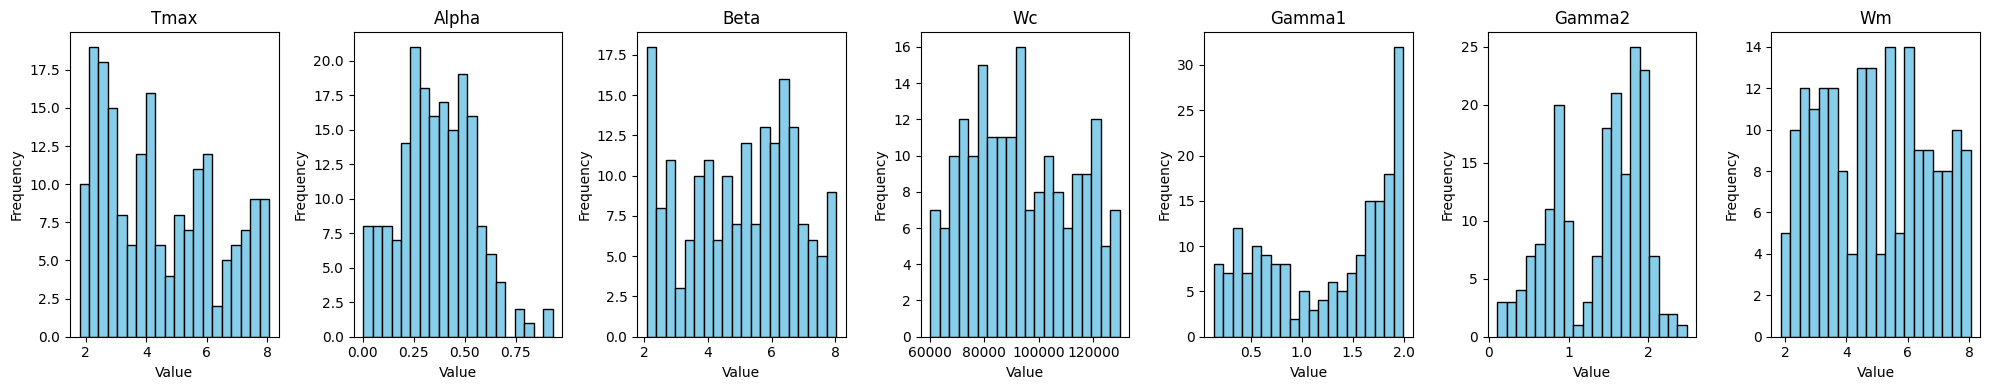

C:\Users\Pedram\AppData\Local\Temp\ipykernel_1648\985960118.py:367: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(all_params_array, labels=param_names, patch_artist=True)


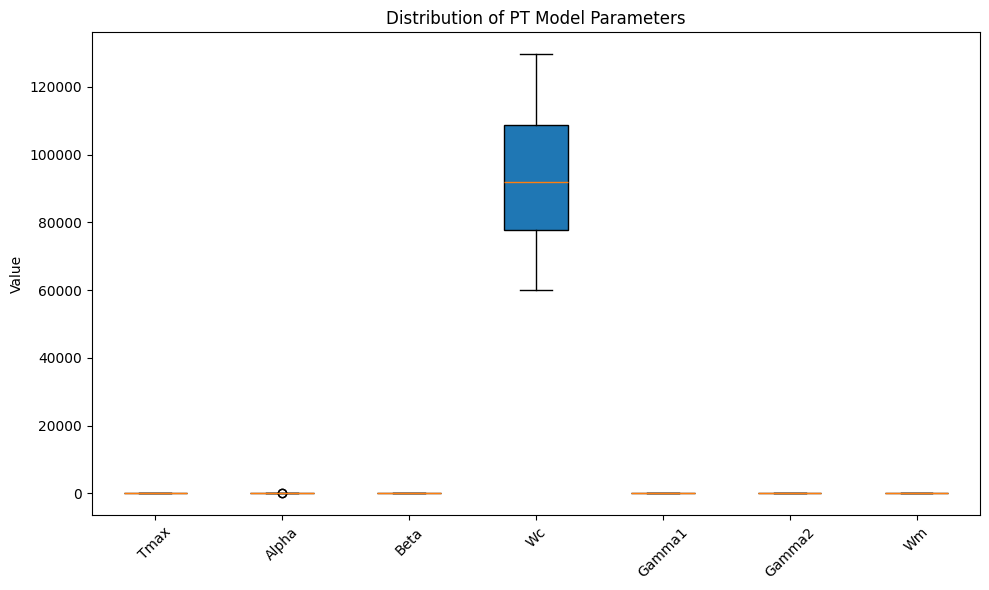

Saved results for I294l1_L to C:\Users\Pedram\Desktop\PEDRAM - DO NOT TOUCH\PT_IDM\Plots\PT_I294l1_L.csv
Processing Follower ID: 15, Run Index: 21
Processing Follower ID: 69, Run Index: 1
Processing Follower ID: 1041, Run Index: 8


C:\Users\Pedram\AppData\Local\Temp\ipykernel_1648\985960118.py:226: RuntimeWarning: divide by zero encountered in divide
  mape_speed = np.mean(np.abs(diff_speed / np.array(target_speed))) * 100 * weight_speed


No subject data found for Follower ID 2625 and Run Index 3.
Processing Follower ID: 2625, Run Index: 3
No data found for Follower ID 2625 and Run Index 3. Skipping...
Processing Follower ID: 2416, Run Index: 9
Processing Follower ID: 4404, Run Index: 8
Processing Follower ID: 2857, Run Index: 8
Processing Follower ID: 456, Run Index: 1
Processing Follower ID: 75, Run Index: 8


C:\Users\Pedram\AppData\Local\Temp\ipykernel_1648\985960118.py:226: RuntimeWarning: divide by zero encountered in divide
  mape_speed = np.mean(np.abs(diff_speed / np.array(target_speed))) * 100 * weight_speed


Processing Follower ID: 1159, Run Index: 18
Processing Follower ID: 122, Run Index: 3
Processing Follower ID: 209, Run Index: 8
Processing Follower ID: 6869, Run Index: 8


C:\Users\Pedram\AppData\Local\Temp\ipykernel_1648\985960118.py:97: RuntimeWarning: divide by zero encountered in scalar divide
  Zprime = Tau / (2.0 * Alpha * vehicle['speed']) # correct
C:\Users\Pedram\AppData\Local\Temp\ipykernel_1648\985960118.py:108: RuntimeWarning: invalid value encountered in scalar multiply
  Astar = (2.0 / Tau) * ((Seff / Tau) - vehicle['deltav'] + (Alpha * vehicle['speed'] * Zstar)) #correct
C:\Users\Pedram\AppData\Local\Temp\ipykernel_1648\985960118.py:226: RuntimeWarning: invalid value encountered in divide
  mape_speed = np.mean(np.abs(diff_speed / np.array(target_speed))) * 100 * weight_speed
C:\Users\Pedram\AppData\Local\Temp\ipykernel_1648\985960118.py:126: RuntimeWarning: invalid value encountered in scalar multiply
  Fprime = Uptdoubleprime - Wc * fn * (Z * math.pow(Zprime, 2.0) + Zdoubleprime)
C:\Users\Pedram\AppData\Local\Temp\ipykernel_1648\985960118.py:130: RuntimeWarning: invalid value encountered in scalar divide
  Astar = Astar - (F / Fprime)


Skipping Follower ID 6869, Run Index 8 due to missing optimization results.
Processing Follower ID: 6880, Run Index: 8
Processing Follower ID: 7265, Run Index: 8
Processing Follower ID: 2138, Run Index: 19


C:\Users\Pedram\AppData\Local\Temp\ipykernel_1648\985960118.py:229: RuntimeWarning: invalid value encountered in scalar divide
  nrmse_position = rmse_position / (np.max(target_position) - np.min(target_position))
C:\Users\Pedram\AppData\Local\Temp\ipykernel_1648\985960118.py:230: RuntimeWarning: invalid value encountered in scalar divide
  nrmse_speed = rmse_speed / (np.max(target_speed) - np.min(target_speed))
C:\Users\Pedram\AppData\Local\Temp\ipykernel_1648\985960118.py:239: RuntimeWarning: invalid value encountered in scalar divide
  r2_position = 1 - (ss_res_position / ss_tot_position)
C:\Users\Pedram\AppData\Local\Temp\ipykernel_1648\985960118.py:243: RuntimeWarning: invalid value encountered in scalar divide
  r2_speed = 1 - (ss_res_speed / ss_tot_speed)


Processing Follower ID: 103, Run Index: 8


C:\Users\Pedram\AppData\Local\Temp\ipykernel_1648\985960118.py:226: RuntimeWarning: divide by zero encountered in divide
  mape_speed = np.mean(np.abs(diff_speed / np.array(target_speed))) * 100 * weight_speed


Processing Follower ID: 574, Run Index: 11
Processing Follower ID: 4472, Run Index: 8
Processing Follower ID: 178, Run Index: 20
Processing Follower ID: 2523, Run Index: 9
Processing Follower ID: 56, Run Index: 3
Processing Follower ID: 45, Run Index: 3
Processing Follower ID: 34, Run Index: 3
Processing Follower ID: 117, Run Index: 19
Processing Follower ID: 128, Run Index: 19
Processing Follower ID: 893, Run Index: 11
Processing Follower ID: 497, Run Index: 11
Processing Follower ID: 7082, Run Index: 8
Processing Follower ID: 22, Run Index: 19
Processing Follower ID: 474, Run Index: 18
Processing Follower ID: 76, Run Index: 8
Processing Follower ID: 6725, Run Index: 8
Processing Follower ID: 5574, Run Index: 8
Processing Follower ID: 132, Run Index: 7
Processing Follower ID: 447, Run Index: 19
Processing Follower ID: 1743, Run Index: 19
Processing Follower ID: 15, Run Index: 7
Processing Follower ID: 49, Run Index: 9
Processing Follower ID: 1481, Run Index: 19
Processing Follower ID:

C:\Users\Pedram\AppData\Local\Temp\ipykernel_1648\985960118.py:226: RuntimeWarning: divide by zero encountered in divide
  mape_speed = np.mean(np.abs(diff_speed / np.array(target_speed))) * 100 * weight_speed


No subject data found for Follower ID 63 and Run Index 20.
Processing Follower ID: 63, Run Index: 20
No data found for Follower ID 63 and Run Index 20. Skipping...
Processing Follower ID: 626, Run Index: 8
Processing Follower ID: 2659, Run Index: 9
Processing Follower ID: 1454, Run Index: 1
Processing Follower ID: 794, Run Index: 19
Processing Follower ID: 41, Run Index: 1
Processing Follower ID: 11, Run Index: 9
Processing Follower ID: 2291, Run Index: 18
Processing Follower ID: 1884, Run Index: 18
Processing Follower ID: 7257, Run Index: 8
Processing Follower ID: 493, Run Index: 18
Processing Follower ID: 95, Run Index: 8


C:\Users\Pedram\AppData\Local\Temp\ipykernel_1648\985960118.py:226: RuntimeWarning: divide by zero encountered in divide
  mape_speed = np.mean(np.abs(diff_speed / np.array(target_speed))) * 100 * weight_speed


Processing Follower ID: 84, Run Index: 8
Processing Follower ID: 1845, Run Index: 1
Processing Follower ID: 371, Run Index: 1
Processing Follower ID: 912, Run Index: 1
Processing Follower ID: 4347, Run Index: 8


C:\Users\Pedram\AppData\Local\Temp\ipykernel_1648\985960118.py:226: RuntimeWarning: divide by zero encountered in divide
  mape_speed = np.mean(np.abs(diff_speed / np.array(target_speed))) * 100 * weight_speed


Processing Follower ID: 53, Run Index: 20
Processing Follower ID: 64, Run Index: 20
Processing Follower ID: 14, Run Index: 1
Processing Follower ID: 37, Run Index: 3
Processing Follower ID: 288, Run Index: 21
Processing Follower ID: 1169, Run Index: 8
Processing Follower ID: 2746, Run Index: 9
Processing Follower ID: 1857, Run Index: 18
Processing Follower ID: 1868, Run Index: 18
Processing Follower ID: 6968, Run Index: 8
Processing Follower ID: 2348, Run Index: 8
Processing Follower ID: 68, Run Index: 8
Processing Follower ID: 132, Run Index: 11
Processing Follower ID: 729, Run Index: 1
Processing Follower ID: 1127, Run Index: 20
Processing Follower ID: 3020, Run Index: 1
Processing Follower ID: 2841, Run Index: 8
Processing Follower ID: 6717, Run Index: 8
Processing Follower ID: 26, Run Index: 11
Processing Follower ID: 15, Run Index: 11
Processing Follower ID: 7, Run Index: 7
Processing Follower ID: 2047, Run Index: 7
Processing Follower ID: 1222, Run Index: 19
Processing Follower I

C:\Users\Pedram\AppData\Local\Temp\ipykernel_1648\985960118.py:226: RuntimeWarning: divide by zero encountered in divide
  mape_speed = np.mean(np.abs(diff_speed / np.array(target_speed))) * 100 * weight_speed


No subject data found for Follower ID 618 and Run Index 8.
Processing Follower ID: 618, Run Index: 8
No data found for Follower ID 618 and Run Index 8. Skipping...
Processing Follower ID: 931, Run Index: 1
Processing Follower ID: 1089, Run Index: 11
Processing Follower ID: 94, Run Index: 11
Processing Follower ID: 1424, Run Index: 1
Processing Follower ID: 33, Run Index: 1
No subject data found for Follower ID 1738 and Run Index 20.
Processing Follower ID: 1738, Run Index: 20
No data found for Follower ID 1738 and Run Index 20. Skipping...
Processing Follower ID: 2735, Run Index: 8


C:\Users\Pedram\AppData\Local\Temp\ipykernel_1648\985960118.py:226: RuntimeWarning: divide by zero encountered in divide
  mape_speed = np.mean(np.abs(diff_speed / np.array(target_speed))) * 100 * weight_speed


Processing Follower ID: 1990, Run Index: 3
Processing Follower ID: 33, Run Index: 19
Processing Follower ID: 2484, Run Index: 8
Processing Follower ID: 2021, Run Index: 18
Processing Follower ID: 786, Run Index: 9
Processing Follower ID: 748, Run Index: 1
No subject data found for Follower ID 839 and Run Index 21.
Processing Follower ID: 839, Run Index: 21
No data found for Follower ID 839 and Run Index 21. Skipping...
Processing Follower ID: 1051, Run Index: 11
Processing Follower ID: 203, Run Index: 21
Processing Follower ID: 34, Run Index: 11
Processing Follower ID: 1386, Run Index: 1
Processing Follower ID: 56, Run Index: 20
Processing Follower ID: 86, Run Index: 21
Processing Follower ID: 163, Run Index: 3
No subject data found for Follower ID 1450 and Run Index 3.
Processing Follower ID: 1450, Run Index: 3
No data found for Follower ID 1450 and Run Index 3. Skipping...
Processing Follower ID: 397, Run Index: 8
Processing Follower ID: 949, Run Index: 8


C:\Users\Pedram\AppData\Local\Temp\ipykernel_1648\985960118.py:226: RuntimeWarning: divide by zero encountered in divide
  mape_speed = np.mean(np.abs(diff_speed / np.array(target_speed))) * 100 * weight_speed


Processing Follower ID: 7202, Run Index: 8
No subject data found for Follower ID 79 and Run Index 18.
Processing Follower ID: 79, Run Index: 18
No data found for Follower ID 79 and Run Index 18. Skipping...
Processing Follower ID: 154, Run Index: 21
Processing Follower ID: 7, Run Index: 11
Processing Follower ID: 18, Run Index: 11
Processing Follower ID: 4041, Run Index: 8
Processing Follower ID: 41, Run Index: 9
Processing Follower ID: 52, Run Index: 9
Processing Follower ID: 1644, Run Index: 8
Processing Follower ID: 10, Run Index: 3
Processing Follower ID: 2040, Run Index: 8
Processing Follower ID: 6660, Run Index: 8
Processing Follower ID: 7153, Run Index: 8
Processing Follower ID: 7560, Run Index: 8
Processing Follower ID: 964, Run Index: 20
Processing Follower ID: 159, Run Index: 1
Processing Follower ID: 10, Run Index: 21
No subject data found for Follower ID 66 and Run Index 20.
Processing Follower ID: 66, Run Index: 20
No data found for Follower ID 66 and Run Index 20. Skippin

C:\Users\Pedram\AppData\Local\Temp\ipykernel_1648\985960118.py:226: RuntimeWarning: divide by zero encountered in divide
  mape_speed = np.mean(np.abs(diff_speed / np.array(target_speed))) * 100 * weight_speed


No subject data found for Follower ID 811 and Run Index 20.
Processing Follower ID: 811, Run Index: 20
No data found for Follower ID 811 and Run Index 20. Skipping...
Processing Follower ID: 2362, Run Index: 18
Processing Follower ID: 71, Run Index: 18
Processing Follower ID: 112, Run Index: 19
Processing Follower ID: 146, Run Index: 21
Processing Follower ID: 531, Run Index: 21
Processing Follower ID: 1704, Run Index: 18
Processing Follower ID: 29, Run Index: 21
Processing Follower ID: 60, Run Index: 8
Processing Follower ID: 523, Run Index: 7
Processing Follower ID: 1382, Run Index: 3
Processing Follower ID: 10, Run Index: 7
Processing Follower ID: 359, Run Index: 21
Processing Follower ID: 2, Run Index: 3
Processing Follower ID: 2851, Run Index: 11
Processing Follower ID: 108, Run Index: 21
Processing Follower ID: 1666, Run Index: 18
Processing Follower ID: 2670, Run Index: 8
Processing Follower ID: 1700, Run Index: 20
Processing Follower ID: 454, Run Index: 11
Processing Follower I

C:\Users\Pedram\AppData\Local\Temp\ipykernel_1648\985960118.py:226: RuntimeWarning: divide by zero encountered in divide
  mape_speed = np.mean(np.abs(diff_speed / np.array(target_speed))) * 100 * weight_speed


Processing Follower ID: 90, Run Index: 8
Processing Follower ID: 1567, Run Index: 20
Processing Follower ID: 1286, Run Index: 7
No subject data found for Follower ID 146 and Run Index 7.
Processing Follower ID: 146, Run Index: 7
No data found for Follower ID 146 and Run Index 7. Skipping...
Processing Follower ID: 1808, Run Index: 3
Processing Follower ID: 249, Run Index: 1
Processing Follower ID: 1506, Run Index: 19
Processing Follower ID: 21, Run Index: 3
Processing Follower ID: 115, Run Index: 19
Processing Follower ID: 104, Run Index: 19
Processing Follower ID: 143, Run Index: 1
Processing Follower ID: 1707, Run Index: 18
Processing Follower ID: 1841, Run Index: 18
Processing Follower ID: 2449, Run Index: 8
Processing Follower ID: 21, Run Index: 21
Processing Follower ID: 60, Run Index: 3
Processing Follower ID: 305, Run Index: 18
Processing Follower ID: 5416, Run Index: 8
Processing Follower ID: 127, Run Index: 11
Processing Follower ID: 6712, Run Index: 8
Processing Follower ID: 

C:\Users\Pedram\AppData\Local\Temp\ipykernel_1648\985960118.py:226: RuntimeWarning: divide by zero encountered in divide
  mape_speed = np.mean(np.abs(diff_speed / np.array(target_speed))) * 100 * weight_speed


Processing Follower ID: 2015, Run Index: 8
Processing Follower ID: 1020, Run Index: 8


C:\Users\Pedram\AppData\Local\Temp\ipykernel_1648\985960118.py:226: RuntimeWarning: divide by zero encountered in divide
  mape_speed = np.mean(np.abs(diff_speed / np.array(target_speed))) * 100 * weight_speed


Processing Follower ID: 6925, Run Index: 8
Processing Follower ID: 1761, Run Index: 21
No subject data found for Follower ID 7407 and Run Index 8.
Processing Follower ID: 7407, Run Index: 8
No data found for Follower ID 7407 and Run Index 8. Skipping...
Processing Follower ID: 978, Run Index: 11
Processing Follower ID: 55, Run Index: 18
Processing Follower ID: 28, Run Index: 1
Processing Follower ID: 17, Run Index: 1
Processing Follower ID: 2133, Run Index: 18
Processing Follower ID: 1168, Run Index: 19
Processing Follower ID: 28, Run Index: 19
Processing Follower ID: 17, Run Index: 19
Processing Follower ID: 1631, Run Index: 18
Processing Follower ID: 2068, Run Index: 19
Processing Follower ID: 3296, Run Index: 1
Processing Follower ID: 2027, Run Index: 18
Processing Follower ID: 6731, Run Index: 8


C:\Users\Pedram\AppData\Local\Temp\ipykernel_1648\985960118.py:226: RuntimeWarning: divide by zero encountered in divide
  mape_speed = np.mean(np.abs(diff_speed / np.array(target_speed))) * 100 * weight_speed


Processing Follower ID: 492, Run Index: 1
Processing Follower ID: 29, Run Index: 11
Processing Follower ID: 40, Run Index: 11
Processing Follower ID: 241, Run Index: 1
Processing Follower ID: 21, Run Index: 7
Processing Follower ID: 1161, Run Index: 7
Processing Follower ID: 477, Run Index: 21
Processing Follower ID: 5967, Run Index: 8
Processing Follower ID: 2449, Run Index: 3
Processing Follower ID: 6799, Run Index: 8
Processing Follower ID: 1186, Run Index: 18
Processing Follower ID: 788, Run Index: 8
Processing Follower ID: 108, Run Index: 11
Processing Follower ID: 785, Run Index: 21
Processing Follower ID: 389, Run Index: 21
Processing Follower ID: 32, Run Index: 3
Processing Follower ID: 986, Run Index: 11
Processing Follower ID: 1008, Run Index: 11
Processing Follower ID: 138, Run Index: 21
No subject data found for Follower ID 2 and Run Index 11.
Processing Follower ID: 2, Run Index: 11
No data found for Follower ID 2 and Run Index 11. Skipping...
Processing Follower ID: 537, 

C:\Users\Pedram\AppData\Local\Temp\ipykernel_1648\985960118.py:226: RuntimeWarning: divide by zero encountered in divide
  mape_speed = np.mean(np.abs(diff_speed / np.array(target_speed))) * 100 * weight_speed


Processing Follower ID: 294, Run Index: 21
Processing Follower ID: 727, Run Index: 7
Processing Follower ID: 534, Run Index: 21
Processing Follower ID: 7080, Run Index: 8
Processing Follower ID: 43, Run Index: 21
Processing Follower ID: 640, Run Index: 11
Processing Follower ID: 86, Run Index: 1
Processing Follower ID: 936, Run Index: 19
Processing Follower ID: 2247, Run Index: 8
Processing Follower ID: 515, Run Index: 7
Processing Follower ID: 153, Run Index: 9
Processing Follower ID: 36, Run Index: 9
Processing Follower ID: 47, Run Index: 9
Processing Follower ID: 362, Run Index: 21
Processing Follower ID: 5, Run Index: 3
Processing Follower ID: 488, Run Index: 8


C:\Users\Pedram\AppData\Local\Temp\ipykernel_1648\985960118.py:226: RuntimeWarning: divide by zero encountered in divide
  mape_speed = np.mean(np.abs(diff_speed / np.array(target_speed))) * 100 * weight_speed


Processing Follower ID: 5253, Run Index: 8
Processing Follower ID: 1714, Run Index: 20
Processing Follower ID: 245, Run Index: 21
Processing Follower ID: 6131, Run Index: 8
Processing Follower ID: 6886, Run Index: 8
Processing Follower ID: 5, Run Index: 21
Processing Follower ID: 9, Run Index: 19
Processing Follower ID: 575, Run Index: 3
Processing Follower ID: 3483, Run Index: 8
Processing Follower ID: 1506, Run Index: 18
Processing Follower ID: 62, Run Index: 3
Processing Follower ID: 575, Run Index: 21
Processing Follower ID: 712, Run Index: 8


C:\Users\Pedram\AppData\Local\Temp\ipykernel_1648\985960118.py:226: RuntimeWarning: divide by zero encountered in divide
  mape_speed = np.mean(np.abs(diff_speed / np.array(target_speed))) * 100 * weight_speed


Processing Follower ID: 54, Run Index: 8
Processing Follower ID: 7244, Run Index: 8
Processing Follower ID: 105, Run Index: 1
Processing Follower ID: 408, Run Index: 11
Processing Follower ID: 534, Run Index: 7
Processing Follower ID: 160, Run Index: 7
Processing Follower ID: 586, Run Index: 8
Processing Follower ID: 168, Run Index: 20
Processing Follower ID: 1604, Run Index: 19
Processing Follower ID: 1323, Run Index: 18
Processing Follower ID: 32, Run Index: 7
Processing Follower ID: 51, Run Index: 20
Processing Follower ID: 35, Run Index: 3
Processing Follower ID: 24, Run Index: 3
No subject data found for Follower ID 66 and Run Index 18.
Processing Follower ID: 66, Run Index: 18
No data found for Follower ID 66 and Run Index 18. Skipping...
Processing Follower ID: 96, Run Index: 19
No subject data found for Follower ID 222 and Run Index 9.
Processing Follower ID: 222, Run Index: 9
No data found for Follower ID 222 and Run Index 9. Skipping...
Processing Follower ID: 537, Run Index:

C:\Users\Pedram\AppData\Local\Temp\ipykernel_1648\985960118.py:226: RuntimeWarning: divide by zero encountered in divide
  mape_speed = np.mean(np.abs(diff_speed / np.array(target_speed))) * 100 * weight_speed


Processing Follower ID: 6783, Run Index: 8


C:\Users\Pedram\AppData\Local\Temp\ipykernel_1648\985960118.py:226: RuntimeWarning: divide by zero encountered in divide
  mape_speed = np.mean(np.abs(diff_speed / np.array(target_speed))) * 100 * weight_speed


Processing Follower ID: 42, Run Index: 20
No subject data found for Follower ID 1734 and Run Index 20.
Processing Follower ID: 1734, Run Index: 20
No data found for Follower ID 1734 and Run Index 20. Skipping...
Processing Follower ID: 624, Run Index: 21
Processing Follower ID: 373, Run Index: 21
Processing Follower ID: 1487, Run Index: 18
Processing Follower ID: 20, Run Index: 1
Processing Follower ID: 54, Run Index: 3
Processing Follower ID: 122, Run Index: 21
Processing Follower ID: 199, Run Index: 3
Processing Follower ID: 207, Run Index: 7
Processing Follower ID: 20, Run Index: 19
Processing Follower ID: 54, Run Index: 21
Processing Follower ID: 31, Run Index: 19
Processing Follower ID: 920, Run Index: 19
Processing Follower ID: 809, Run Index: 21
Processing Follower ID: 6600, Run Index: 8
Processing Follower ID: 74, Run Index: 8


C:\Users\Pedram\AppData\Local\Temp\ipykernel_1648\985960118.py:226: RuntimeWarning: divide by zero encountered in divide
  mape_speed = np.mean(np.abs(diff_speed / np.array(target_speed))) * 100 * weight_speed


Processing Follower ID: 85, Run Index: 8


C:\Users\Pedram\AppData\Local\Temp\ipykernel_1648\985960118.py:226: RuntimeWarning: divide by zero encountered in divide
  mape_speed = np.mean(np.abs(diff_speed / np.array(target_speed))) * 100 * weight_speed


Processing Follower ID: 138, Run Index: 11
Processing Follower ID: 818, Run Index: 8


C:\Users\Pedram\AppData\Local\Temp\ipykernel_1648\985960118.py:226: RuntimeWarning: divide by zero encountered in divide
  mape_speed = np.mean(np.abs(diff_speed / np.array(target_speed))) * 100 * weight_speed


Processing Follower ID: 567, Run Index: 8
Processing Follower ID: 893, Run Index: 20
Processing Follower ID: 32, Run Index: 11
Processing Follower ID: 13, Run Index: 7
Processing Follower ID: 24, Run Index: 7
Processing Follower ID: 43, Run Index: 20
Processing Follower ID: 16, Run Index: 21
Processing Follower ID: 1764, Run Index: 11
Processing Follower ID: 6685, Run Index: 8
Processing Follower ID: 7440, Run Index: 8
Processing Follower ID: 540, Run Index: 8


C:\Users\Pedram\AppData\Local\Temp\ipykernel_1648\985960118.py:226: RuntimeWarning: divide by zero encountered in divide
  mape_speed = np.mean(np.abs(diff_speed / np.array(target_speed))) * 100 * weight_speed


Processing Follower ID: 111, Run Index: 20
Processing Follower ID: 61, Run Index: 1
No subject data found for Follower ID 5 and Run Index 11.
Processing Follower ID: 5, Run Index: 11
No data found for Follower ID 5 and Run Index 11. Skipping...
Processing Follower ID: 152, Run Index: 21
Processing Follower ID: 5188, Run Index: 8
Processing Follower ID: 206, Run Index: 19
Processing Follower ID: 1622, Run Index: 21
Processing Follower ID: 1654, Run Index: 1
Processing Follower ID: 5362, Run Index: 8


C:\Users\Pedram\AppData\Local\Temp\ipykernel_1648\985960118.py:229: RuntimeWarning: invalid value encountered in scalar divide
  nrmse_position = rmse_position / (np.max(target_position) - np.min(target_position))
C:\Users\Pedram\AppData\Local\Temp\ipykernel_1648\985960118.py:230: RuntimeWarning: invalid value encountered in scalar divide
  nrmse_speed = rmse_speed / (np.max(target_speed) - np.min(target_speed))
C:\Users\Pedram\AppData\Local\Temp\ipykernel_1648\985960118.py:239: RuntimeWarning: invalid value encountered in scalar divide
  r2_position = 1 - (ss_res_position / ss_tot_position)
C:\Users\Pedram\AppData\Local\Temp\ipykernel_1648\985960118.py:243: RuntimeWarning: invalid value encountered in scalar divide
  r2_speed = 1 - (ss_res_speed / ss_tot_speed)


Processing Follower ID: 742, Run Index: 8


C:\Users\Pedram\AppData\Local\Temp\ipykernel_1648\985960118.py:226: RuntimeWarning: divide by zero encountered in divide
  mape_speed = np.mean(np.abs(diff_speed / np.array(target_speed))) * 100 * weight_speed


Processing Follower ID: 2326, Run Index: 3
Processing Follower ID: 23, Run Index: 1
Processing Follower ID: 1604, Run Index: 9
Processing Follower ID: 23, Run Index: 19
Processing Follower ID: 12, Run Index: 19
Processing Follower ID: 1961, Run Index: 8
Processing Follower ID: 107, Run Index: 9
Processing Follower ID: 1562, Run Index: 21
Processing Follower ID: 2159, Run Index: 11
Processing Follower ID: 2398, Run Index: 18
Processing Follower ID: 96, Run Index: 18
Processing Follower ID: 1407, Run Index: 7
Processing Follower ID: 13, Run Index: 11
Processing Follower ID: 24, Run Index: 11
Processing Follower ID: 632, Run Index: 1
Processing Follower ID: 16, Run Index: 7
Processing Follower ID: 57, Run Index: 8


C:\Users\Pedram\AppData\Local\Temp\ipykernel_1648\985960118.py:226: RuntimeWarning: divide by zero encountered in divide
  mape_speed = np.mean(np.abs(diff_speed / np.array(target_speed))) * 100 * weight_speed


Processing Follower ID: 46, Run Index: 8
Processing Follower ID: 2064, Run Index: 11
Processing Follower ID: 2079, Run Index: 18
Processing Follower ID: 571, Run Index: 9
Processing Follower ID: 250, Run Index: 21
Processing Follower ID: 27, Run Index: 3
Processing Follower ID: 510, Run Index: 8
Processing Follower ID: 69, Run Index: 18
Processing Follower ID: 1284, Run Index: 21
Processing Follower ID: 278, Run Index: 21
Processing Follower ID: 875, Run Index: 11
Processing Follower ID: 19, Run Index: 8


C:\Users\Pedram\AppData\Local\Temp\ipykernel_1648\985960118.py:226: RuntimeWarning: divide by zero encountered in divide
  mape_speed = np.mean(np.abs(diff_speed / np.array(target_speed))) * 100 * weight_speed


Processing Follower ID: 1999, Run Index: 3
Processing Follower ID: 228, Run Index: 20
Processing Follower ID: 3698, Run Index: 8
Processing Follower ID: 4020, Run Index: 8
Processing Follower ID: 240, Run Index: 3
Processing Follower ID: 31, Run Index: 9
Processing Follower ID: 20, Run Index: 9
Processing Follower ID: 2931, Run Index: 1
Processing Follower ID: 2177, Run Index: 18
Processing Follower ID: 87, Run Index: 8


C:\Users\Pedram\AppData\Local\Temp\ipykernel_1648\985960118.py:226: RuntimeWarning: divide by zero encountered in divide
  mape_speed = np.mean(np.abs(diff_speed / np.array(target_speed))) * 100 * weight_speed


Processing Follower ID: 786, Run Index: 18
No subject data found for Follower ID 149 and Run Index 1.
Processing Follower ID: 149, Run Index: 1
No data found for Follower ID 149 and Run Index 1. Skipping...
Processing Follower ID: 4746, Run Index: 8
Processing Follower ID: 2881, Run Index: 9
Processing Follower ID: 6031, Run Index: 8
Processing Follower ID: 45, Run Index: 20
Processing Follower ID: 1752, Run Index: 18
Processing Follower ID: 76, Run Index: 7
Processing Follower ID: 810, Run Index: 21
Processing Follower ID: 1501, Run Index: 18
Processing Follower ID: 57, Run Index: 3
Processing Follower ID: 46, Run Index: 3
Processing Follower ID: 88, Run Index: 18
Processing Follower ID: 140, Run Index: 19
Processing Follower ID: 2296, Run Index: 11
No subject data found for Follower ID 2508 and Run Index 1.
Processing Follower ID: 2508, Run Index: 1
No data found for Follower ID 2508 and Run Index 1. Skipping...
Processing Follower ID: 1836, Run Index: 8
Processing Follower ID: 916, 

C:\Users\Pedram\AppData\Local\Temp\ipykernel_1648\985960118.py:226: RuntimeWarning: divide by zero encountered in divide
  mape_speed = np.mean(np.abs(diff_speed / np.array(target_speed))) * 100 * weight_speed


Processing Follower ID: 7056, Run Index: 8
Processing Follower ID: 8, Run Index: 21
Processing Follower ID: 30, Run Index: 21
Processing Follower ID: 145, Run Index: 8


C:\Users\Pedram\AppData\Local\Temp\ipykernel_1648\985960118.py:226: RuntimeWarning: divide by zero encountered in divide
  mape_speed = np.mean(np.abs(diff_speed / np.array(target_speed))) * 100 * weight_speed


No subject data found for Follower ID 62 and Run Index 1.
Processing Follower ID: 62, Run Index: 1
No data found for Follower ID 62 and Run Index 1. Skipping...
Processing Follower ID: 6805, Run Index: 8
Processing Follower ID: 6816, Run Index: 8


C:\Users\Pedram\AppData\Local\Temp\ipykernel_1648\985960118.py:226: RuntimeWarning: divide by zero encountered in divide
  mape_speed = np.mean(np.abs(diff_speed / np.array(target_speed))) * 100 * weight_speed


Processing Follower ID: 7067, Run Index: 8
Processing Follower ID: 114, Run Index: 11
Processing Follower ID: 304, Run Index: 1
Processing Follower ID: 421, Run Index: 19
Processing Follower ID: 23, Run Index: 9
Processing Follower ID: 12, Run Index: 9
No subject data found for Follower ID 1623 and Run Index 21.
Processing Follower ID: 1623, Run Index: 21
No data found for Follower ID 1623 and Run Index 21. Skipping...
Processing Follower ID: 1918, Run Index: 18
Processing Follower ID: 7124, Run Index: 8
Processing Follower ID: 7269, Run Index: 8
Processing Follower ID: 1667, Run Index: 18
Processing Follower ID: 130, Run Index: 1
Processing Follower ID: 422, Run Index: 11
Processing Follower ID: 1718, Run Index: 20
No subject data found for Follower ID 65 and Run Index 20.
Processing Follower ID: 65, Run Index: 20
No data found for Follower ID 65 and Run Index 20. Skipping...
Processing Follower ID: 15, Run Index: 1
Processing Follower ID: 49, Run Index: 3
Processing Follower ID: 38, 

C:\Users\Pedram\AppData\Local\Temp\ipykernel_1648\985960118.py:226: RuntimeWarning: divide by zero encountered in divide
  mape_speed = np.mean(np.abs(diff_speed / np.array(target_speed))) * 100 * weight_speed


Processing Follower ID: 58, Run Index: 8
Processing Follower ID: 1022, Run Index: 11
Processing Follower ID: 585, Run Index: 19
Processing Follower ID: 8, Run Index: 7
Processing Follower ID: 30, Run Index: 7
Processing Follower ID: 11, Run Index: 3
Processing Follower ID: 0, Run Index: 3
Processing Follower ID: 479, Run Index: 19
Processing Follower ID: 1664, Run Index: 21
Processing Follower ID: 7048, Run Index: 8
Processing Follower ID: 493, Run Index: 21
Processing Follower ID: 6931, Run Index: 8
Processing Follower ID: 1623, Run Index: 7
Processing Follower ID: 2378, Run Index: 7
Processing Follower ID: 84, Run Index: 20
Processing Follower ID: 56, Run Index: 1
Processing Follower ID: 232, Run Index: 7
Processing Follower ID: 118, Run Index: 3
Processing Follower ID: 2033, Run Index: 18
Processing Follower ID: 1648, Run Index: 18
Processing Follower ID: 2245, Run Index: 8
Processing Follower ID: 2390, Run Index: 8
Processing Follower ID: 1983, Run Index: 8
No subject data found fo

C:\Users\Pedram\AppData\Local\Temp\ipykernel_1648\985960118.py:226: RuntimeWarning: divide by zero encountered in divide
  mape_speed = np.mean(np.abs(diff_speed / np.array(target_speed))) * 100 * weight_speed


Processing Follower ID: 113, Run Index: 19
Processing Follower ID: 2698, Run Index: 8
Processing Follower ID: 7, Run Index: 19
No subject data found for Follower ID 1610 and Run Index 18.
Processing Follower ID: 1610, Run Index: 18
No data found for Follower ID 1610 and Run Index 18. Skipping...
Processing Follower ID: 152, Run Index: 19
Processing Follower ID: 6972, Run Index: 8
Processing Follower ID: 1956, Run Index: 8


C:\Users\Pedram\AppData\Local\Temp\ipykernel_1648\985960118.py:226: RuntimeWarning: divide by zero encountered in divide
  mape_speed = np.mean(np.abs(diff_speed / np.array(target_speed))) * 100 * weight_speed


Processing Follower ID: 125, Run Index: 11
Processing Follower ID: 2090, Run Index: 8
Processing Follower ID: 6710, Run Index: 8


C:\Users\Pedram\AppData\Local\Temp\ipykernel_1648\985960118.py:226: RuntimeWarning: divide by zero encountered in divide
  mape_speed = np.mean(np.abs(diff_speed / np.array(target_speed))) * 100 * weight_speed


Processing Follower ID: 2389, Run Index: 3
Processing Follower ID: 75, Run Index: 1
Processing Follower ID: 30, Run Index: 11
Processing Follower ID: 8, Run Index: 11
Processing Follower ID: 311, Run Index: 21
Processing Follower ID: 0, Run Index: 7
Processing Follower ID: 52, Run Index: 8


C:\Users\Pedram\AppData\Local\Temp\ipykernel_1648\985960118.py:226: RuntimeWarning: divide by zero encountered in divide
  mape_speed = np.mean(np.abs(diff_speed / np.array(target_speed))) * 100 * weight_speed


Processing Follower ID: 763, Run Index: 20
Processing Follower ID: 197, Run Index: 8


C:\Users\Pedram\AppData\Local\Temp\ipykernel_1648\985960118.py:226: RuntimeWarning: divide by zero encountered in divide
  mape_speed = np.mean(np.abs(diff_speed / np.array(target_speed))) * 100 * weight_speed


Processing Follower ID: 114, Run Index: 1
Processing Follower ID: 234, Run Index: 21
Processing Follower ID: 22, Run Index: 3
Processing Follower ID: 53, Run Index: 18
Processing Follower ID: 128, Run Index: 21
No subject data found for Follower ID 1720 and Run Index 20.
Processing Follower ID: 1720, Run Index: 20
No data found for Follower ID 1720 and Run Index 20. Skipping...
Processing Follower ID: 3, Run Index: 8


C:\Users\Pedram\AppData\Local\Temp\ipykernel_1648\985960118.py:226: RuntimeWarning: divide by zero encountered in divide
  mape_speed = np.mean(np.abs(diff_speed / np.array(target_speed))) * 100 * weight_speed


Processing Follower ID: 288, Run Index: 19
Processing Follower ID: 6808, Run Index: 8


C:\Users\Pedram\AppData\Local\Temp\ipykernel_1648\985960118.py:226: RuntimeWarning: divide by zero encountered in divide
  mape_speed = np.mean(np.abs(diff_speed / np.array(target_speed))) * 100 * weight_speed


Processing Follower ID: 65, Run Index: 1
Processing Follower ID: 5668, Run Index: 8
Processing Follower ID: 3283, Run Index: 1
Processing Follower ID: 3346, Run Index: 11
Processing Follower ID: 15, Run Index: 9
Processing Follower ID: 26, Run Index: 9
Processing Follower ID: 38, Run Index: 11
Processing Follower ID: 82, Run Index: 8


C:\Users\Pedram\AppData\Local\Temp\ipykernel_1648\985960118.py:226: RuntimeWarning: divide by zero encountered in divide
  mape_speed = np.mean(np.abs(diff_speed / np.array(target_speed))) * 100 * weight_speed


Processing Follower ID: 71, Run Index: 8
Processing Follower ID: 531, Run Index: 11
Processing Follower ID: 144, Run Index: 1
Processing Follower ID: 728, Run Index: 21
Processing Follower ID: 2876, Run Index: 9
Processing Follower ID: 40, Run Index: 20
Processing Follower ID: 177, Run Index: 7
Processing Follower ID: 942, Run Index: 8


C:\Users\Pedram\AppData\Local\Temp\ipykernel_1648\985960118.py:226: RuntimeWarning: divide by zero encountered in divide
  mape_speed = np.mean(np.abs(diff_speed / np.array(target_speed))) * 100 * weight_speed


Processing Follower ID: 1967, Run Index: 18
Processing Follower ID: 1978, Run Index: 18
Processing Follower ID: 6440, Run Index: 8


C:\Users\Pedram\AppData\Local\Temp\ipykernel_1648\985960118.py:226: RuntimeWarning: divide by zero encountered in divide
  mape_speed = np.mean(np.abs(diff_speed / np.array(target_speed))) * 100 * weight_speed


Processing Follower ID: 284, Run Index: 8


C:\Users\Pedram\AppData\Local\Temp\ipykernel_1648\985960118.py:226: RuntimeWarning: divide by zero encountered in divide
  mape_speed = np.mean(np.abs(diff_speed / np.array(target_speed))) * 100 * weight_speed


Processing Follower ID: 7340, Run Index: 8
Processing Follower ID: 7100, Run Index: 8
Processing Follower ID: 2150, Run Index: 8
Processing Follower ID: 136, Run Index: 20
Processing Follower ID: 120, Run Index: 3
Processing Follower ID: 3050, Run Index: 8
Processing Follower ID: 1366, Run Index: 21
Processing Follower ID: 45, Run Index: 9
Processing Follower ID: 22, Run Index: 7
Processing Follower ID: 7564, Run Index: 8
Processing Follower ID: 1565, Run Index: 1
Processing Follower ID: 1185, Run Index: 18
Processing Follower ID: 903, Run Index: 3
Processing Follower ID: 1951, Run Index: 18
No subject data found for Follower ID 7302 and Run Index 8.
Processing Follower ID: 7302, Run Index: 8
No data found for Follower ID 7302 and Run Index 8. Skipping...
Processing Follower ID: 14, Run Index: 21
Processing Follower ID: 1941, Run Index: 1
Processing Follower ID: 6800, Run Index: 8


C:\Users\Pedram\AppData\Local\Temp\ipykernel_1648\985960118.py:97: RuntimeWarning: divide by zero encountered in scalar divide
  Zprime = Tau / (2.0 * Alpha * vehicle['speed']) # correct
C:\Users\Pedram\AppData\Local\Temp\ipykernel_1648\985960118.py:108: RuntimeWarning: invalid value encountered in scalar multiply
  Astar = (2.0 / Tau) * ((Seff / Tau) - vehicle['deltav'] + (Alpha * vehicle['speed'] * Zstar)) #correct
C:\Users\Pedram\AppData\Local\Temp\ipykernel_1648\985960118.py:226: RuntimeWarning: invalid value encountered in divide
  mape_speed = np.mean(np.abs(diff_speed / np.array(target_speed))) * 100 * weight_speed
C:\Users\Pedram\AppData\Local\Temp\ipykernel_1648\985960118.py:126: RuntimeWarning: invalid value encountered in scalar multiply
  Fprime = Uptdoubleprime - Wc * fn * (Z * math.pow(Zprime, 2.0) + Zdoubleprime)


Skipping Follower ID 6800, Run Index 8 due to missing optimization results.
Processing Follower ID: 59, Run Index: 20
Processing Follower ID: 70, Run Index: 20
Processing Follower ID: 600, Run Index: 20
Processing Follower ID: 405, Run Index: 19
Processing Follower ID: 18, Run Index: 9
Processing Follower ID: 333, Run Index: 21
Processing Follower ID: 68, Run Index: 18
No subject data found for Follower ID 2248 and Run Index 8.
Processing Follower ID: 2248, Run Index: 8
No data found for Follower ID 2248 and Run Index 8. Skipping...
Processing Follower ID: 364, Run Index: 8


C:\Users\Pedram\AppData\Local\Temp\ipykernel_1648\985960118.py:226: RuntimeWarning: divide by zero encountered in divide
  mape_speed = np.mean(np.abs(diff_speed / np.array(target_speed))) * 100 * weight_speed


Processing Follower ID: 3096, Run Index: 7
Processing Follower ID: 91, Run Index: 8


C:\Users\Pedram\AppData\Local\Temp\ipykernel_1648\985960118.py:226: RuntimeWarning: divide by zero encountered in divide
  mape_speed = np.mean(np.abs(diff_speed / np.array(target_speed))) * 100 * weight_speed


Processing Follower ID: 4209, Run Index: 8
Processing Follower ID: 44, Run Index: 3
Processing Follower ID: 1970, Run Index: 18
Processing Follower ID: 105, Run Index: 19
No subject data found for Follower ID 1708 and Run Index 18.
Processing Follower ID: 1708, Run Index: 18
No data found for Follower ID 1708 and Run Index 18. Skipping...
Processing Follower ID: 3019, Run Index: 7
Processing Follower ID: 2921, Run Index: 11
No subject data found for Follower ID 10 and Run Index 19.
Processing Follower ID: 10, Run Index: 19
No data found for Follower ID 10 and Run Index 19. Skipping...
Processing Follower ID: 1329, Run Index: 21
Processing Follower ID: 222, Run Index: 18
Processing Follower ID: 64, Run Index: 8
Processing Follower ID: 37, Run Index: 9
Processing Follower ID: 14, Run Index: 7
Processing Follower ID: 2183, Run Index: 18
No subject data found for Follower ID 474 and Run Index 19.
Processing Follower ID: 474, Run Index: 19
No data found for Follower ID 474 and Run Index 19.

C:\Users\Pedram\AppData\Local\Temp\ipykernel_1648\985960118.py:226: RuntimeWarning: divide by zero encountered in divide
  mape_speed = np.mean(np.abs(diff_speed / np.array(target_speed))) * 100 * weight_speed


No subject data found for Follower ID 2647 and Run Index 9.
Processing Follower ID: 2647, Run Index: 9
No data found for Follower ID 2647 and Run Index 9. Skipping...
Processing Follower ID: 1723, Run Index: 20
Processing Follower ID: 1442, Run Index: 19
Processing Follower ID: 280, Run Index: 19
Processing Follower ID: 29, Run Index: 19
Processing Follower ID: 2636, Run Index: 8
Processing Follower ID: 2834, Run Index: 11
Processing Follower ID: 83, Run Index: 8
Processing Follower ID: 94, Run Index: 8


C:\Users\Pedram\AppData\Local\Temp\ipykernel_1648\985960118.py:226: RuntimeWarning: divide by zero encountered in divide
  mape_speed = np.mean(np.abs(diff_speed / np.array(target_speed))) * 100 * weight_speed


Processing Follower ID: 972, Run Index: 8
Processing Follower ID: 6888, Run Index: 8
Processing Follower ID: 1644, Run Index: 1
Processing Follower ID: 1275, Run Index: 18
Processing Follower ID: 732, Run Index: 8


C:\Users\Pedram\AppData\Local\Temp\ipykernel_1648\985960118.py:226: RuntimeWarning: divide by zero encountered in divide
  mape_speed = np.mean(np.abs(diff_speed / np.array(target_speed))) * 100 * weight_speed


Processing Follower ID: 25, Run Index: 3
Processing Follower ID: 93, Run Index: 21
Processing Follower ID: 1685, Run Index: 20
Processing Follower ID: 850, Run Index: 9
Processing Follower ID: 1856, Run Index: 18
Processing Follower ID: 2442, Run Index: 8


C:\Users\Pedram\AppData\Local\Temp\ipykernel_1648\985960118.py:226: RuntimeWarning: divide by zero encountered in divide
  mape_speed = np.mean(np.abs(diff_speed / np.array(target_speed))) * 100 * weight_speed


Processing Follower ID: 3593, Run Index: 8
Processing Follower ID: 1594, Run Index: 18
Processing Follower ID: 136, Run Index: 19
Processing Follower ID: 1040, Run Index: 8
Processing Follower ID: 6811, Run Index: 8
Processing Follower ID: 6945, Run Index: 8
Processing Follower ID: 120, Run Index: 11
Processing Follower ID: 6694, Run Index: 8


C:\Users\Pedram\AppData\Local\Temp\ipykernel_1648\985960118.py:226: RuntimeWarning: divide by zero encountered in divide
  mape_speed = np.mean(np.abs(diff_speed / np.array(target_speed))) * 100 * weight_speed


Processing Follower ID: 3, Run Index: 11
Processing Follower ID: 613, Run Index: 20
Processing Follower ID: 47, Run Index: 8


C:\Users\Pedram\AppData\Local\Temp\ipykernel_1648\985960118.py:226: RuntimeWarning: divide by zero encountered in divide
  mape_speed = np.mean(np.abs(diff_speed / np.array(target_speed))) * 100 * weight_speed


Processing Follower ID: 496, Run Index: 11
Processing Follower ID: 55, Run Index: 21
Processing Follower ID: 98, Run Index: 1
Processing Follower ID: 1355, Run Index: 19
Processing Follower ID: 131, Run Index: 7
Processing Follower ID: 614, Run Index: 21
Processing Follower ID: 48, Run Index: 9
No subject data found for Follower ID 2194 and Run Index 18.
Processing Follower ID: 2194, Run Index: 18
No data found for Follower ID 2194 and Run Index 18. Skipping...
No subject data found for Follower ID 363 and Run Index 21.
Processing Follower ID: 363, Run Index: 21
No data found for Follower ID 363 and Run Index 21. Skipping...
Processing Follower ID: 6667, Run Index: 8


C:\Users\Pedram\AppData\Local\Temp\ipykernel_1648\985960118.py:226: RuntimeWarning: divide by zero encountered in divide
  mape_speed = np.mean(np.abs(diff_speed / np.array(target_speed))) * 100 * weight_speed


Processing Follower ID: 48, Run Index: 18
Processing Follower ID: 21, Run Index: 1
Processing Follower ID: 1852, Run Index: 7
Processing Follower ID: 6, Run Index: 21
Processing Follower ID: 21, Run Index: 19
Processing Follower ID: 60, Run Index: 1
Processing Follower ID: 595, Run Index: 7
Processing Follower ID: 3110, Run Index: 8
Processing Follower ID: 2104, Run Index: 8
Processing Follower ID: 74, Run Index: 3
Processing Follower ID: 1342, Run Index: 21
Processing Follower ID: 10, Run Index: 9
Processing Follower ID: 3445, Run Index: 7
Processing Follower ID: 5082, Run Index: 8
Processing Follower ID: 25, Run Index: 7
Processing Follower ID: 66, Run Index: 8


C:\Users\Pedram\AppData\Local\Temp\ipykernel_1648\985960118.py:226: RuntimeWarning: divide by zero encountered in divide
  mape_speed = np.mean(np.abs(diff_speed / np.array(target_speed))) * 100 * weight_speed


Processing Follower ID: 849, Run Index: 8


C:\Users\Pedram\AppData\Local\Temp\ipykernel_1648\985960118.py:226: RuntimeWarning: divide by zero encountered in divide
  mape_speed = np.mean(np.abs(diff_speed / np.array(target_speed))) * 100 * weight_speed


Processing Follower ID: 1480, Run Index: 18
Processing Follower ID: 3292, Run Index: 11
Processing Follower ID: 47, Run Index: 3
Processing Follower ID: 36, Run Index: 3
Processing Follower ID: 67, Run Index: 18
Processing Follower ID: 119, Run Index: 19
Processing Follower ID: 990, Run Index: 11
Processing Follower ID: 1598, Run Index: 1
Processing Follower ID: 1031, Run Index: 21
Processing Follower ID: 47, Run Index: 21
Processing Follower ID: 823, Run Index: 1
Processing Follower ID: 1062, Run Index: 8
Processing Follower ID: 770, Run Index: 7
Processing Follower ID: 1137, Run Index: 20
Processing Follower ID: 1548, Run Index: 18
Processing Follower ID: 115, Run Index: 3
Processing Follower ID: 40, Run Index: 9
Processing Follower ID: 6, Run Index: 7
Processing Follower ID: 29, Run Index: 9
Processing Follower ID: 321, Run Index: 19
Processing Follower ID: 2320, Run Index: 18
Processing Follower ID: 712, Run Index: 11
Processing Follower ID: 6901, Run Index: 8
Processing Follower I

C:\Users\Pedram\AppData\Local\Temp\ipykernel_1648\985960118.py:226: RuntimeWarning: divide by zero encountered in divide
  mape_speed = np.mean(np.abs(diff_speed / np.array(target_speed))) * 100 * weight_speed


Processing Follower ID: 1103, Run Index: 20
Processing Follower ID: 6746, Run Index: 8
Processing Follower ID: 276, Run Index: 7
Processing Follower ID: 298, Run Index: 7
Processing Follower ID: 17, Run Index: 3
No subject data found for Follower ID 70 and Run Index 18.
Processing Follower ID: 70, Run Index: 18
No data found for Follower ID 70 and Run Index 18. Skipping...
Processing Follower ID: 7316, Run Index: 8
Processing Follower ID: 2613, Run Index: 1
Processing Follower ID: 5, Run Index: 19
Processing Follower ID: 6948, Run Index: 8


C:\Users\Pedram\AppData\Local\Temp\ipykernel_1648\985960118.py:97: RuntimeWarning: divide by zero encountered in scalar divide
  Zprime = Tau / (2.0 * Alpha * vehicle['speed']) # correct
C:\Users\Pedram\AppData\Local\Temp\ipykernel_1648\985960118.py:108: RuntimeWarning: invalid value encountered in scalar multiply
  Astar = (2.0 / Tau) * ((Seff / Tau) - vehicle['deltav'] + (Alpha * vehicle['speed'] * Zstar)) #correct
C:\Users\Pedram\AppData\Local\Temp\ipykernel_1648\985960118.py:226: RuntimeWarning: invalid value encountered in divide
  mape_speed = np.mean(np.abs(diff_speed / np.array(target_speed))) * 100 * weight_speed
C:\Users\Pedram\AppData\Local\Temp\ipykernel_1648\985960118.py:130: RuntimeWarning: invalid value encountered in scalar divide
  Astar = Astar - (F / Fprime)
C:\Users\Pedram\AppData\Local\Temp\ipykernel_1648\985960118.py:126: RuntimeWarning: invalid value encountered in scalar multiply
  Fprime = Uptdoubleprime - Wc * fn * (Z * math.pow(Zprime, 2.0) + Zdoubleprime)


Skipping Follower ID 6948, Run Index 8 due to missing optimization results.
Processing Follower ID: 6563, Run Index: 8


C:\Users\Pedram\AppData\Local\Temp\ipykernel_1648\985960118.py:226: RuntimeWarning: divide by zero encountered in divide
  mape_speed = np.mean(np.abs(diff_speed / np.array(target_speed))) * 100 * weight_speed


Processing Follower ID: 48, Run Index: 8


C:\Users\Pedram\AppData\Local\Temp\ipykernel_1648\985960118.py:226: RuntimeWarning: divide by zero encountered in divide
  mape_speed = np.mean(np.abs(diff_speed / np.array(target_speed))) * 100 * weight_speed


Processing Follower ID: 2791, Run Index: 7
Processing Follower ID: 1640, Run Index: 7
No subject data found for Follower ID 5557 and Run Index 8.
Processing Follower ID: 5557, Run Index: 8
No data found for Follower ID 5557 and Run Index 8. Skipping...
Processing Follower ID: 5568, Run Index: 8
Processing Follower ID: 6708, Run Index: 8


C:\Users\Pedram\AppData\Local\Temp\ipykernel_1648\985960118.py:226: RuntimeWarning: divide by zero encountered in divide
  mape_speed = np.mean(np.abs(diff_speed / np.array(target_speed))) * 100 * weight_speed


Processing Follower ID: 290, Run Index: 8


C:\Users\Pedram\AppData\Local\Temp\ipykernel_1648\985960118.py:226: RuntimeWarning: divide by zero encountered in divide
  mape_speed = np.mean(np.abs(diff_speed / np.array(target_speed))) * 100 * weight_speed


Processing Follower ID: 21, Run Index: 9
Processing Follower ID: 2764, Run Index: 8
Processing Follower ID: 1927, Run Index: 18
Processing Follower ID: 7133, Run Index: 8
Processing Follower ID: 3413, Run Index: 8
Processing Follower ID: 628, Run Index: 3
Processing Follower ID: 442, Run Index: 11
Processing Follower ID: 2867, Run Index: 11
Processing Follower ID: 2000, Run Index: 8
Processing Follower ID: 51, Run Index: 9
Processing Follower ID: 1069, Run Index: 20
Processing Follower ID: 777, Run Index: 19
Processing Follower ID: 454, Run Index: 3
Processing Follower ID: 1, Run Index: 8


C:\Users\Pedram\AppData\Local\Temp\ipykernel_1648\985960118.py:226: RuntimeWarning: divide by zero encountered in divide
  mape_speed = np.mean(np.abs(diff_speed / np.array(target_speed))) * 100 * weight_speed


Processing Follower ID: 24, Run Index: 19
Processing Follower ID: 393, Run Index: 11
Processing Follower ID: 78, Run Index: 8


C:\Users\Pedram\AppData\Local\Temp\ipykernel_1648\985960118.py:226: RuntimeWarning: divide by zero encountered in divide
  mape_speed = np.mean(np.abs(diff_speed / np.array(target_speed))) * 100 * weight_speed


Processing Follower ID: 119, Run Index: 18
Processing Follower ID: 36, Run Index: 11
Processing Follower ID: 28, Run Index: 7
Processing Follower ID: 2289, Run Index: 3
Processing Follower ID: 47, Run Index: 20
No subject data found for Follower ID 9 and Run Index 3.
Processing Follower ID: 9, Run Index: 3
No data found for Follower ID 9 and Run Index 3. Skipping...
Processing Follower ID: 131, Run Index: 19
Processing Follower ID: 1046, Run Index: 8
Processing Follower ID: 583, Run Index: 18
Processing Follower ID: 104, Run Index: 11
Processing Follower ID: 115, Run Index: 11
Processing Follower ID: 407, Run Index: 21
Processing Follower ID: 39, Run Index: 3
Processing Follower ID: 522, Run Index: 8
Processing Follower ID: 533, Run Index: 8
Processing Follower ID: 742, Run Index: 11
No subject data found for Follower ID 491 and Run Index 11.
Processing Follower ID: 491, Run Index: 11
No data found for Follower ID 491 and Run Index 11. Skipping...
Processing Follower ID: 1445, Run Inde

C:\Users\Pedram\AppData\Local\Temp\ipykernel_1648\985960118.py:226: RuntimeWarning: divide by zero encountered in divide
  mape_speed = np.mean(np.abs(diff_speed / np.array(target_speed))) * 100 * weight_speed


Processing Follower ID: 1072, Run Index: 11
Processing Follower ID: 2201, Run Index: 11
Processing Follower ID: 609, Run Index: 21
Processing Follower ID: 1961, Run Index: 11
Processing Follower ID: 32, Run Index: 9
No subject data found for Follower ID 1 and Run Index 3.
Processing Follower ID: 1, Run Index: 3
No data found for Follower ID 1 and Run Index 3. Skipping...
Processing Follower ID: 2494, Run Index: 7
Processing Follower ID: 2076, Run Index: 7
Processing Follower ID: 16, Run Index: 1
Processing Follower ID: 244, Run Index: 8


C:\Users\Pedram\AppData\Local\Temp\ipykernel_1648\985960118.py:226: RuntimeWarning: divide by zero encountered in divide
  mape_speed = np.mean(np.abs(diff_speed / np.array(target_speed))) * 100 * weight_speed


No subject data found for Follower ID 2255 and Run Index 9.
Processing Follower ID: 2255, Run Index: 9
No data found for Follower ID 2255 and Run Index 9. Skipping...
Processing Follower ID: 1081, Run Index: 7
Processing Follower ID: 1836, Run Index: 7
Processing Follower ID: 453, Run Index: 11
Processing Follower ID: 1050, Run Index: 1
Processing Follower ID: 1, Run Index: 21
Processing Follower ID: 6787, Run Index: 8
Processing Follower ID: 16, Run Index: 19
Processing Follower ID: 202, Run Index: 20
Processing Follower ID: 1742, Run Index: 18
Processing Follower ID: 6970, Run Index: 8
Processing Follower ID: 320, Run Index: 3
Processing Follower ID: 58, Run Index: 3
Processing Follower ID: 2592, Run Index: 8
Processing Follower ID: 214, Run Index: 3
Processing Follower ID: 17, Run Index: 11
Processing Follower ID: 28, Run Index: 11
Processing Follower ID: 229, Run Index: 1
Processing Follower ID: 9, Run Index: 7
Processing Follower ID: 61, Run Index: 8


C:\Users\Pedram\AppData\Local\Temp\ipykernel_1648\985960118.py:226: RuntimeWarning: divide by zero encountered in divide
  mape_speed = np.mean(np.abs(diff_speed / np.array(target_speed))) * 100 * weight_speed


Processing Follower ID: 3926, Run Index: 8
Processing Follower ID: 5222, Run Index: 8


C:\Users\Pedram\AppData\Local\Temp\ipykernel_1648\985960118.py:226: RuntimeWarning: divide by zero encountered in divide
  mape_speed = np.mean(np.abs(diff_speed / np.array(target_speed))) * 100 * weight_speed


Processing Follower ID: 513, Run Index: 7
Processing Follower ID: 259, Run Index: 11
Processing Follower ID: 1286, Run Index: 3
Processing Follower ID: 7000, Run Index: 8
Processing Follower ID: 2922, Run Index: 8
Processing Follower ID: 1726, Run Index: 18
Processing Follower ID: 1437, Run Index: 1
Processing Follower ID: 427, Run Index: 3
Processing Follower ID: 20, Run Index: 3
Processing Follower ID: 31, Run Index: 3
Processing Follower ID: 1414, Run Index: 8
Processing Follower ID: 1729, Run Index: 20
Processing Follower ID: 271, Run Index: 21
Processing Follower ID: 494, Run Index: 11
Processing Follower ID: 20, Run Index: 21
Processing Follower ID: 2003, Run Index: 3
Processing Follower ID: 74, Run Index: 1
Processing Follower ID: 85, Run Index: 1
Processing Follower ID: 1331, Run Index: 19
Processing Follower ID: 6566, Run Index: 8
Processing Follower ID: 1517, Run Index: 20
Processing Follower ID: 7638, Run Index: 8
Processing Follower ID: 13, Run Index: 9
Processing Follower 

C:\Users\Pedram\AppData\Local\Temp\ipykernel_1648\985960118.py:226: RuntimeWarning: divide by zero encountered in divide
  mape_speed = np.mean(np.abs(diff_speed / np.array(target_speed))) * 100 * weight_speed


Processing Follower ID: 49, Run Index: 20
Processing Follower ID: 2372, Run Index: 9
Processing Follower ID: 61, Run Index: 3
Processing Follower ID: 50, Run Index: 3
Processing Follower ID: 312, Run Index: 21
Processing Follower ID: 438, Run Index: 8
Processing Follower ID: 42, Run Index: 8


C:\Users\Pedram\AppData\Local\Temp\ipykernel_1648\985960118.py:226: RuntimeWarning: divide by zero encountered in divide
  mape_speed = np.mean(np.abs(diff_speed / np.array(target_speed))) * 100 * weight_speed


Processing Follower ID: 1870, Run Index: 18
Processing Follower ID: 27, Run Index: 19
Processing Follower ID: 50, Run Index: 21
Processing Follower ID: 251, Run Index: 11
Processing Follower ID: 115, Run Index: 1
Processing Follower ID: 794, Run Index: 21
Processing Follower ID: 0, Run Index: 11
Processing Follower ID: 11, Run Index: 11
Processing Follower ID: 81, Run Index: 8


C:\Users\Pedram\AppData\Local\Temp\ipykernel_1648\985960118.py:226: RuntimeWarning: divide by zero encountered in divide
  mape_speed = np.mean(np.abs(diff_speed / np.array(target_speed))) * 100 * weight_speed


Processing Follower ID: 2836, Run Index: 9
Processing Follower ID: 6730, Run Index: 8


C:\Users\Pedram\AppData\Local\Temp\ipykernel_1648\985960118.py:226: RuntimeWarning: divide by zero encountered in divide
  mape_speed = np.mean(np.abs(diff_speed / np.array(target_speed))) * 100 * weight_speed


Processing Follower ID: 20, Run Index: 7
Processing Follower ID: 23, Run Index: 3
Processing Follower ID: 1949, Run Index: 18
Processing Follower ID: 2557, Run Index: 8
Processing Follower ID: 2691, Run Index: 8
Processing Follower ID: 1843, Run Index: 18
Processing Follower ID: 12, Run Index: 21
Processing Follower ID: 51, Run Index: 3
Processing Follower ID: 224, Run Index: 11
Processing Follower ID: 893, Run Index: 8
Processing Follower ID: 1581, Run Index: 18
Processing Follower ID: 1113, Run Index: 11
Processing Follower ID: 6809, Run Index: 8
Processing Follower ID: 7205, Run Index: 8
Processing Follower ID: 43, Run Index: 8
Processing Follower ID: 2809, Run Index: 9
Processing Follower ID: 1113, Run Index: 20
Processing Follower ID: 536, Run Index: 8
Processing Follower ID: 487, Run Index: 3
Processing Follower ID: 134, Run Index: 1
Processing Follower ID: 202, Run Index: 19
Processing Follower ID: 1805, Run Index: 18
Processing Follower ID: 665, Run Index: 18
Processing Followe

C:\Users\Pedram\AppData\Local\Temp\ipykernel_1648\985960118.py:226: RuntimeWarning: divide by zero encountered in divide
  mape_speed = np.mean(np.abs(diff_speed / np.array(target_speed))) * 100 * weight_speed


Processing Follower ID: 7022, Run Index: 8
Processing Follower ID: 1075, Run Index: 11
Processing Follower ID: 666, Run Index: 1
Processing Follower ID: 1064, Run Index: 20
Processing Follower ID: 958, Run Index: 11
Processing Follower ID: 58, Run Index: 20
Processing Follower ID: 42, Run Index: 3
Processing Follower ID: 19, Run Index: 1
Processing Follower ID: 1821, Run Index: 8


C:\Users\Pedram\AppData\Local\Temp\ipykernel_1648\985960118.py:226: RuntimeWarning: divide by zero encountered in divide
  mape_speed = np.mean(np.abs(diff_speed / np.array(target_speed))) * 100 * weight_speed


Processing Follower ID: 2972, Run Index: 8
Processing Follower ID: 3476, Run Index: 8
Processing Follower ID: 270, Run Index: 19
Processing Follower ID: 30, Run Index: 19
Processing Follower ID: 8, Run Index: 19
Processing Follower ID: 42, Run Index: 21
Processing Follower ID: 73, Run Index: 8


C:\Users\Pedram\AppData\Local\Temp\ipykernel_1648\985960118.py:226: RuntimeWarning: divide by zero encountered in divide
  mape_speed = np.mean(np.abs(diff_speed / np.array(target_speed))) * 100 * weight_speed


Processing Follower ID: 2765, Run Index: 7
Processing Follower ID: 723, Run Index: 1
Processing Follower ID: 6722, Run Index: 8


C:\Users\Pedram\AppData\Local\Temp\ipykernel_1648\985960118.py:226: RuntimeWarning: divide by zero encountered in divide
  mape_speed = np.mean(np.abs(diff_speed / np.array(target_speed))) * 100 * weight_speed


Processing Follower ID: 881, Run Index: 20
Processing Follower ID: 20, Run Index: 11
Processing Follower ID: 31, Run Index: 11
No subject data found for Follower ID 323 and Run Index 21.
Processing Follower ID: 323, Run Index: 21
No data found for Follower ID 323 and Run Index 21. Skipping...
Processing Follower ID: 23, Run Index: 7
Processing Follower ID: 12, Run Index: 7
Processing Follower ID: 5465, Run Index: 8
Processing Follower ID: 4, Run Index: 3
Processing Follower ID: 1387, Run Index: 8
Processing Follower ID: 987, Run Index: 19
Processing Follower ID: 1813, Run Index: 18
Processing Follower ID: 4, Run Index: 21
Processing Follower ID: 171, Run Index: 9
Processing Follower ID: 126, Run Index: 19
Processing Follower ID: 2170, Run Index: 8
Processing Follower ID: 6946, Run Index: 8
No subject data found for Follower ID 936 and Run Index 1.
Processing Follower ID: 936, Run Index: 1
No data found for Follower ID 936 and Run Index 1. Skipping...
Processing Follower ID: 642, Run In

C:\Users\Pedram\AppData\Local\Temp\ipykernel_1648\985960118.py:226: RuntimeWarning: divide by zero encountered in divide
  mape_speed = np.mean(np.abs(diff_speed / np.array(target_speed))) * 100 * weight_speed


Processing Follower ID: 2383, Run Index: 8
Processing Follower ID: 1535, Run Index: 18
Processing Follower ID: 1546, Run Index: 18
Processing Follower ID: 27, Run Index: 9
Processing Follower ID: 42, Run Index: 7
Processing Follower ID: 11, Run Index: 1
Processing Follower ID: 1694, Run Index: 20
Processing Follower ID: 6877, Run Index: 8


C:\Users\Pedram\AppData\Local\Temp\ipykernel_1648\985960118.py:97: RuntimeWarning: divide by zero encountered in scalar divide
  Zprime = Tau / (2.0 * Alpha * vehicle['speed']) # correct
C:\Users\Pedram\AppData\Local\Temp\ipykernel_1648\985960118.py:108: RuntimeWarning: invalid value encountered in scalar multiply
  Astar = (2.0 / Tau) * ((Seff / Tau) - vehicle['deltav'] + (Alpha * vehicle['speed'] * Zstar)) #correct
C:\Users\Pedram\AppData\Local\Temp\ipykernel_1648\985960118.py:226: RuntimeWarning: invalid value encountered in divide
  mape_speed = np.mean(np.abs(diff_speed / np.array(target_speed))) * 100 * weight_speed
C:\Users\Pedram\AppData\Local\Temp\ipykernel_1648\985960118.py:126: RuntimeWarning: invalid value encountered in scalar multiply
  Fprime = Uptdoubleprime - Wc * fn * (Z * math.pow(Zprime, 2.0) + Zdoubleprime)
C:\Users\Pedram\AppData\Local\Temp\ipykernel_1648\985960118.py:130: RuntimeWarning: invalid value encountered in scalar divide
  Astar = Astar - (F / Fprime)


Skipping Follower ID 6877, Run Index 8 due to missing optimization results.
Processing Follower ID: 1413, Run Index: 19
Processing Follower ID: 418, Run Index: 7
Processing Follower ID: 0, Run Index: 19
No subject data found for Follower ID 11 and Run Index 19.
Processing Follower ID: 11, Run Index: 19
No data found for Follower ID 11 and Run Index 19. Skipping...
Processing Follower ID: 574, Run Index: 7
Processing Follower ID: 1603, Run Index: 18
Processing Follower ID: 197, Run Index: 20
Processing Follower ID: 2094, Run Index: 8
Processing Follower ID: 64, Run Index: 3
Processing Follower ID: 558, Run Index: 8
Processing Follower ID: 566, Run Index: 21
Processing Follower ID: 23, Run Index: 11
Processing Follower ID: 4, Run Index: 7
Processing Follower ID: 56, Run Index: 8
Processing Follower ID: 516, Run Index: 11
Processing Follower ID: 53, Run Index: 21
Processing Follower ID: 904, Run Index: 7
Processing Follower ID: 1645, Run Index: 20
Processing Follower ID: 6850, Run Index: 

C:\Users\Pedram\AppData\Local\Temp\ipykernel_1648\985960118.py:97: RuntimeWarning: divide by zero encountered in scalar divide
  Zprime = Tau / (2.0 * Alpha * vehicle['speed']) # correct
C:\Users\Pedram\AppData\Local\Temp\ipykernel_1648\985960118.py:108: RuntimeWarning: invalid value encountered in scalar multiply
  Astar = (2.0 / Tau) * ((Seff / Tau) - vehicle['deltav'] + (Alpha * vehicle['speed'] * Zstar)) #correct
C:\Users\Pedram\AppData\Local\Temp\ipykernel_1648\985960118.py:226: RuntimeWarning: invalid value encountered in divide
  mape_speed = np.mean(np.abs(diff_speed / np.array(target_speed))) * 100 * weight_speed
C:\Users\Pedram\AppData\Local\Temp\ipykernel_1648\985960118.py:130: RuntimeWarning: invalid value encountered in scalar divide
  Astar = Astar - (F / Fprime)
C:\Users\Pedram\AppData\Local\Temp\ipykernel_1648\985960118.py:126: RuntimeWarning: invalid value encountered in scalar multiply
  Fprime = Uptdoubleprime - Wc * fn * (Z * math.pow(Zprime, 2.0) + Zdoubleprime)


Skipping Follower ID 6850, Run Index 8 due to missing optimization results.
Processing Follower ID: 2682, Run Index: 7
Processing Follower ID: 254, Run Index: 20
Processing Follower ID: 2017, Run Index: 8
Processing Follower ID: 26, Run Index: 3
Processing Follower ID: 57, Run Index: 18
Processing Follower ID: 277, Run Index: 21
Processing Follower ID: 392, Run Index: 8


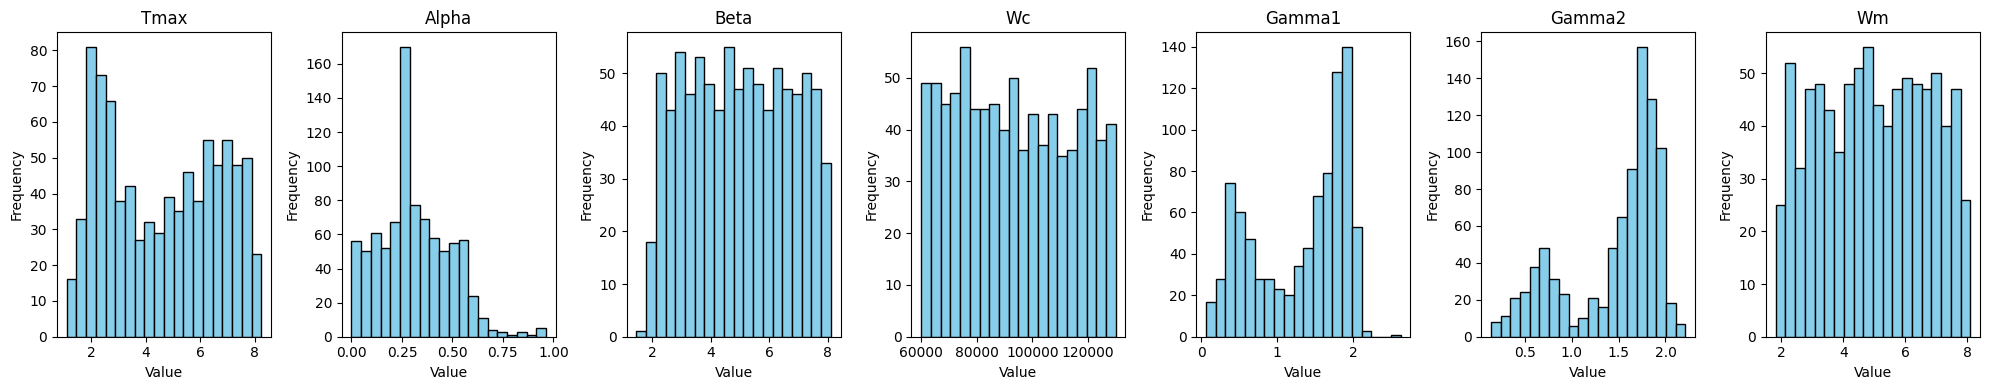

C:\Users\Pedram\AppData\Local\Temp\ipykernel_1648\985960118.py:367: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(all_params_array, labels=param_names, patch_artist=True)


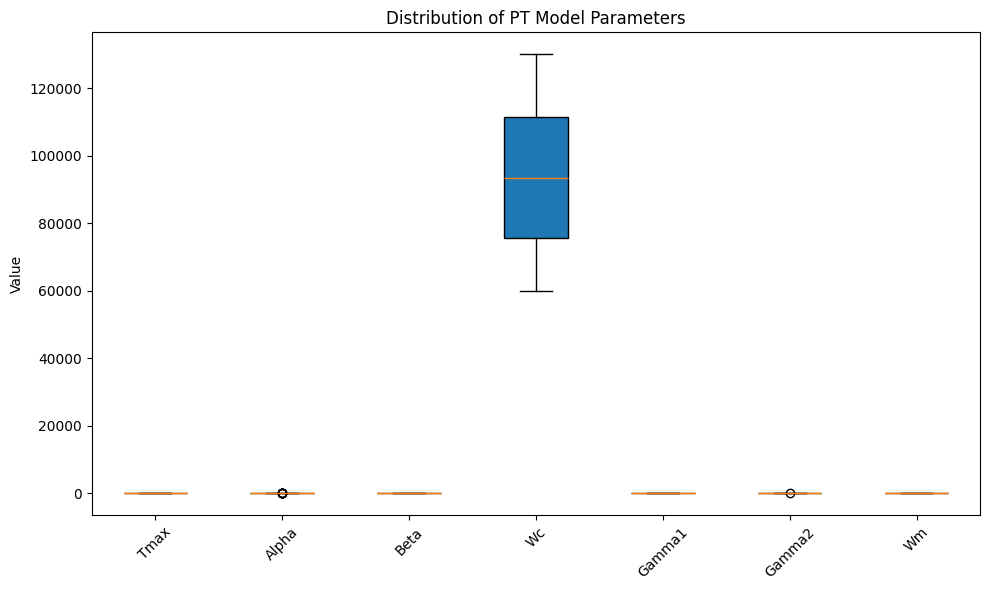

Saved results for I294l1_S to C:\Users\Pedram\Desktop\PEDRAM - DO NOT TOUCH\PT_IDM\Plots\PT_I294l1_S.csv
Processing Follower ID: 62, Run Index: 8


C:\Users\Pedram\AppData\Local\Temp\ipykernel_1648\985960118.py:226: RuntimeWarning: divide by zero encountered in divide
  mape_speed = np.mean(np.abs(diff_speed / np.array(target_speed))) * 100 * weight_speed


Processing Follower ID: 12, Run Index: 1
Processing Follower ID: 22, Run Index: 11
Processing Follower ID: 3, Run Index: 7
Processing Follower ID: 28, Run Index: 9
Processing Follower ID: 59, Run Index: 18
Processing Follower ID: 30, Run Index: 9
Processing Follower ID: 41, Run Index: 3
Processing Follower ID: 17, Run Index: 21
Processing Follower ID: 35, Run Index: 11
Processing Follower ID: 25, Run Index: 19
Processing Follower ID: 48, Run Index: 20
Processing Follower ID: 18, Run Index: 19
Processing Follower ID: 56, Run Index: 18
Processing Follower ID: 9, Run Index: 1
Processing Follower ID: 19, Run Index: 11
Processing Follower ID: 11, Run Index: 7
Processing Follower ID: 65, Run Index: 8


C:\Users\Pedram\AppData\Local\Temp\ipykernel_1648\985960118.py:226: RuntimeWarning: divide by zero encountered in divide
  mape_speed = np.mean(np.abs(diff_speed / np.array(target_speed))) * 100 * weight_speed


Processing Follower ID: 50, Run Index: 20
Processing Follower ID: 40, Run Index: 3
Processing Follower ID: 64, Run Index: 18
Processing Follower ID: 54, Run Index: 20
Processing Follower ID: 17, Run Index: 7
Processing Follower ID: 8, Run Index: 1
Processing Follower ID: 51, Run Index: 8


C:\Users\Pedram\AppData\Local\Temp\ipykernel_1648\985960118.py:226: RuntimeWarning: divide by zero encountered in divide
  mape_speed = np.mean(np.abs(diff_speed / np.array(target_speed))) * 100 * weight_speed


Processing Follower ID: 33, Run Index: 3
Processing Follower ID: 19, Run Index: 19
Processing Follower ID: 24, Run Index: 9
Processing Follower ID: 11, Run Index: 21
Processing Follower ID: 13, Run Index: 21


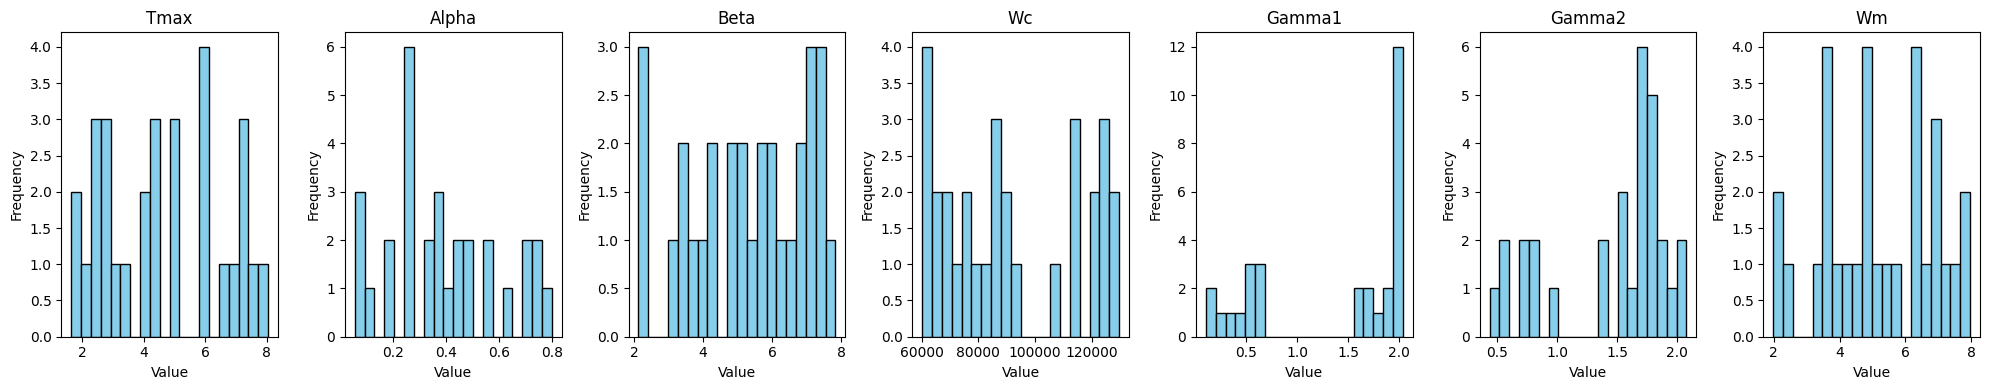

C:\Users\Pedram\AppData\Local\Temp\ipykernel_1648\985960118.py:367: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(all_params_array, labels=param_names, patch_artist=True)


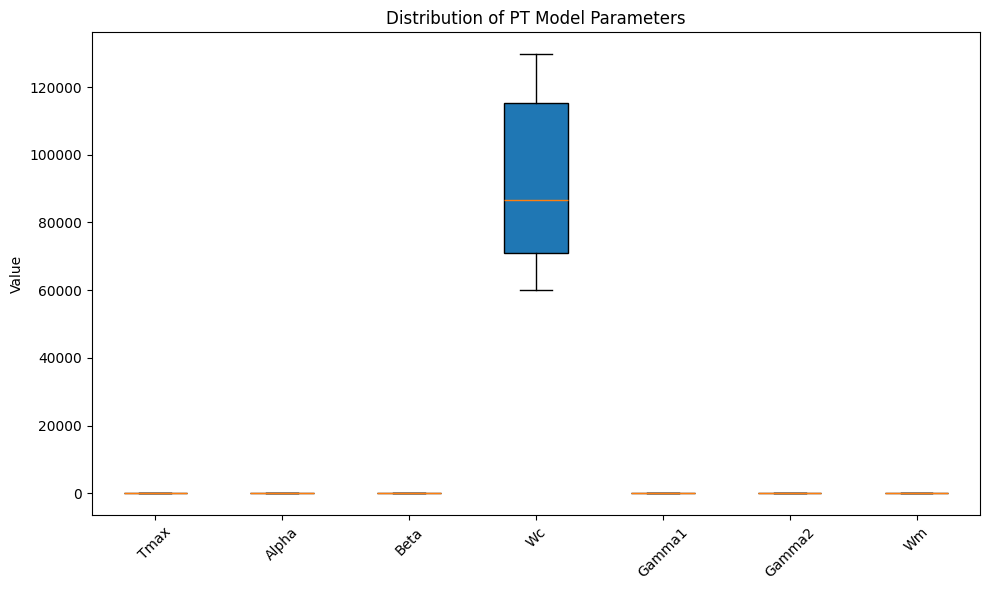

Saved results for I294l1_A to C:\Users\Pedram\Desktop\PEDRAM - DO NOT TOUCH\PT_IDM\Plots\PT_I294l1_A.csv
Processing Follower ID: 267, Run Index: 29
Processing Follower ID: 425, Run Index: 23
No subject data found for Follower ID 216 and Run Index 29.
Processing Follower ID: 216, Run Index: 29
No data found for Follower ID 216 and Run Index 29. Skipping...
Processing Follower ID: 156, Run Index: 42
Processing Follower ID: 72, Run Index: 36
Processing Follower ID: 200, Run Index: 42
Processing Follower ID: 293, Run Index: 38
Processing Follower ID: 166, Run Index: 28
Processing Follower ID: 86, Run Index: 38
Processing Follower ID: 231, Run Index: 38
Processing Follower ID: 180, Run Index: 36
Processing Follower ID: 13, Run Index: 35
Processing Follower ID: 97, Run Index: 31
Processing Follower ID: 28, Run Index: 23
Processing Follower ID: 395, Run Index: 36
Processing Follower ID: 204, Run Index: 23
Processing Follower ID: 213, Run Index: 35
Processing Follower ID: 105, Run Index: 29
Pr

C:\Users\Pedram\AppData\Local\Temp\ipykernel_1648\985960118.py:229: RuntimeWarning: invalid value encountered in scalar divide
  nrmse_position = rmse_position / (np.max(target_position) - np.min(target_position))
C:\Users\Pedram\AppData\Local\Temp\ipykernel_1648\985960118.py:230: RuntimeWarning: invalid value encountered in scalar divide
  nrmse_speed = rmse_speed / (np.max(target_speed) - np.min(target_speed))
C:\Users\Pedram\AppData\Local\Temp\ipykernel_1648\985960118.py:239: RuntimeWarning: invalid value encountered in scalar divide
  r2_position = 1 - (ss_res_position / ss_tot_position)
C:\Users\Pedram\AppData\Local\Temp\ipykernel_1648\985960118.py:243: RuntimeWarning: invalid value encountered in scalar divide
  r2_speed = 1 - (ss_res_speed / ss_tot_speed)


Processing Follower ID: 288, Run Index: 31
Processing Follower ID: 328, Run Index: 42
No subject data found for Follower ID 364 and Run Index 41.
Processing Follower ID: 364, Run Index: 41
No data found for Follower ID 364 and Run Index 41. Skipping...
Processing Follower ID: 311, Run Index: 35
No subject data found for Follower ID 314 and Run Index 31.
Processing Follower ID: 314, Run Index: 31
No data found for Follower ID 314 and Run Index 31. Skipping...
Processing Follower ID: 347, Run Index: 31
Processing Follower ID: 260, Run Index: 5


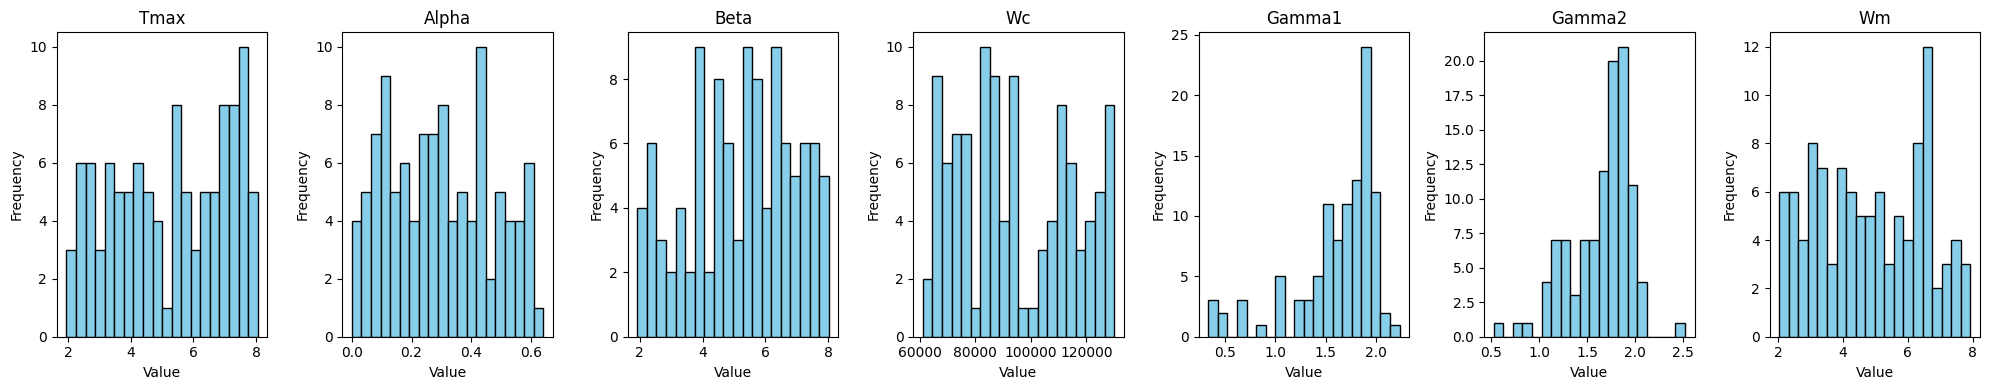

C:\Users\Pedram\AppData\Local\Temp\ipykernel_1648\985960118.py:367: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(all_params_array, labels=param_names, patch_artist=True)


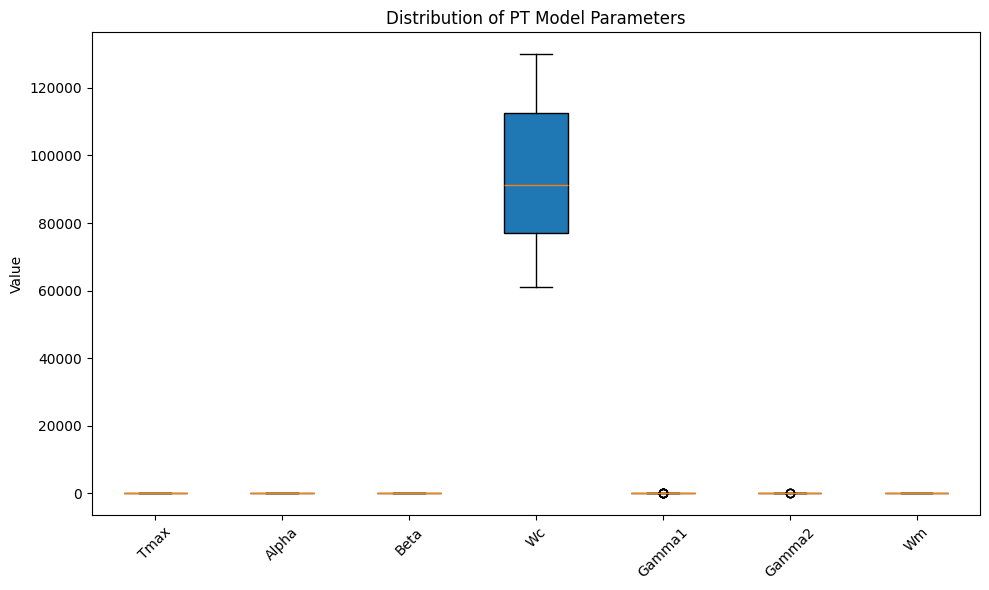

Saved results for I294l2_L to C:\Users\Pedram\Desktop\PEDRAM - DO NOT TOUCH\PT_IDM\Plots\PT_I294l2_L.csv
Processing Follower ID: 352, Run Index: 33
Processing Follower ID: 513, Run Index: 5
Processing Follower ID: 48, Run Index: 36
Processing Follower ID: 500, Run Index: 35
Processing Follower ID: 280, Run Index: 41
Processing Follower ID: 417, Run Index: 28
No subject data found for Follower ID 94 and Run Index 30.
Processing Follower ID: 94, Run Index: 30
No data found for Follower ID 94 and Run Index 30. Skipping...
Processing Follower ID: 83, Run Index: 30
Processing Follower ID: 11, Run Index: 23
Processing Follower ID: 292, Run Index: 33
Processing Follower ID: 314, Run Index: 33
Processing Follower ID: 52, Run Index: 42
Processing Follower ID: 189, Run Index: 29
Processing Follower ID: 219, Run Index: 30
No subject data found for Follower ID 234 and Run Index 28.
Processing Follower ID: 234, Run Index: 28
No data found for Follower ID 234 and Run Index 28. Skipping...
Processing

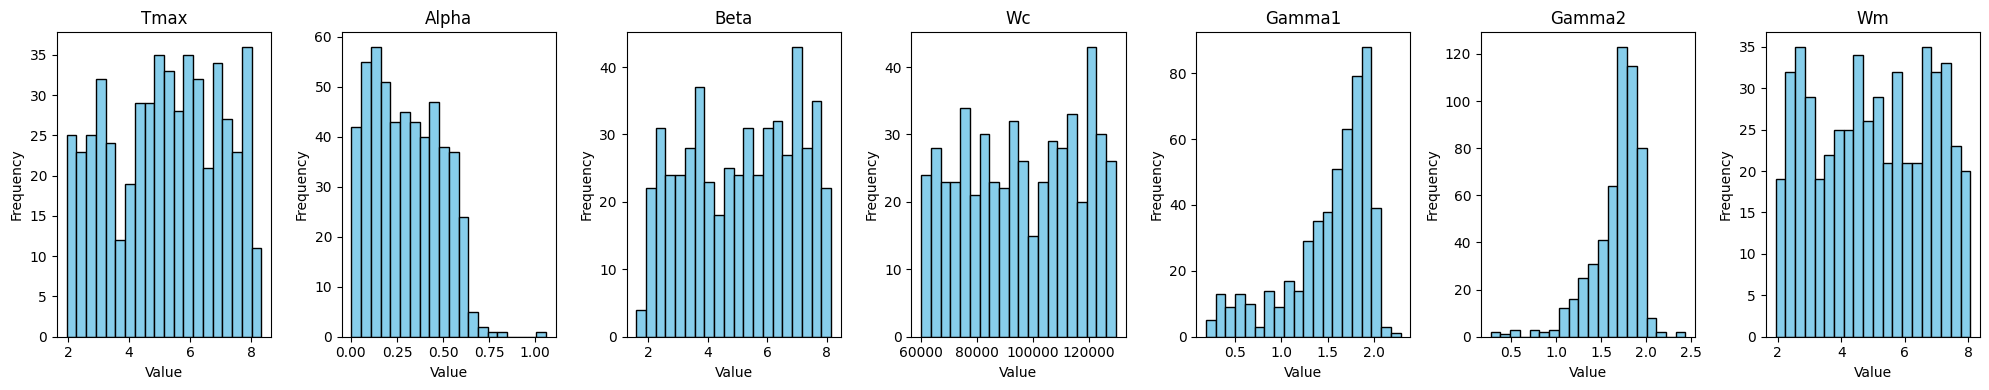

C:\Users\Pedram\AppData\Local\Temp\ipykernel_1648\985960118.py:367: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(all_params_array, labels=param_names, patch_artist=True)


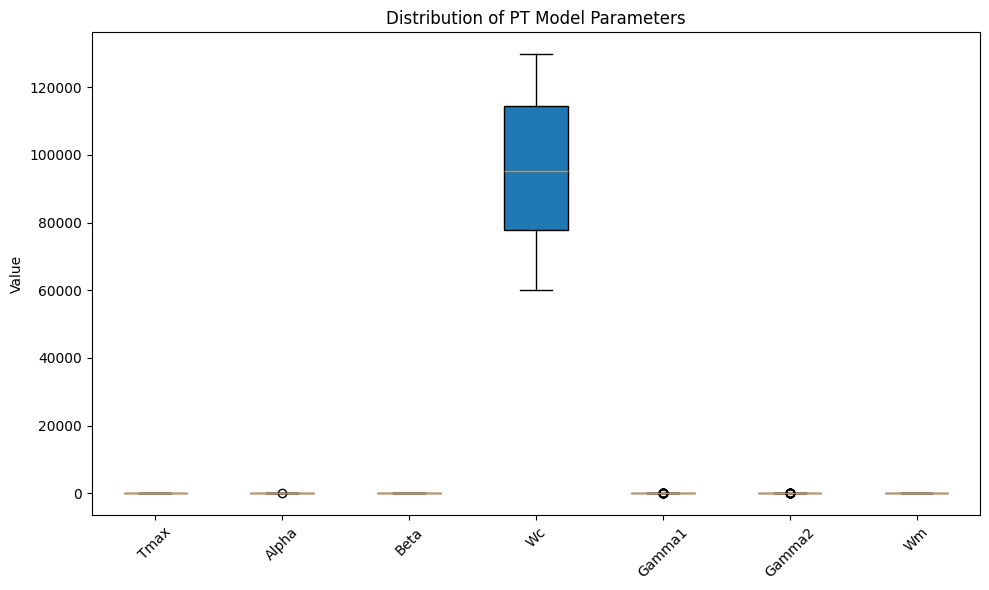

Saved results for I294l2_S to C:\Users\Pedram\Desktop\PEDRAM - DO NOT TOUCH\PT_IDM\Plots\PT_I294l2_S.csv
Processing Follower ID: 231, Run Index: 31
Processing Follower ID: 118, Run Index: 30
Processing Follower ID: 229, Run Index: 42
Processing Follower ID: 46, Run Index: 36
Processing Follower ID: 181, Run Index: 33
Processing Follower ID: 107, Run Index: 23
Processing Follower ID: 90, Run Index: 29
Processing Follower ID: 291, Run Index: 28
Processing Follower ID: 218, Run Index: 35
Processing Follower ID: 211, Run Index: 41
Processing Follower ID: 462, Run Index: 5
Processing Follower ID: 72, Run Index: 38


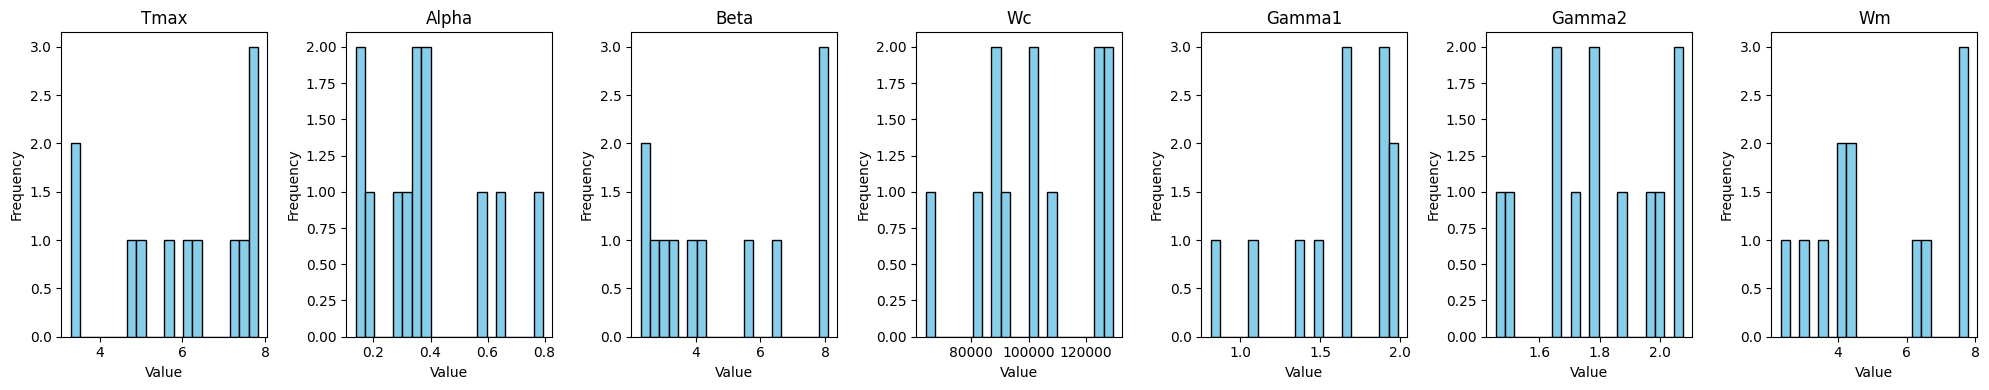

C:\Users\Pedram\AppData\Local\Temp\ipykernel_1648\985960118.py:367: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(all_params_array, labels=param_names, patch_artist=True)


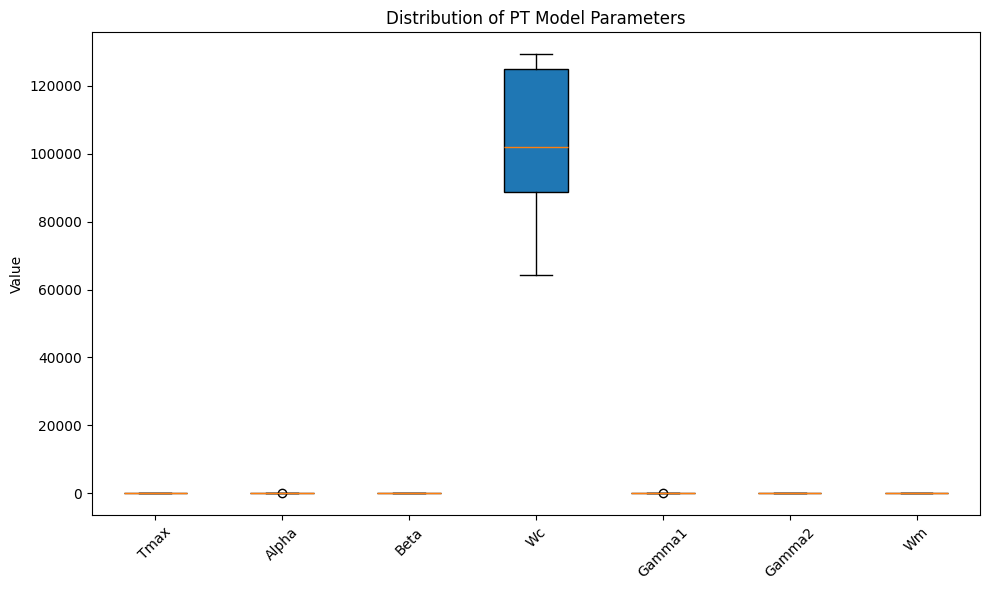

Saved results for I294l2_A to C:\Users\Pedram\Desktop\PEDRAM - DO NOT TOUCH\PT_IDM\Plots\PT_I294l2_A.csv


In [23]:
import os
import pandas as pd
import numpy as np

datasets = {
    #"df395": "C:\\Users\\Pedram\\Desktop\\PEDRAM - DO NOT TOUCH\\PT_IDM\\I395-final-run-index.csv",
    "df9094": "C:\\Users\\Pedram\\Desktop\\PEDRAM - DO NOT TOUCH\\PT_IDM\\I90_94_moving_final.csv",
    "df294l1": "C:\\Users\\Pedram\\Desktop\\PEDRAM - DO NOT TOUCH\\PT_IDM\\I294_L1_final.csv",
    "df294l2": "C:\\Users\\Pedram\\Desktop\\PEDRAM - DO NOT TOUCH\\PT_IDM\\I294_L2_final.csv"}

groups = {
    #"df395": ["I395_A", "I395_S", "I395_L"],
    #"df9094": ["I9094_L", "I9094_S", "I9094_A"],
    "df9094": ["I9094_S", "I9094_A"],
    "df294l1": ["I294l1_L", "I294l1_S", "I294l1_A"],
    "df294l2": ["I294l2_L", "I294l2_S", "I294l2_A"]}

# Save directory for plots
save_dir = "C:\\Users\\Pedram\\Desktop\\PEDRAM - DO NOT TOUCH\\PT_IDM\\Plots\\"

# Ensure save directory exists
os.makedirs(save_dir, exist_ok=True)

# Iterate through each dataset and group
for df_key, df_path in datasets.items():
    df = pd.read_csv(df_path)
    df = df.sort_values(by='time')
    df['time'] = df['time'].round(1)
    pos = "xloc-kf"
    #pos = "yloc-kf" if df_key == "df395" else "xloc-kf"
    
    for group in groups[df_key]:
        # Define the output CSV file name for this group
        outname = f"PT_{group}.csv"
        output_csv_path = os.path.join(save_dir, outname)
        
        # Check if the CSV file already exists
        if os.path.exists(output_csv_path):
            print(f"File {output_csv_path} already exists. Skipping...")
            continue  # Skip this group
        
        # Define the current group
        AVs = eval(group)  # Assuming `group` evaluates to a list of tuples
        all_params = []
        params_list = []

        for data in AVs:
            follower_id, run_index = data
            sdf, ldf = extract_subject_and_leader_data(df, follower_id, run_index)
            print(f"Processing Follower ID: {follower_id}, Run Index: {run_index}")
            
            # Check if sdf is empty
            if sdf.empty:
                print(f"No data found for Follower ID {follower_id} and Run Index {run_index}. Skipping...")
                continue
            
            total_time = len(ldf) * 0.1
            time_step, num_steps = 0.1, round(total_time / 0.1)
            timex = np.linspace(0, total_time, num_steps)
            leader_position, leader_speed = ldf[pos].tolist(), ldf['speed-kf'].tolist()
            target_position, target_speed = sdf[pos].tolist(), sdf['speed-kf'].tolist()
            best_params, best_error, best_metrics = genetic_algorithm()

            if best_params is None or best_error is None or not best_metrics:
                print(f"Skipping Follower ID {follower_id}, Run Index {run_index} due to missing optimization results.")
                continue
            
            all_params.append(best_params)
            params_list.append([follower_id, run_index] + best_params + [best_error] + list(best_metrics.values()))
            
            sim_position, sim_speed, acl = simulate_car_following(best_params)
            plot_simulation(
                timex, leader_position, target_position, sim_position,
                leader_speed, target_speed, sim_speed, follower_id,
                most_leading_leader_id, run_index, save_dir)
        
        # Visualize parameter distributions
        visualize_parameter_distributions(all_params)
        
        # Save parameters to a CSV file
        metrics_names = list(best_metrics.keys())
        columns = ['Follower_ID', 'Run_Index', 'Tmax', 'Alpha', 'Beta', 'Wc', 'Gamma1', 'Gamma2', 'Wm', 'Error'] + metrics_names
        params_df = pd.DataFrame(params_list, columns=columns)
        params_df.to_csv(output_csv_path, index=False)
        print(f"Saved results for {group} to {output_csv_path}")